# DESeq1
# Phase 2 vs. Phase 2

focusing on pairwise comparisons of oysters that experienced both phase 1 and phase 2

## 0. load libraries

In [2]:
library(tidyverse)
library(DESeq2)
library(EnhancedVolcano) # for volcano plots
library(vegan) # for permanova
library(pheatmap)
library(RColorBrewer)

## 1. read counts matrix and meta data

### counts matrix

In [3]:
# counts matrix
counts <- read.csv('/work/pi_sarah_gignouxwolfsohn_uml_edu/julia_mcdonough_student_uml_edu/ce24_rnaseq/featureCounts/featureCounts_matrix.csv')

# set gene_ID as row name
rownames(counts) <- counts$Gene_ID

# remove gene id and length
counts.df <- counts %>%
select(-Gene_ID, -Length)

head(counts.df)

B1_B1_O01 B1_Nu_O03 B1_W5_O50 B2_B5_O51 B2_C4_O40 B2_Nu_O12
LOC111116054   2         1         6        10         9        16      
LOC111126949 885       652       477       654       586       523      
LOC111110729  64       209        93        63       100       177      
LOC111112434  11         7         2         0         2         2      
LOC111120752 360       586       336       426       351       417      
LOC111128944   0         0         0         0         0         0      
             B3_B4_O41 B3_C3_O30 B3_C6_O66 B3_H4_O41 ⋯ W5_C4_G45 W5_H4_G46
LOC111116054   0        10        22         9       ⋯   9         2      
LOC111126949 392       357       496       540       ⋯ 407       740      
LOC111110729  76        98       235       181       ⋯  70       149      
LOC111112434  12        15        10        36       ⋯  11         6      
LOC111120752 236       278       761       373       ⋯ 359       345      
LOC111128944   0         0         0         0       ⋯   0         0      
             W5_W2_G22 W6_B3_G35 W6_B4_G48 W6_H6_G71 W6_Nu_G41 W6_Nu_G45
LOC111116054   8         5         2        19         1         2      
LOC111126949 707       406       418       424       492       330      
LOC111110729 121       115       126       108       118       115      
LOC111112434   4         0         2        16        22         0      
LOC111120752 438       278       287       416       621       251      
LOC111128944   0         0         0         0         0         1      
             W6_W3_G36 W6_W4_G48
LOC111116054   1         0      
LOC111126949 281       599      
LOC111110729 127       213      
LOC111112434   8         0      
LOC111120752 333       430      
LOC111128944   0         0

In [4]:
# number of genes with 0 counts for all samples
sum(rowSums(counts.df) == 0) # 3372 genes

# pre-filter those rows
counts.filtered <- counts.df[!rowSums(counts.df) == 0,]

# double check this worked
dim(counts.df) # 38838 total genes
dim(counts.filtered) # 35466 genes with at least 1 read

[1] 3372

[1] 38838   120

[1] 35466   120

### meta data
the meta data csv was already generated in [deseq_p1.v.p1](https://github.com/jgmcdonough/CE24_RNA-seq/blob/main/analysis/diff_expression/phase1_v_phase1/deseq_p1.v.p1.ipynb), so just reading in here

In [6]:
meta <- read.csv('/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/metaData/sample_metaData.csv') %>%
filter(!grepl("Nu", Sample)) # filter out phase 1 samples - only want phase 2

# setting samples as rownames and deleting col from df
rownames(meta) <- meta$Sample
meta <- meta[, !colnames(meta) %in% "Sample"]

head(meta)
dim(meta)

Phase1_treatment Phase1_temp Phase1_DO Phase1_TankRep
B1_B1_O01 both             warm        hypoxic   1             
B1_W5_O50 both             warm        hypoxic   1             
B2_B5_O51 both             warm        hypoxic   2             
B2_C4_O40 both             warm        hypoxic   2             
B3_B4_O41 both             warm        hypoxic   3             
B3_C3_O30 both             warm        hypoxic   3             
          Phase2_treatment Phase2_temp Phase2_DO Phase2_TankRep
B1_B1_O01 both             warm        hypoxic   1             
B1_W5_O50 warm             warm        normoxic  5             
B2_B5_O51 both             warm        hypoxic   5             
B2_C4_O40 control          ambient     normoxic  4             
B3_B4_O41 both             warm        hypoxic   4             
B3_C3_O30 control          ambient     normoxic  3

[1] 96  8

creating new column for 'complete' treatment - so I can easily compare phase 1 to phase 2

In [7]:
meta$complete_trtmt <- paste(meta$Phase1_treatment, meta$Phase2_treatment)

# check
head(meta,2)
tail(meta,2)

Phase1_treatment Phase1_temp Phase1_DO Phase1_TankRep
B1_B1_O01 both             warm        hypoxic   1             
B1_W5_O50 both             warm        hypoxic   1             
          Phase2_treatment Phase2_temp Phase2_DO Phase2_TankRep complete_trtmt
B1_B1_O01 both             warm        hypoxic   1              both both     
B1_W5_O50 warm             warm        normoxic  5              both warm

Phase1_treatment Phase1_temp Phase1_DO Phase1_TankRep
W6_W3_G36 warm             warm        normoxic  6             
W6_W4_G48 warm             warm        normoxic  6             
          Phase2_treatment Phase2_temp Phase2_DO Phase2_TankRep complete_trtmt
W6_W3_G36 warm             warm        normoxic  3              warm warm     
W6_W4_G48 warm             warm        normoxic  4              warm warm

In [8]:
# setting the same order for counts matrix and meta data
counts.filtered <- counts.filtered[,rownames(meta)]
all(rownames(meta) == colnames(counts.filtered))

[1] TRUE

## 2. DESeq2
analyzing differential gene expression with [`DESeq2`](https://bioconductor.org/packages/release/bioc/vignettes/DESeq2/inst/doc/DESeq2.html)

#### contrasts
setting up contrasts (telling DESeq what is the control treatment)

In [9]:
# tempature treatments
meta$Phase1_temp <- factor(meta$Phase1_temp,
                                   levels = c('ambient', 'warm'))

meta$Phase2_temp <- factor(meta$Phase2_temp,
                                   levels = c('ambient', 'warm'))

In [10]:
# DO treatments
meta$Phase1_DO <- factor(meta$Phase1_DO,
                                   levels = c('normoxic', 'hypoxic'))

meta$Phase2_DO <- factor(meta$Phase2_DO,
                                   levels = c('normoxic', 'hypoxic'))

### complete treatments
starting simple with looking at phase 1 treatments (not splitting into temperature/DO, just looking at combination of treatments)

In [10]:
# creating DESeq2 object
dds <- DESeqDataSetFromMatrix(countData = counts.filtered,
                              colData = meta,
                              design = ~ complete_trtmt)
dds

# running DESeq
dds <- DESeq(dds)

# list coefficients
resultsNames(dds)

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]



class: DESeqDataSet 
dim: 35466 96 
metadata(1): version
assays(1): counts
rownames(35466): LOC111116054 LOC111126949 ... ND1 ND4L
rowData names(0):
colnames(96): B1_B1_O01 B1_W5_O50 ... W6_W3_G36 W6_W4_G48
colData names(9): Phase1_treatment Phase1_temp ... Phase2_TankRep
  complete_trtmt

estimating size factors

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

estimating dispersions

gene-wise dispersion estimates



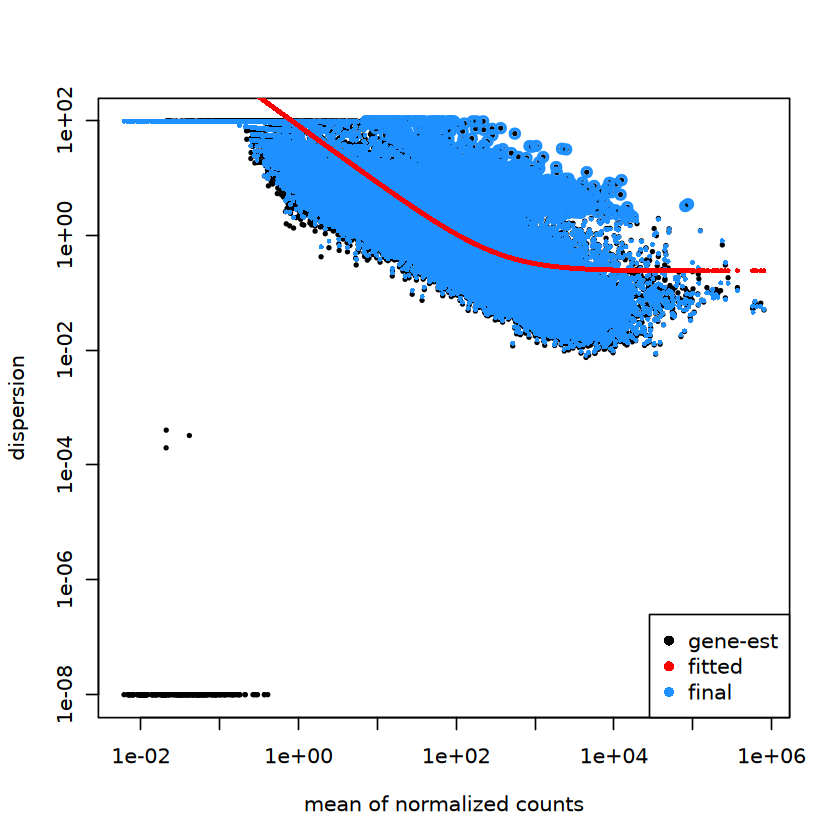

In [15]:
plotDispEsts(dds)

## nMDS
normalize and transform DESeq object using csv (variance stabilized expression matrix)

In [16]:
# normalization & transformation
vsd <- vst(dds)

# calculate sample distances
sample_dists <- assay(vsd) %>%
t() %>%
dist() %>%
as.matrix()

head(sample_dists)

# calculate MDS value from distance matrix
mdsData <- data.frame(cmdscale(sample_dists))
mds <- cbind(mdsData, as.data.frame(colData(vsd))) # combine with sample data
head(mds)

B1_B1_O01 B1_W5_O50 B2_B5_O51 B2_C4_O40 B3_B4_O41 B3_C3_O30 B3_C6_O66
B1_B1_O01   0.0000  112.87364 115.3262  107.89794 115.25554 113.48167 122.9179 
B1_W5_O50 112.8736    0.00000 109.3705   92.94934  92.51608  97.48152 101.4467 
B2_B5_O51 115.3262  109.37055   0.0000  115.95337 111.82418 118.24287 112.7788 
B2_C4_O40 107.8979   92.94934 115.9534    0.00000  99.34984  96.00067 108.4873 
B3_B4_O41 115.2555   92.51608 111.8242   99.34984   0.00000 105.68102 108.0776 
B3_C3_O30 113.4817   97.48152 118.2429   96.00067 105.68102   0.00000 114.2894 
          B3_H4_O41 B3_W1_O06 B3_W4_O41 ⋯ W4_W5_G56 W5_B2_G21 W5_C4_G45
B1_B1_O01 116.1678  114.67824 105.7388  ⋯ 131.0135  110.9503   95.3255 
B1_W5_O50 113.4727  106.26615 106.0474  ⋯ 108.4771  117.2177  110.3544 
B2_B5_O51 125.5576  128.07360 123.0549  ⋯ 117.1577  129.0589  121.7444 
B2_C4_O40 111.2476  112.74691 100.7027  ⋯ 114.3448  111.0231  107.5110 
B3_B4_O41 119.5018   97.63448 111.9091  ⋯ 107.0356  120.5420  112.3259 
B3_C3_O30 119.6456  115.27810 111.7599  ⋯ 120.7426  118.9125  108.0603 
          W5_H4_G46 W5_W2_G22 W6_B3_G35 W6_B4_G48 W6_H6_G71 W6_W3_G36 W6_W4_G48
B1_B1_O01 104.5872  101.6345  105.9910  123.9108  108.3290  104.35939 129.5139 
B1_W5_O50 111.4573  111.7282  110.5900  114.0655  110.8031  104.15168 109.1279 
B2_B5_O51 105.0726  118.6173  123.0947  119.5198  123.0654  116.52978 109.4809 
B2_C4_O40 108.3220  106.9164  106.7425  121.0028  105.3548   84.68172 116.2580 
B3_B4_O41 113.9681  117.6559  115.5445  110.0930  115.2253  108.74247 109.6183 
B3_C3_O30 115.0886  114.8697  112.1972  126.0074  108.2107  108.42614 123.0013

X1         X2         Phase1_treatment Phase1_temp Phase1_DO
B1_B1_O01  14.051733  16.698775 both             warm        hypoxic  
B1_W5_O50  -3.585329 -22.358652 both             warm        hypoxic  
B2_B5_O51 -20.966187  -9.778556 both             warm        hypoxic  
B2_C4_O40   6.786560 -11.905661 both             warm        hypoxic  
B3_B4_O41 -11.624562 -19.641997 both             warm        hypoxic  
B3_C3_O30   8.824681  -8.946989 both             warm        hypoxic  
          Phase1_TankRep Phase2_treatment Phase2_temp Phase2_DO Phase2_TankRep
B1_B1_O01 1              both             warm        hypoxic   1             
B1_W5_O50 1              warm             warm        normoxic  5             
B2_B5_O51 2              both             warm        hypoxic   5             
B2_C4_O40 2              control          ambient     normoxic  4             
B3_B4_O41 3              both             warm        hypoxic   4             
B3_C3_O30 3              control          ambient     normoxic  3             
          complete_trtmt sizeFactor
B1_B1_O01 both both      1.0714460 
B1_W5_O50 both warm      1.0125468 
B2_B5_O51 both both      1.0641357 
B2_C4_O40 both control   1.1577371 
B3_B4_O41 both both      0.8702869 
B3_C3_O30 both control   0.8565139

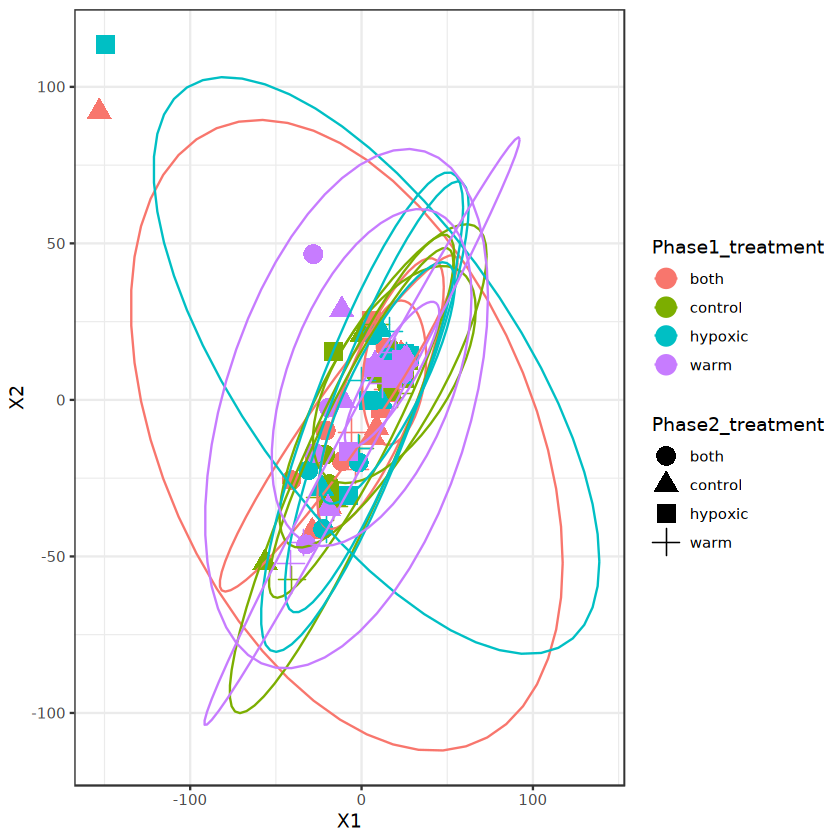

In [17]:
nmds.plot <- ggplot(mds, aes(X1, X2, col = Phase1_treatment, shape = Phase2_treatment)) +
geom_point(size = 5) +
stat_ellipse() + 
theme_bw()

nmds.plot

attempting to make the above plot a little more legible by facetting/coloring and shaping by phase water treatments - but not sure if this actually just makes things more confusing/not the right way to show this

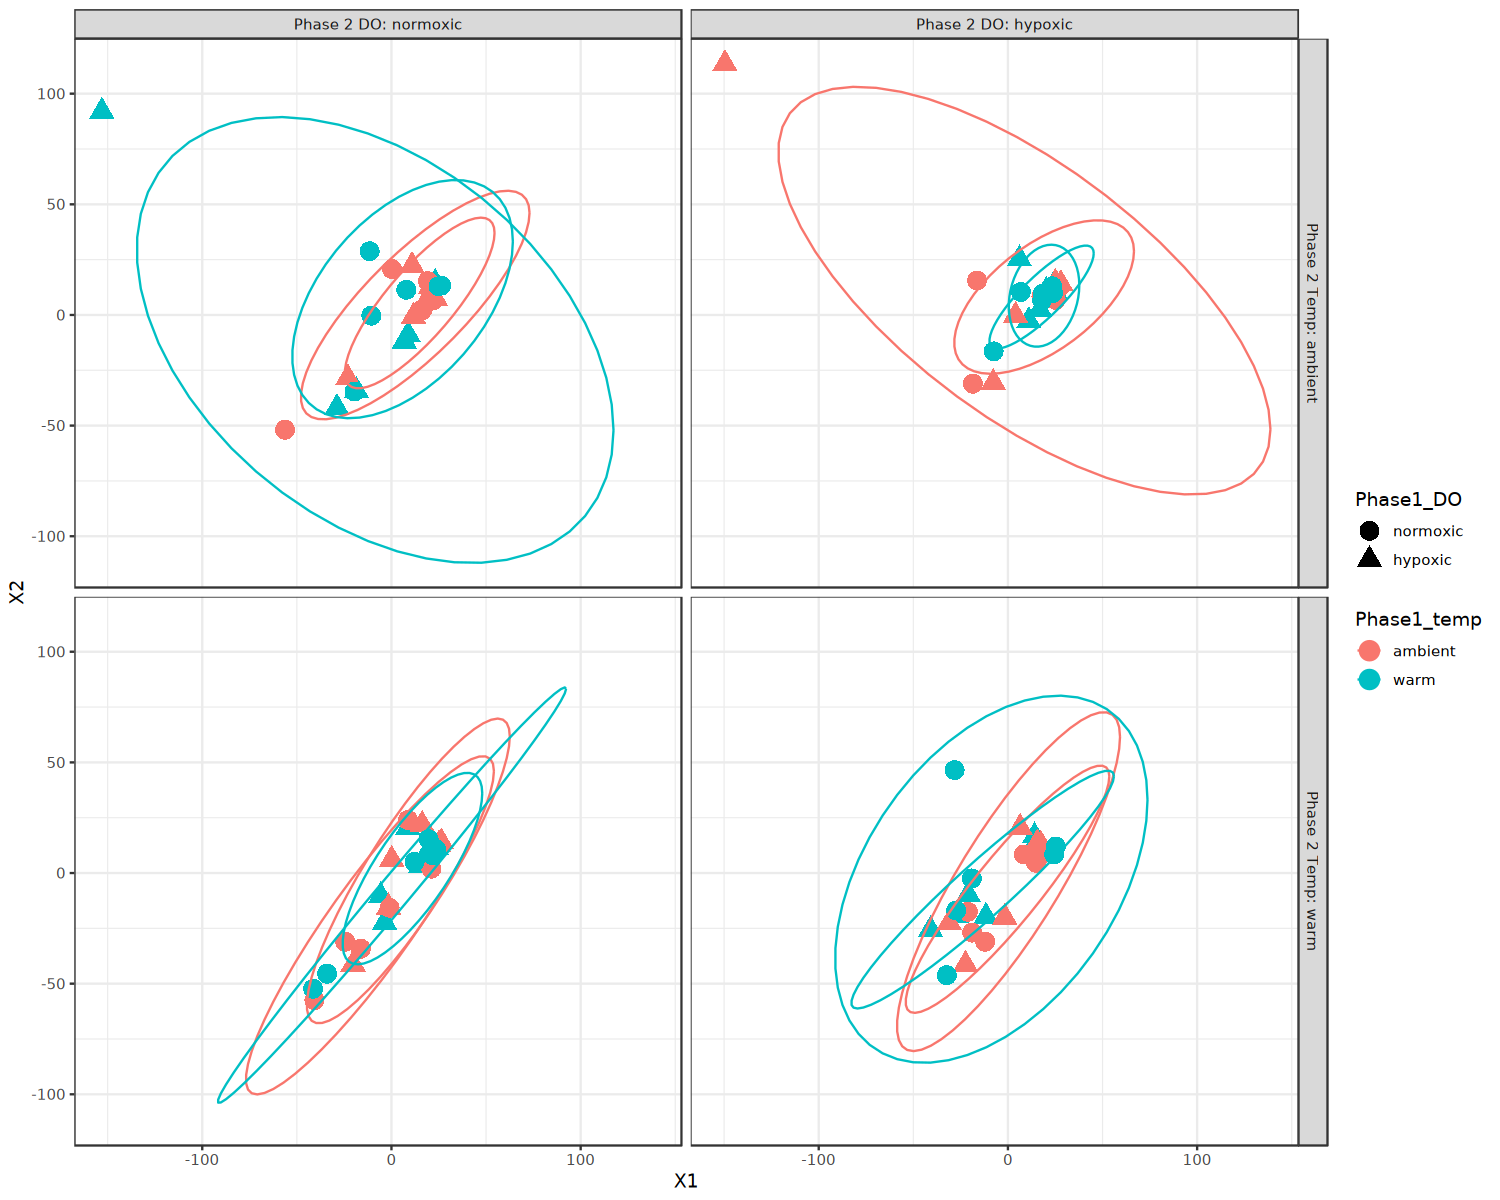

In [18]:
options(repr.plot.width=12.5, repr.plot.height=10)

# faceted by Phase 2 treatment
nmds.plot <- ggplot(mds, aes(X1, X2, col = Phase1_temp, shape = Phase1_DO)) +
geom_point(size = 5) +
stat_ellipse() + 
theme_bw() + 
facet_grid(Phase2_temp ~ Phase2_DO,
           labeller = labeller(
      Phase2_temp = function(x) paste("Phase 2 Temp:", x),
      Phase2_DO   = function(x) paste("Phase 2 DO:", x)
    )
           )

nmds.plot

when phase 2 is normoxic and warm (Warm treatment) - the points are all on top of each other, with very little dispersion

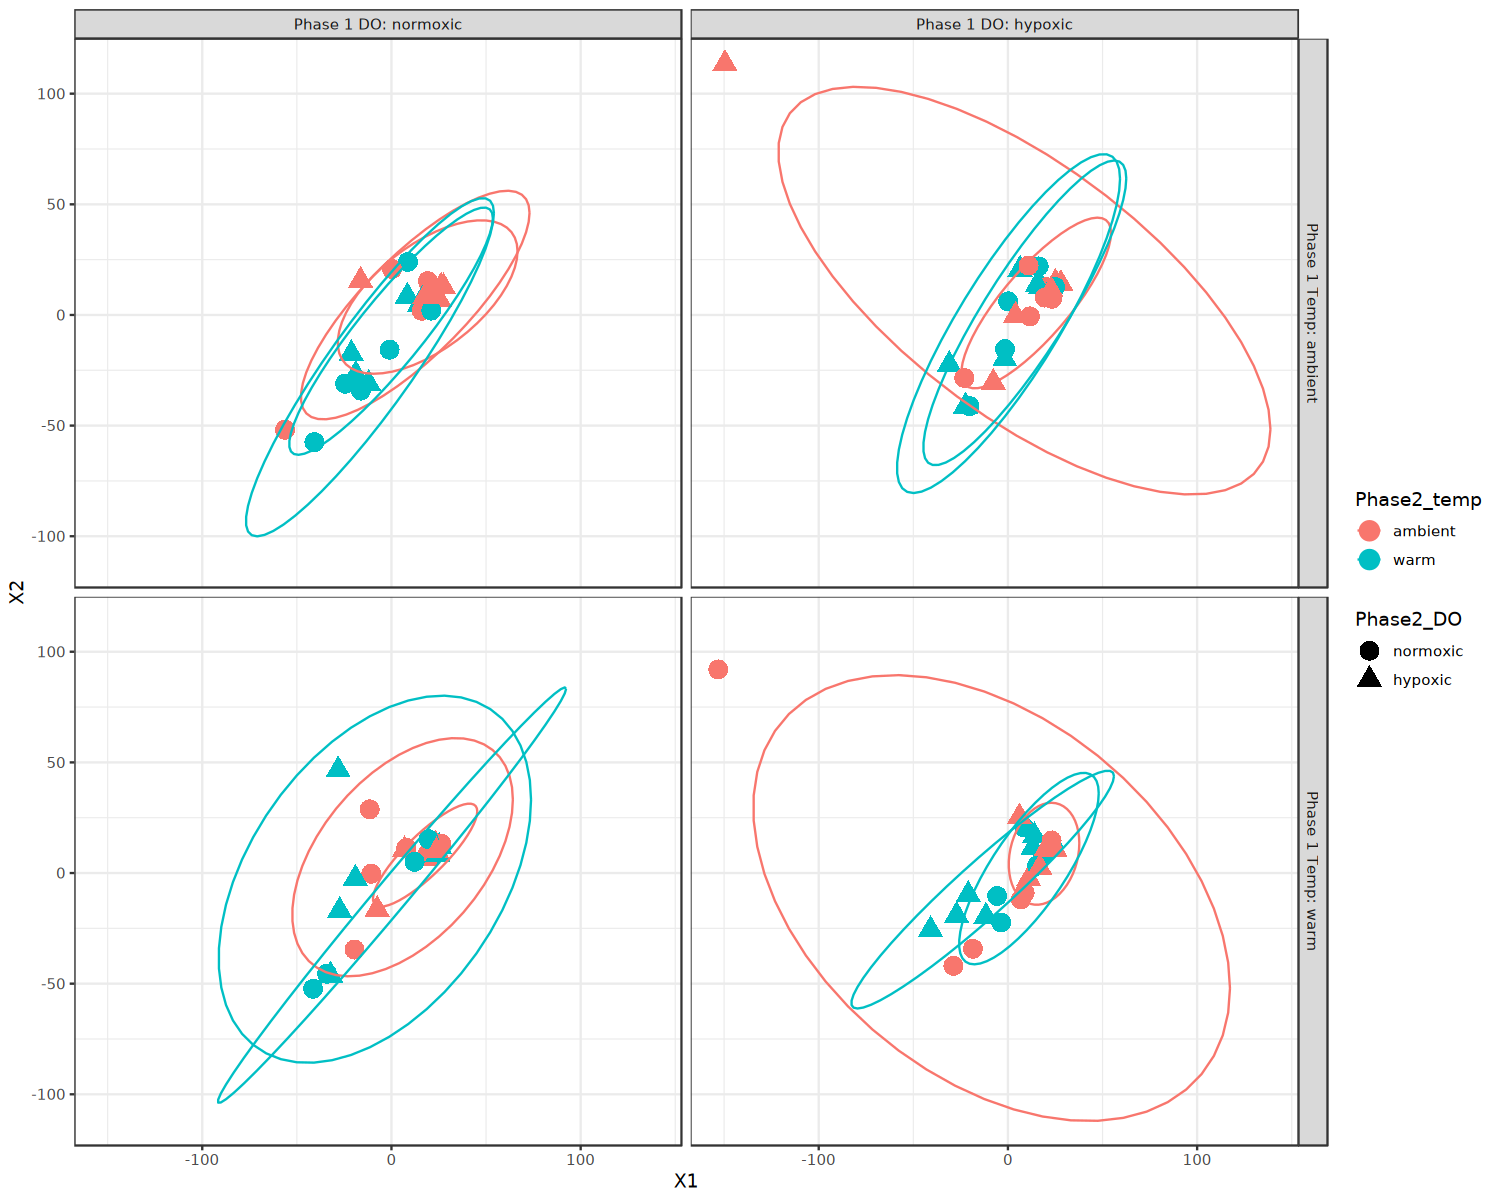

In [24]:
options(repr.plot.width=12.5, repr.plot.height=10)

# faceted by Phase 1 treatment
nmds.plot <- ggplot(mds, aes(X1, X2, col = Phase2_temp, shape = Phase2_DO)) +
geom_point(size = 5) +
stat_ellipse() + 
theme_bw() + 
facet_grid(Phase1_temp ~ Phase1_DO,
           labeller = labeller(
      Phase1_temp = function(x) paste("Phase 1 Temp:", x),
      Phase1_DO   = function(x) paste("Phase 1 DO:", x)
    )
           )

nmds.plot

## permANOVA

In [19]:
sample_dists <- dist(t(assay(vsd)))  # transpose so samples are rows
head(sample_dists)

meta <- as.data.frame(colData(vsd))
head(meta)

[1] 112.8736 115.3262 107.8979 115.2555 113.4817 122.9179

Phase1_treatment Phase1_temp Phase1_DO Phase1_TankRep
B1_B1_O01 both             warm        hypoxic   1             
B1_W5_O50 both             warm        hypoxic   1             
B2_B5_O51 both             warm        hypoxic   2             
B2_C4_O40 both             warm        hypoxic   2             
B3_B4_O41 both             warm        hypoxic   3             
B3_C3_O30 both             warm        hypoxic   3             
          Phase2_treatment Phase2_temp Phase2_DO Phase2_TankRep complete_trtmt
B1_B1_O01 both             warm        hypoxic   1              both both     
B1_W5_O50 warm             warm        normoxic  5              both warm     
B2_B5_O51 both             warm        hypoxic   5              both both     
B2_C4_O40 control          ambient     normoxic  4              both control  
B3_B4_O41 both             warm        hypoxic   4              both both     
B3_C3_O30 control          ambient     normoxic  3              both control  
          sizeFactor
B1_B1_O01 1.0714460 
B1_W5_O50 1.0125468 
B2_B5_O51 1.0641357 
B2_C4_O40 1.1577371 
B3_B4_O41 0.8702869 
B3_C3_O30 0.8565139

In [20]:
adonis2(sample_dists ~ Phase1_temp * Phase1_DO * Phase2_temp * Phase2_DO, data = meta, permutations = 999)

Df SumOfSqs   R2          F        
Phase1_temp                                  1   6436.659 0.009290143 0.8849709
Phase1_DO                                    1   5969.374 0.008615702 0.8207242
Phase2_temp                                  1  13573.403 0.019590729 1.8661956
Phase2_DO                                    1   9153.680 0.013211666 1.2585317
Phase1_temp:Phase1_DO                        1   5134.389 0.007410554 0.7059228
Phase1_temp:Phase2_temp                      1   5290.850 0.007636376 0.7274345
Phase1_DO:Phase2_temp                        1   6350.438 0.009165698 0.8731164
Phase1_temp:Phase2_DO                        1   6029.998 0.008703202 0.8290594
Phase1_DO:Phase2_DO                          1   6800.014 0.009814579 0.9349282
Phase2_temp:Phase2_DO                        1   9477.392 0.013678885 1.3030385
Phase1_temp:Phase1_DO:Phase2_temp            1   6584.395 0.009503372 0.9052828
Phase1_temp:Phase1_DO:Phase2_DO              1   6939.121 0.010015355 0.9540539
Phase1_temp:Phase2_temp:Phase2_DO            1   8889.284 0.012830059 1.2221801
Phase1_DO:Phase2_temp:Phase2_DO              1   8016.276 0.011570032 1.1021510
Phase1_temp:Phase1_DO:Phase2_temp:Phase2_DO  1   6338.892 0.009149034 0.8715289
Residual                                    80 581864.090 0.839814612        NA
Total                                       95 692848.257 1.000000000        NA
                                            Pr(>F)
Phase1_temp                                 0.683 
Phase1_DO                                   0.833 
Phase2_temp                                 0.005 
Phase2_DO                                   0.114 
Phase1_temp:Phase1_DO                       0.978 
Phase1_temp:Phase2_temp                     0.940 
Phase1_DO:Phase2_temp                       0.715 
Phase1_temp:Phase2_DO                       0.792 
Phase1_DO:Phase2_DO                         0.573 
Phase2_temp:Phase2_DO                       0.106 
Phase1_temp:Phase1_DO:Phase2_temp           0.619 
Phase1_temp:Phase1_DO:Phase2_DO             0.518 
Phase1_temp:Phase2_temp:Phase2_DO           0.128 
Phase1_DO:Phase2_temp:Phase2_DO             0.266 
Phase1_temp:Phase1_DO:Phase2_temp:Phase2_DO 0.697 
Residual                                       NA 
Total                                          NA

- Phase2_temp has a significant effect on GE (P = 0.005) and explains ~1.9% of the variation in GE
- The interaction of Phase2_temp and Phase2_DO is nearly significant (P = 0.094) and explains ~1.3% of the variation in GE
- The majoirty of the variation in GE is not explained by the treatments (R2 = 0.84)

#### heatmap of sample-to-sample distances using the variance stabilizing transformed values
following [RNA-seq workflow](https://master.bioconductor.org/packages/release/workflows/vignettes/rnaseqGene/inst/doc/rnaseqGene.html) from Mike Love

In [21]:
# normalization & transformation
vsd <- vst(dds)

# calculate sample distances
sample_dists <- dist(t(assay(vsd)))
head(sample_dists)

[1] 112.8736 115.3262 107.8979 115.2555 113.4817 122.9179

In [27]:
head(vsd)

class: DESeqTransform 
dim: 6 96 
metadata(1): version
assays(1): ''
rownames(6): LOC111116054 LOC111126949 ... LOC111120752 LOC111128944
rowData names(78): baseMean baseVar ... maxCooks dispFit
colnames(96): B1_B1_O01 B1_W5_O50 ... W6_W3_G36 W6_W4_G48
colData names(10): Phase1_treatment Phase1_temp ... complete_trtmt
  sizeFactor

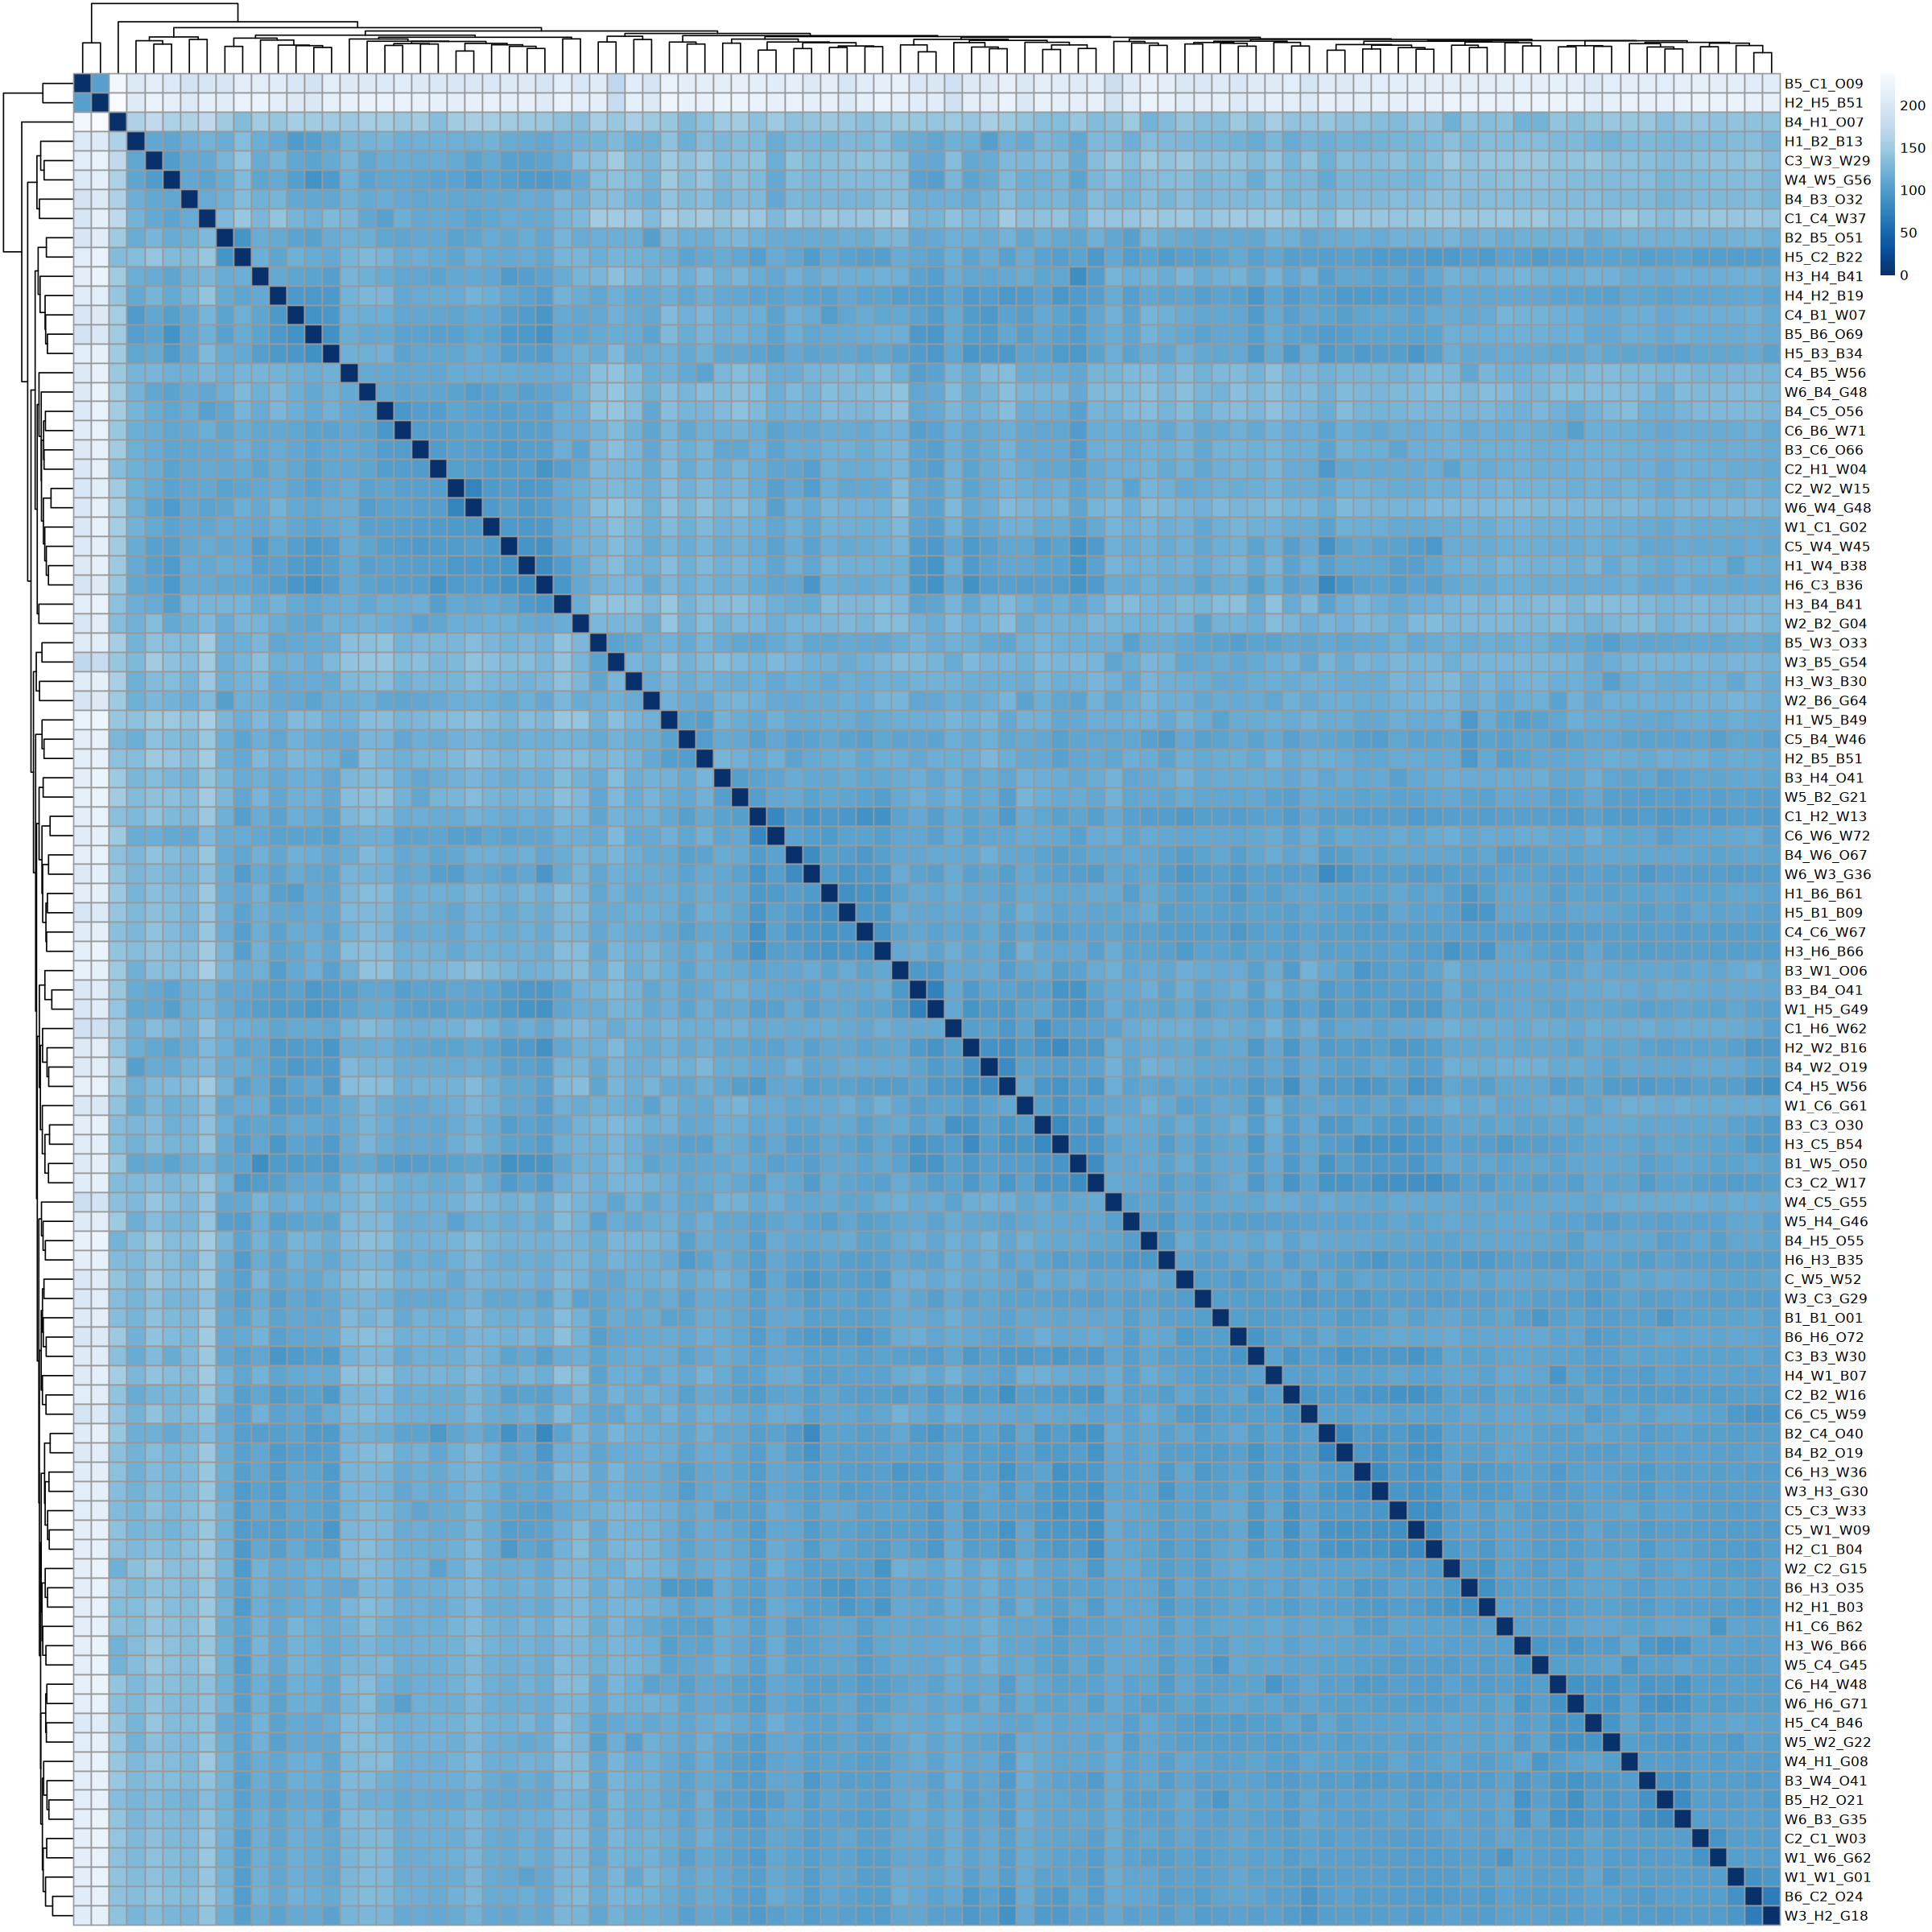

In [28]:
options(repr.plot.width=20, repr.plot.height=20)

sampleDistMatrix <- as.matrix(sample_dists)
rownames(sampleDistMatrix) <- paste(colnames(vsd))
colnames(sampleDistMatrix) <- NULL
colors <- colorRampPalette( rev(brewer.pal(9, "Blues")) )(255)
pheatmap(sampleDistMatrix,
         clustering_distance_rows = sample_dists,
         clustering_distance_cols = sample_dists,
         col = colors)

it's weird that there's two samples that are very dissimilar to every other sample, but appear closer together - (HH and BC) - if you look at the nMDS plots too, they look like outliers from their replicates so should consider removing those samples from analysis 

In [25]:
pcaData <- plotPCA(vsd, intgroup = c( "Phase1_treatment", "Phase2_treatment"), returnData = TRUE)
head(pcaData)

using ntop=500 top features by variance



PC1        PC2        group        Phase1_treatment Phase2_treatment
B1_B1_O01 -15.235433  -6.934442 both:both    both             both            
B1_W5_O50  14.849221   9.509118 both:warm    both             warm            
B2_B5_O51  18.444463 -10.028868 both:both    both             both            
B2_C4_O40   3.515344   7.850587 both:control both             control         
B3_B4_O41  17.977723   6.903814 both:both    both             both            
B3_C3_O30   0.971464   8.528714 both:control both             control         
          name     
B1_B1_O01 B1_B1_O01
B1_W5_O50 B1_W5_O50
B2_B5_O51 B2_B5_O51
B2_C4_O40 B2_C4_O40
B3_B4_O41 B3_B4_O41
B3_C3_O30 B3_C3_O30

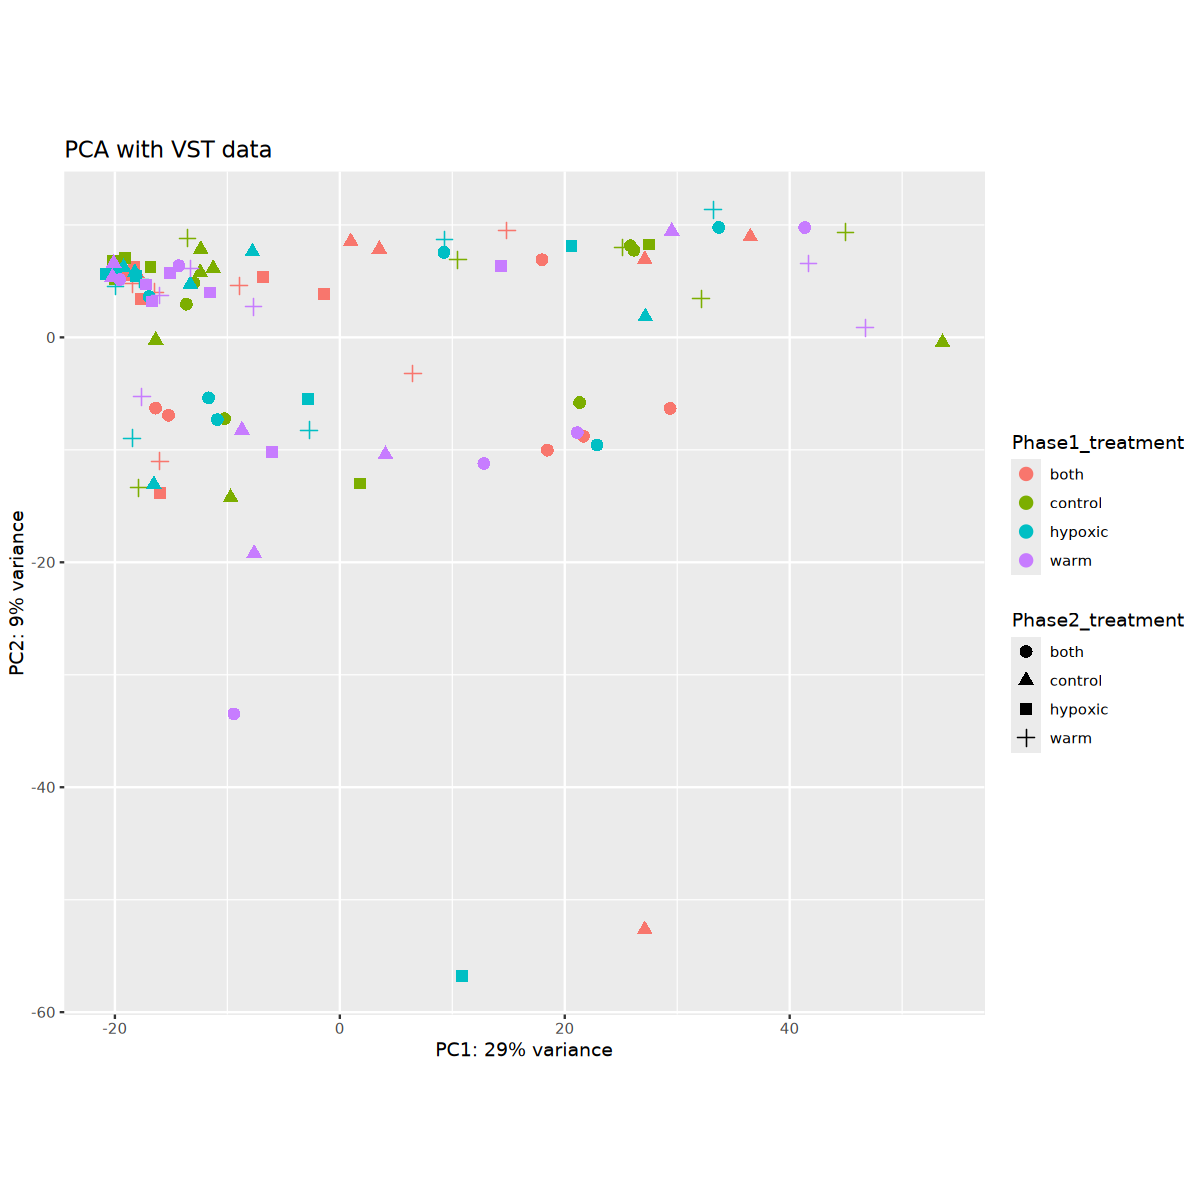

In [26]:
options(repr.plot.width=10, repr.plot.height=10)

percentVar <- round(100 * attr(pcaData, "percentVar"))

ggplot(pcaData, aes(x = PC1, y = PC2, color = Phase1_treatment, shape = Phase2_treatment)) +
  geom_point(size =3) +
  xlab(paste0("PC1: ", percentVar[1], "% variance")) +
  ylab(paste0("PC2: ", percentVar[2], "% variance")) +
  coord_fixed() +
  ggtitle("PCA with VST data")

there's those two samples again in the bottom of the plot - B5_C1_O09 and H2_H5_B51 - that cluster away from everything else 

what do things look like if I remove those?

In [31]:
# remove two samples
dds_filtered <- dds[, !colnames(dds) %in% c("B5_C1_O09", "H2_H5_B51")]

In [35]:
# normalization & transformation
vsd_filtered <- vst(dds_filtered)

# calculate sample distances
sample_dists_filtered <- dist(t(assay(vsd_filtered)))
head(sample_dists_filtered)

[1] 100.4635 102.6446  96.1057 102.8532 101.2851 109.8069

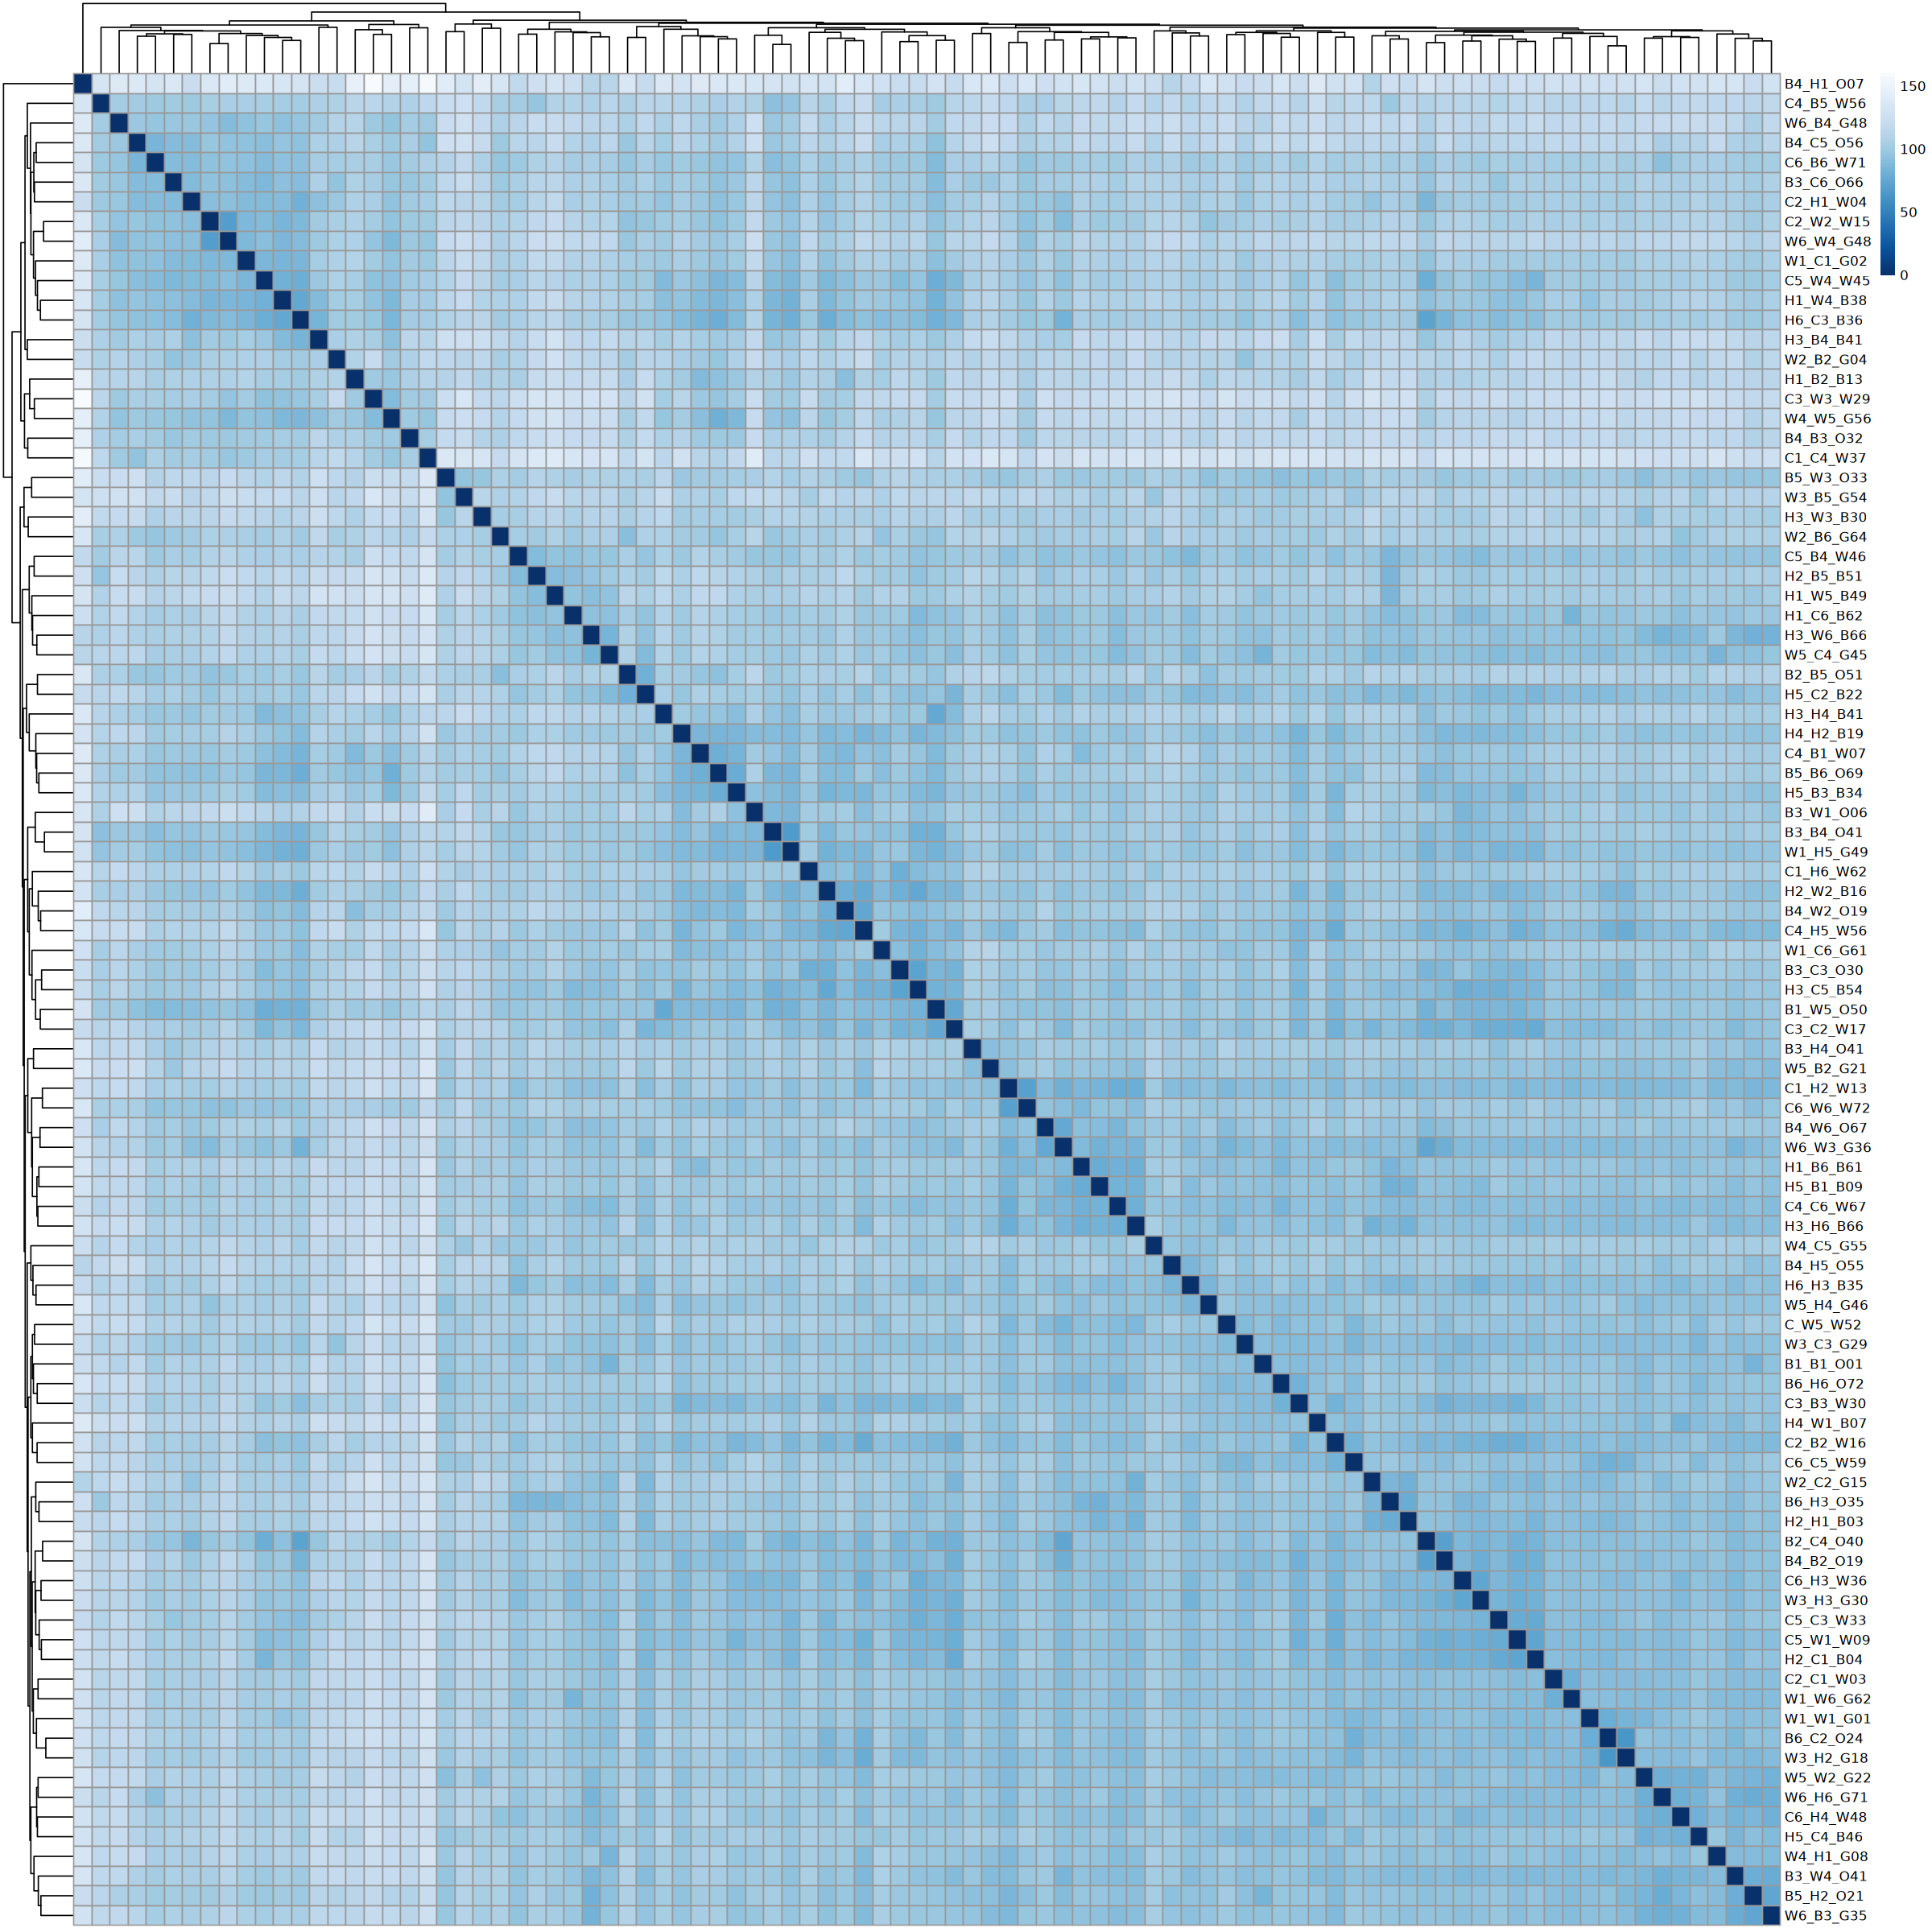

In [36]:
sampleDistMatrix <- as.matrix(sample_dists_filtered)
rownames(sampleDistMatrix) <- paste(colnames(vsd_filtered))
colnames(sampleDistMatrix) <- NULL
colors <- colorRampPalette( rev(brewer.pal(9, "Blues")) )(255)
pheatmap(sampleDistMatrix,
         clustering_distance_rows = sample_dists_filtered,
         clustering_distance_cols = sample_dists_filtered,
         col = colors)

In [38]:
pcaData_filtered <- plotPCA(vsd_filtered, intgroup = c( "Phase1_treatment", "Phase2_treatment"), returnData = TRUE)
head(pcaData_filtered)

using ntop=500 top features by variance



PC1        PC2        group        Phase1_treatment Phase2_treatment
B1_B1_O01 -14.037994  -9.929544 both:both    both             both            
B1_W5_O50  14.068852   5.334128 both:warm    both             warm            
B2_B5_O51  16.458371 -13.949316 both:both    both             both            
B2_C4_O40   3.384706   8.147616 both:control both             control         
B3_B4_O41  16.633026   7.726549 both:both    both             both            
B3_C3_O30   1.403774   7.200035 both:control both             control         
          name     
B1_B1_O01 B1_B1_O01
B1_W5_O50 B1_W5_O50
B2_B5_O51 B2_B5_O51
B2_C4_O40 B2_C4_O40
B3_B4_O41 B3_B4_O41
B3_C3_O30 B3_C3_O30

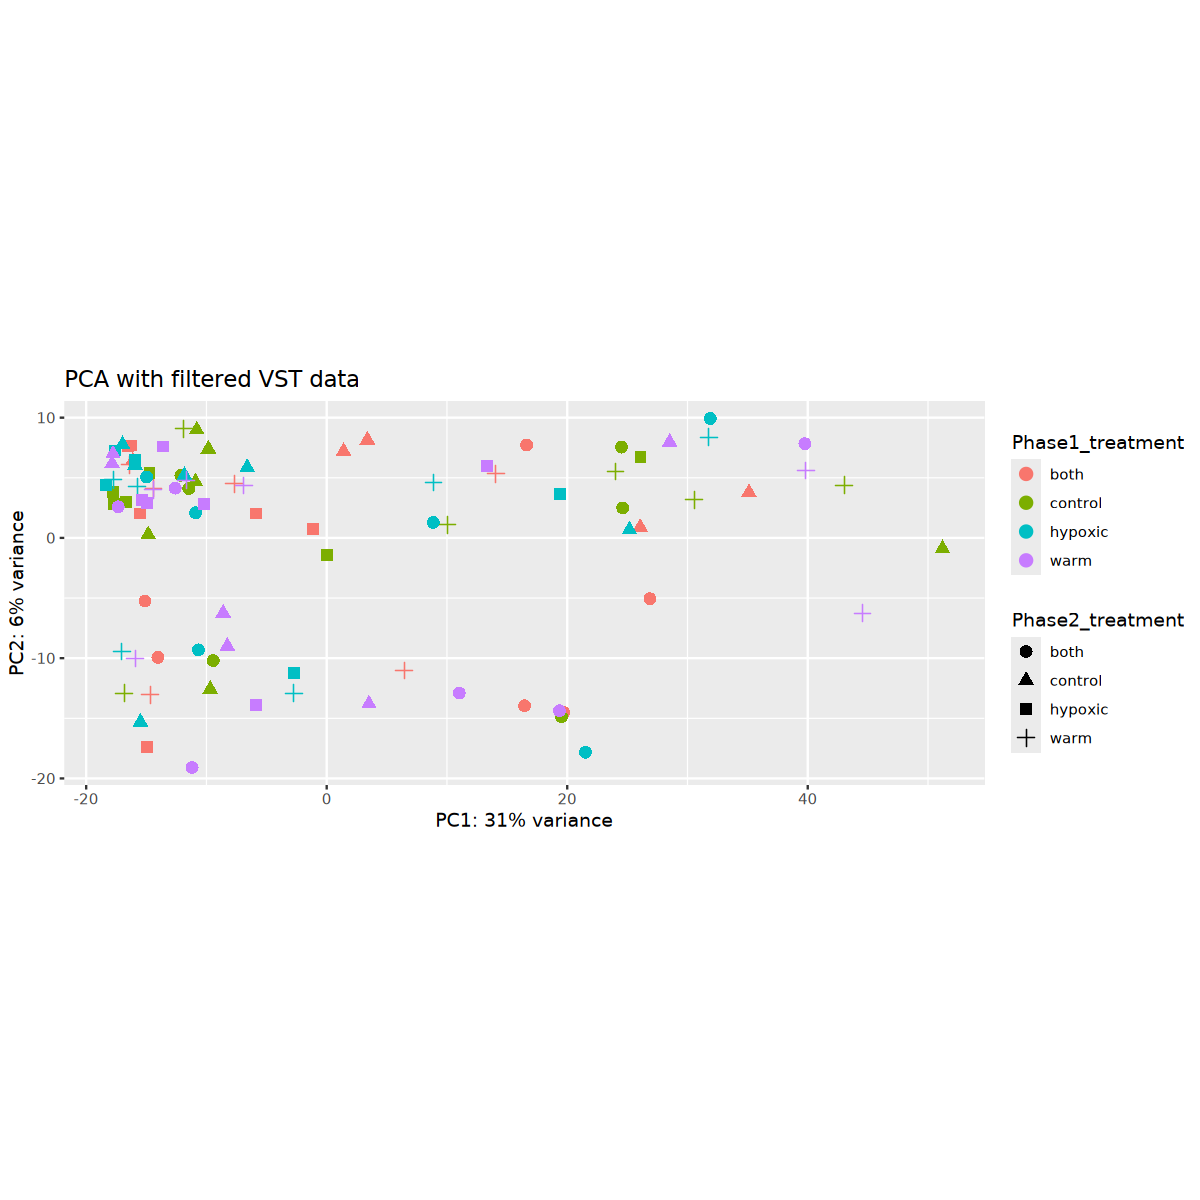

In [40]:
options(repr.plot.width=10, repr.plot.height=10)

percentVar <- round(100 * attr(pcaData_filtered, "percentVar"))

ggplot(pcaData_filtered, aes(x = PC1, y = PC2, color = Phase1_treatment, shape = Phase2_treatment)) +
  geom_point(size =3) +
  xlab(paste0("PC1: ", percentVar[1], "% variance")) +
  ylab(paste0("PC2: ", percentVar[2], "% variance")) +
  coord_fixed() +
  ggtitle("PCA with filtered VST data")

In [41]:
# calculate MDS value from distance matrix
mdsData_filtered <- data.frame(cmdscale(sample_dists_filtered))
mds_filtered <- cbind(mdsData_filtered, as.data.frame(colData(vsd_filtered))) # combine with sample data
head(mds_filtered)

X1          X2          Phase1_treatment Phase1_temp Phase1_DO
B1_B1_O01  18.4782222   0.9232659 both             warm        hypoxic  
B1_W5_O50 -16.4851013  -5.5134345 both             warm        hypoxic  
B2_B5_O51 -20.4324328  13.5814187 both             warm        hypoxic  
B2_C4_O40  -2.9953080 -12.4303847 both             warm        hypoxic  
B3_B4_O41 -19.8708213  -0.4601782 both             warm        hypoxic  
B3_C3_O30  -0.4961614   1.1268402 both             warm        hypoxic  
          Phase1_TankRep Phase2_treatment Phase2_temp Phase2_DO Phase2_TankRep
B1_B1_O01 1              both             warm        hypoxic   1             
B1_W5_O50 1              warm             warm        normoxic  5             
B2_B5_O51 2              both             warm        hypoxic   5             
B2_C4_O40 2              control          ambient     normoxic  4             
B3_B4_O41 3              both             warm        hypoxic   4             
B3_C3_O30 3              control          ambient     normoxic  3             
          complete_trtmt sizeFactor
B1_B1_O01 both both      1.0714460 
B1_W5_O50 both warm      1.0125468 
B2_B5_O51 both both      1.0641357 
B2_C4_O40 both control   1.1577371 
B3_B4_O41 both both      0.8702869 
B3_C3_O30 both control   0.8565139

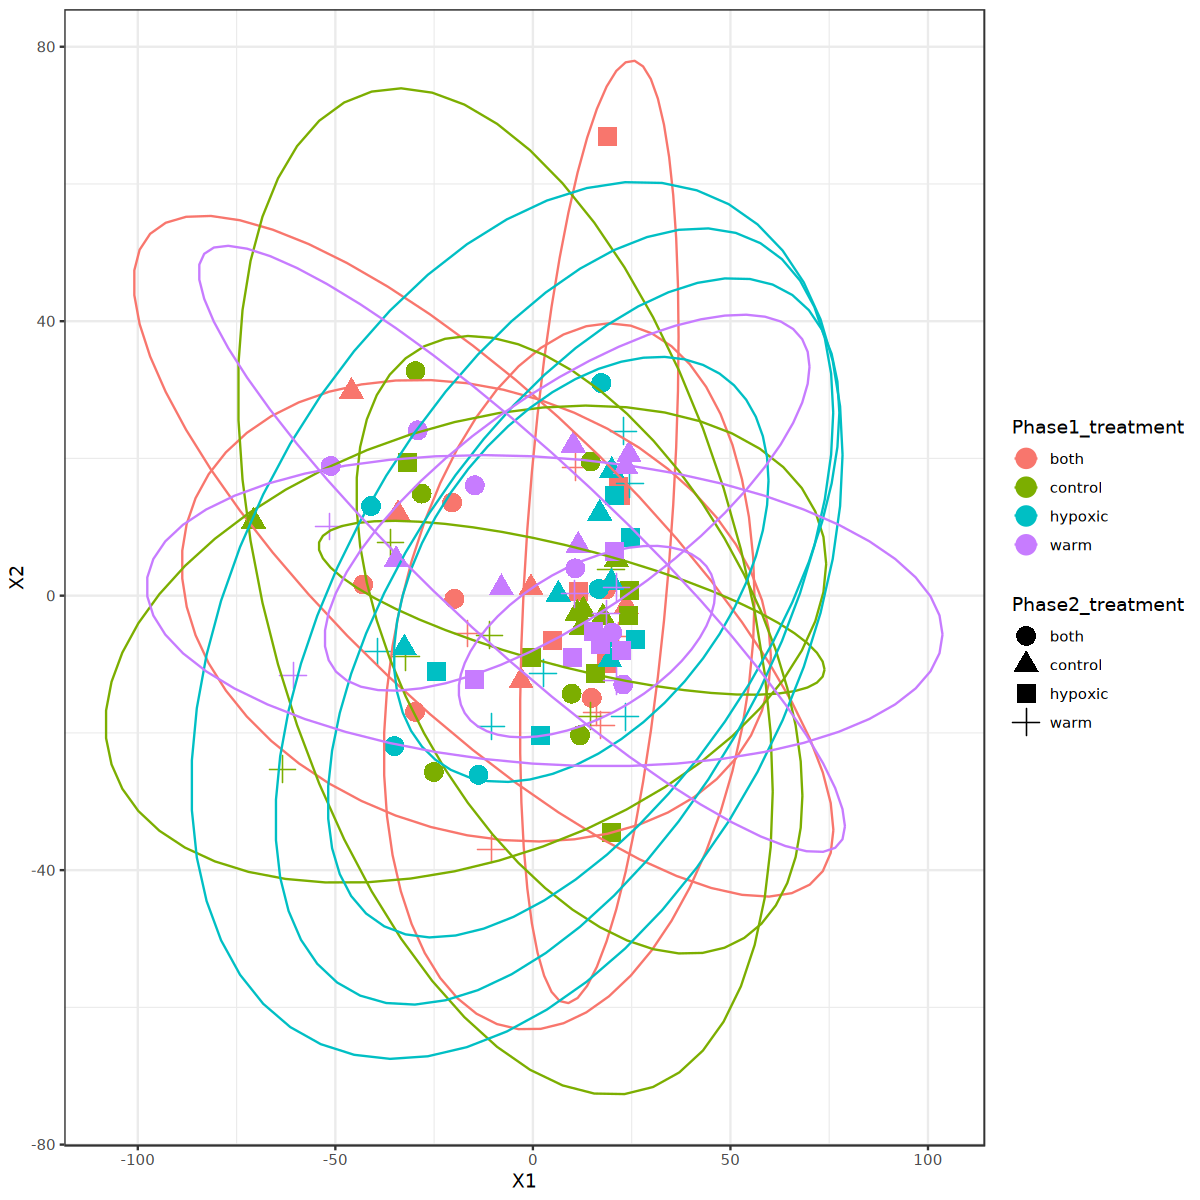

In [45]:
ggplot(mds_filtered, aes(X1, X2, col = Phase1_treatment, shape = Phase2_treatment)) +
geom_point(size = 5) +
stat_ellipse() + 
theme_bw()

okay so it appears when we remove those two seemingly outlier samples, the data gets a little bit 'more clear' and replicates segregate a little better

let's remove those samples (**B5_C1_O09** and **H2_H5_B51**) and re-run DESeq2

## remove outliers, run DESeq again

In [19]:
# remove outliers from filtered counts matrix
counts_noOutliers <- counts.filtered %>%
select(-c(B5_C1_O09, H2_H5_B51))

# remove from meta 
meta_noOutliers <- meta[rownames(meta) %in% colnames(counts_noOutliers),]

# check dimensions - should have same number of samples (94)
dim(meta_noOutliers)
dim(counts_noOutliers)

# check samples are in the same order
all(rownames(meta_noOutliers) == colnames(counts_noOutliers))

[1] 94  9

[1] 35466    94

[1] TRUE

In [12]:
# creating DESeq2 object
dds.noOutliers <- DESeqDataSetFromMatrix(countData = counts_noOutliers,
                              colData = meta_noOutliers,
                              design = ~ complete_trtmt)
dds.noOutliers

# running DESeq
dds.noOutliers <- DESeq(dds.noOutliers)

# list coefficients
resultsNames(dds.noOutliers)

Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”
  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]



class: DESeqDataSet 
dim: 35466 94 
metadata(1): version
assays(1): counts
rownames(35466): LOC111116054 LOC111126949 ... ND1 ND4L
rowData names(0):
colnames(94): B1_B1_O01 B1_W5_O50 ... W6_W3_G36 W6_W4_G48
colData names(9): Phase1_treatment Phase1_temp ... Phase2_TankRep
  complete_trtmt

estimating size factors

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

  Note: levels of factors in the design contain characters other than
  letters, numbers, '_' and '.'. It is recommended (but not required) to use
  only letters, numbers, and delimiters '_' or '.', as these are safe characters
  for column names in R. [This is a message, not a warning or an error]

final dispersion estimates

fitting model and testing



[1] "Intercept"                                  
 [2] "complete_trtmt_both.control_vs_both.both"   
 [3] "complete_trtmt_both.hypoxic_vs_both.both"   
 [4] "complete_trtmt_both.warm_vs_both.both"      
 [5] "complete_trtmt_control.both_vs_both.both"   
 [6] "complete_trtmt_control.control_vs_both.both"
 [7] "complete_trtmt_control.hypoxic_vs_both.both"
 [8] "complete_trtmt_control.warm_vs_both.both"   
 [9] "complete_trtmt_hypoxic.both_vs_both.both"   
[10] "complete_trtmt_hypoxic.control_vs_both.both"
[11] "complete_trtmt_hypoxic.hypoxic_vs_both.both"
[12] "complete_trtmt_hypoxic.warm_vs_both.both"   
[13] "complete_trtmt_warm.both_vs_both.both"      
[14] "complete_trtmt_warm.control_vs_both.both"   
[15] "complete_trtmt_warm.hypoxic_vs_both.both"   
[16] "complete_trtmt_warm.warm_vs_both.both"

## nMDS
normalize and transform DESeq object using vst (variance stabilized expression matrix)

In [13]:
# variance stabilizing transformation
vsd <- vst(dds.noOutliers)
head(assay(vsd))

B1_B1_O01 B1_W5_O50 B2_B5_O51 B2_C4_O40 B3_B4_O41 B3_C3_O30
LOC111116054  7.692872 7.805746  7.871959  7.843091  7.548551  7.909124 
LOC111126949 10.197580 9.653169  9.900281  9.718856  9.612738  9.545333 
LOC111110729  8.354765 8.542687  8.351593  8.513945  8.518601  8.653091 
LOC111112434  7.886383 7.697174  7.548551  7.687586  7.940109  7.989592 
LOC111120752  9.363550 9.355360  9.509373  9.284512  9.198871  9.337765 
LOC111128944  7.548551 7.548551  7.548551  7.548551  7.548551  7.548551 
             B3_C6_O66 B3_H4_O41 B3_W1_O06 B3_W4_O41 ⋯ W4_W5_G56 W5_B2_G21
LOC111116054 7.947895  7.869635  7.840134  7.758281  ⋯ 7.767900  7.713596 
LOC111126949 9.334530  9.803992  9.906070  9.592360  ⋯ 9.078093  9.779869 
LOC111110729 8.816678  8.937210  8.568640  8.590933  ⋯ 8.714150  8.368627 
LOC111112434 7.818256  8.186828  7.658920  7.879728  ⋯ 7.817069  7.548551 
LOC111120752 9.699834  9.473806  8.989457  9.167603  ⋯ 9.549481  9.234610 
LOC111128944 7.548551  7.548551  7.548551  7.548551  ⋯ 7.548551  7.548551 
             W5_C4_G45 W5_H4_G46 W5_W2_G22 W6_B3_G35 W6_B4_G48 W6_H6_G71
LOC111116054 7.900466   7.697844 7.834121  7.790482  7.708399  8.030152 
LOC111126949 9.712370  10.082883 9.950378  9.563392  9.665533  9.644851 
LOC111110729 8.514299   8.798284 8.635108  8.680883  8.780214  8.673395 
LOC111112434 7.937395   7.806904 7.750644  7.548551  7.708399  7.990820 
LOC111120752 9.599548   9.383933 9.510347  9.253648  9.345876  9.627837 
LOC111128944 7.548551   7.548551 7.548551  7.548551  7.548551  7.548551 
             W6_W3_G36 W6_W4_G48
LOC111116054 7.657898  7.548551 
LOC111126949 9.276775  9.929224 
LOC111110729 8.746416  9.064164 
LOC111112434 7.857315  7.548551 
LOC111120752 9.412129  9.619853 
LOC111128944 7.548551  7.548551

In [14]:
# calculate sample distances
sample_dists <- assay(vsd) %>%
t() %>%
dist() %>%
as.matrix()

head(sample_dists)

# calculate MDS value from distance matrix
mdsData <- data.frame(cmdscale(sample_dists))
mds <- cbind(mdsData, as.data.frame(colData(vsd))) # combine with sample data
head(mds)

B1_B1_O01 B1_W5_O50 B2_B5_O51 B2_C4_O40 B3_B4_O41 B3_C3_O30 B3_C6_O66
B1_B1_O01   0.0000  116.94182 119.4656  111.77080 119.31504 117.48092 127.2079 
B1_W5_O50 116.9418    0.00000 113.4067   96.30113  95.84683 100.98441 105.1055 
B2_B5_O51 119.4656  113.40668   0.0000  120.06158 115.89126 122.54447 116.8186 
B2_C4_O40 111.7708   96.30113 120.0616    0.00000 102.80162  99.39888 112.2918 
B3_B4_O41 119.3150   95.84683 115.8913  102.80162   0.00000 109.42665 111.8600 
B3_C3_O30 117.4809  100.98441 122.5445   99.39888 109.42665   0.00000 118.3574 
          B3_H4_O41 B3_W1_O06 B3_W4_O41 ⋯ W4_W5_G56 W5_B2_G21 W5_C4_G45
B1_B1_O01 120.4473  118.6316  109.6003  ⋯ 135.4683  114.9312   98.66477
B1_W5_O50 117.6363  109.9267  110.0015  ⋯ 112.1678  121.4096  114.35939
B2_B5_O51 130.1508  132.6363  127.5096  ⋯ 121.1887  133.6478  126.20789
B2_C4_O40 115.3401  116.5576  104.5292  ⋯ 118.1757  114.9910  111.42103
B3_B4_O41 123.7552  100.9498  115.9806  ⋯ 110.6503  124.7410  116.37281
B3_C3_O30 123.9370  119.1473  115.7604  ⋯ 124.8772  123.0274  111.98186
          W5_H4_G46 W5_W2_G22 W6_B3_G35 W6_B4_G48 W6_H6_G71 W6_W3_G36 W6_W4_G48
B1_B1_O01 108.3115  105.2991  109.8200  128.0896  112.1680  108.10270 133.9631 
B1_W5_O50 115.4506  115.7944  114.5743  117.9029  114.7973  107.98541 112.9742 
B2_B5_O51 108.8192  122.8631  127.5355  123.6402  127.4847  120.69298 113.2608 
B2_C4_O40 112.1850  110.8497  110.6068  125.0513  109.1598   87.87814 120.2714 
B3_B4_O41 117.9745  121.8056  119.5935  113.8767  119.2667  112.63087 113.4405 
B3_C3_O30 119.1198  118.9319  116.1404  130.2506  112.1100  112.27069 127.2444

X1          X2        Phase1_treatment Phase1_temp Phase1_DO
B1_B1_O01  21.3611417  11.85421 both             warm        hypoxic  
B1_W5_O50 -19.6550586 -19.25821 both             warm        hypoxic  
B2_B5_O51 -24.2408970  27.20443 both             warm        hypoxic  
B2_C4_O40  -4.3298701 -23.47074 both             warm        hypoxic  
B3_B4_O41 -23.4268337 -14.52894 both             warm        hypoxic  
B3_C3_O30  -0.6273476 -21.27774 both             warm        hypoxic  
          Phase1_TankRep Phase2_treatment Phase2_temp Phase2_DO Phase2_TankRep
B1_B1_O01 1              both             warm        hypoxic   1             
B1_W5_O50 1              warm             warm        normoxic  5             
B2_B5_O51 2              both             warm        hypoxic   5             
B2_C4_O40 2              control          ambient     normoxic  4             
B3_B4_O41 3              both             warm        hypoxic   4             
B3_C3_O30 3              control          ambient     normoxic  3             
          complete_trtmt sizeFactor
B1_B1_O01 both both      1.0666333 
B1_W5_O50 both warm      1.0057329 
B2_B5_O51 both both      1.0584922 
B2_C4_O40 both control   1.1493541 
B3_B4_O41 both both      0.8648335 
B3_C3_O30 both control   0.8506698

In [21]:
mds$Phase1_treatment <- factor(mds$Phase1_treatment, levels = c('control', 'warm', 'hypoxic', 'both'))

mds$Phase2_treatment <- factor(mds$Phase2_treatment, levels = c('control', 'warm', 'hypoxic', 'both'))

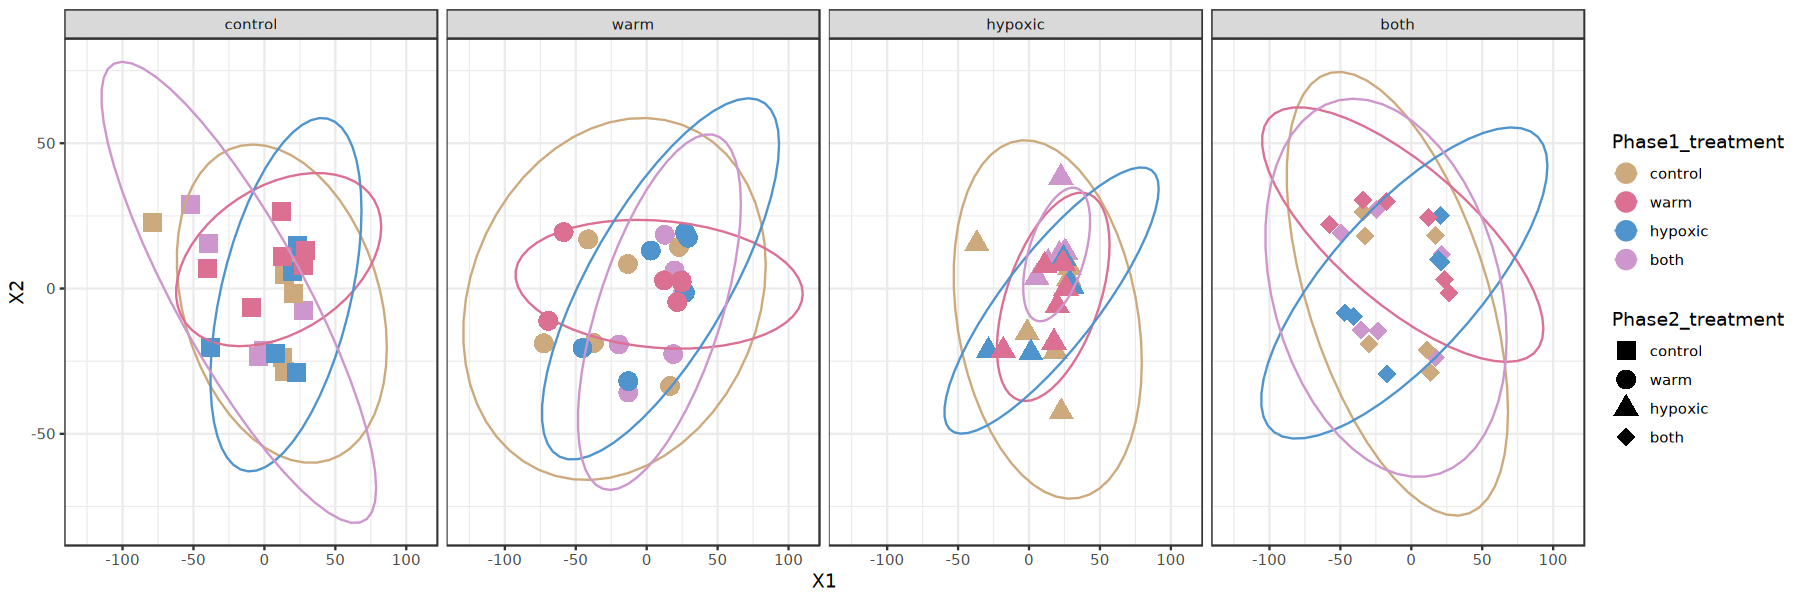

In [29]:
options(repr.plot.width = 15, repr.plot.height = 5)

nmds.plot <- ggplot(mds, aes(X1, X2, col = Phase1_treatment, shape = Phase2_treatment)) +
geom_point(size = 5) +
facet_wrap(~Phase2_treatment, nrow=1) + 
stat_ellipse() + 
scale_shape_manual(values=c(15, 16, 17, 18)) +
scale_color_manual(values = c("hypoxic" = "steelblue3", "warm" = "palevioletred", "control" = "burlywood3", "both" = "plum3")) +
theme_bw()

nmds.plot

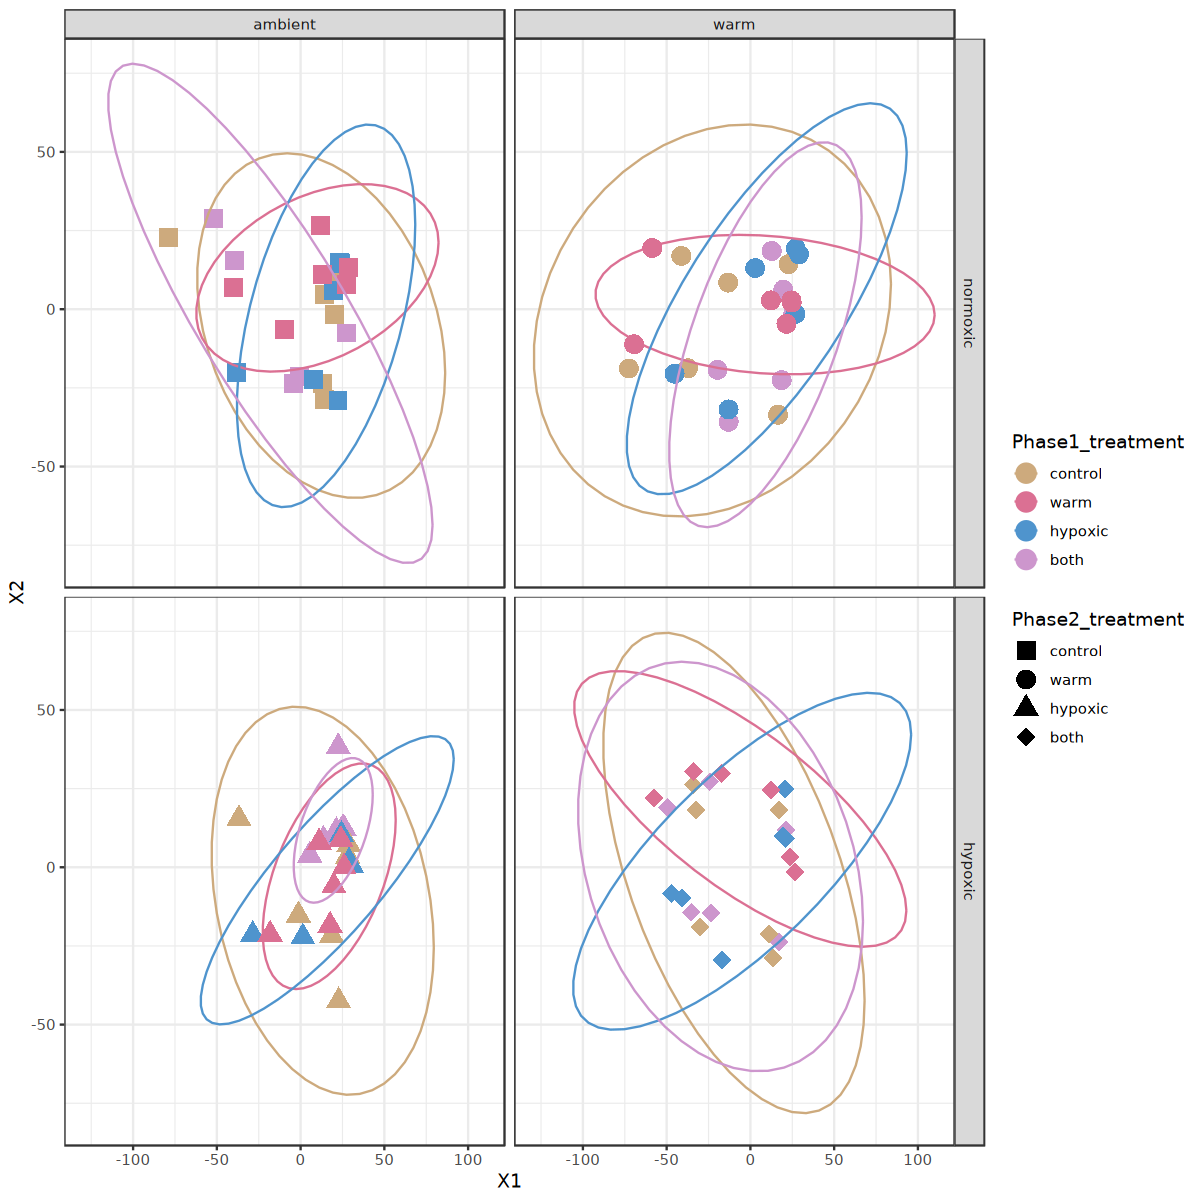

In [34]:
options(repr.plot.width = 10, repr.plot.height = 10)

nmds.plot <- ggplot(mds, aes(X1, X2, col = Phase1_treatment, shape = Phase2_treatment)) +
geom_point(size = 5) +
facet_grid(Phase2_DO~Phase2_temp) + 
stat_ellipse() + 
scale_shape_manual(values=c(15, 16, 17, 18)) +
scale_color_manual(values = c("hypoxic" = "steelblue3", "warm" = "palevioletred", "control" = "burlywood3", "both" = "plum3")) +
theme_bw()

nmds.plot

## permANOVA

In [99]:
adonis2(sample_dists ~ Phase1_temp * Phase1_DO * Phase2_temp * Phase2_DO, data = meta_noOutliers, permutations = 999)

Df SumOfSqs   R2          F        
Phase1_temp                                  1   6764.111 0.010229863 0.9590221
Phase1_DO                                    1   5873.615 0.008883100 0.8327667
Phase2_temp                                  1  14585.723 0.022059062 2.0679777
Phase2_DO                                    1   9469.499 0.014321419 1.3425945
Phase1_temp:Phase1_DO                        1   5468.417 0.008270289 0.7753173
Phase1_temp:Phase2_temp                      1   5593.227 0.008459049 0.7930131
Phase1_DO:Phase2_temp                        1   5740.553 0.008681861 0.8139011
Phase1_temp:Phase2_DO                        1   5761.321 0.008713270 0.8168456
Phase1_DO:Phase2_DO                          1   7533.049 0.011392784 1.0680429
Phase2_temp:Phase2_DO                        1  10094.721 0.015266988 1.4312391
Phase1_temp:Phase1_DO:Phase2_temp            1   6990.278 0.010571912 0.9910883
Phase1_temp:Phase1_DO:Phase2_DO              1   5894.473 0.008914645 0.8357240
Phase1_temp:Phase2_temp:Phase2_DO            1   6840.250 0.010345014 0.9698172
Phase1_DO:Phase2_temp:Phase2_DO              1   8599.992 0.013006401 1.2193151
Phase1_temp:Phase1_DO:Phase2_temp:Phase2_DO  1   5858.650 0.008860467 0.8306450
Residual                                    78 550144.426 0.832023876        NA
Total                                       93 661212.306 1.000000000        NA
                                            Pr(>F)
Phase1_temp                                 0.508 
Phase1_DO                                   0.837 
Phase2_temp                                 0.004 
Phase2_DO                                   0.057 
Phase1_temp:Phase1_DO                       0.933 
Phase1_temp:Phase2_temp                     0.925 
Phase1_DO:Phase2_temp                       0.862 
Phase1_temp:Phase2_DO                       0.864 
Phase1_DO:Phase2_DO                         0.262 
Phase2_temp:Phase2_DO                       0.030 
Phase1_temp:Phase1_DO:Phase2_temp           0.452 
Phase1_temp:Phase1_DO:Phase2_DO             0.841 
Phase1_temp:Phase2_temp:Phase2_DO           0.494 
Phase1_DO:Phase2_temp:Phase2_DO             0.106 
Phase1_temp:Phase1_DO:Phase2_temp:Phase2_DO 0.848 
Residual                                       NA 
Total                                          NA

## heatmap 
of sample-to-sample distances using the variance stabilizing transformed values


following [RNA-seq workflow](https://master.bioconductor.org/packages/release/workflows/vignettes/rnaseqGene/inst/doc/rnaseqGene.html) from Mike Love

In [105]:
# normalization & transformation
vsd <- vst(dds.noOutliers)

# calculate sample distances
sample_dists <- dist(t(assay(vsd)))
head(sample_dists)

[1] 116.9418 119.4656 111.7708 119.3150 117.4809 127.2079

In [106]:
head(vsd)

class: DESeqTransform 
dim: 6 94 
metadata(1): version
assays(1): ''
rownames(6): LOC111116054 LOC111126949 ... LOC111120752 LOC111128944
rowData names(78): baseMean baseVar ... maxCooks dispFit
colnames(94): B1_B1_O01 B1_W5_O50 ... W6_W3_G36 W6_W4_G48
colData names(10): Phase1_treatment Phase1_temp ... complete_trtmt
  sizeFactor

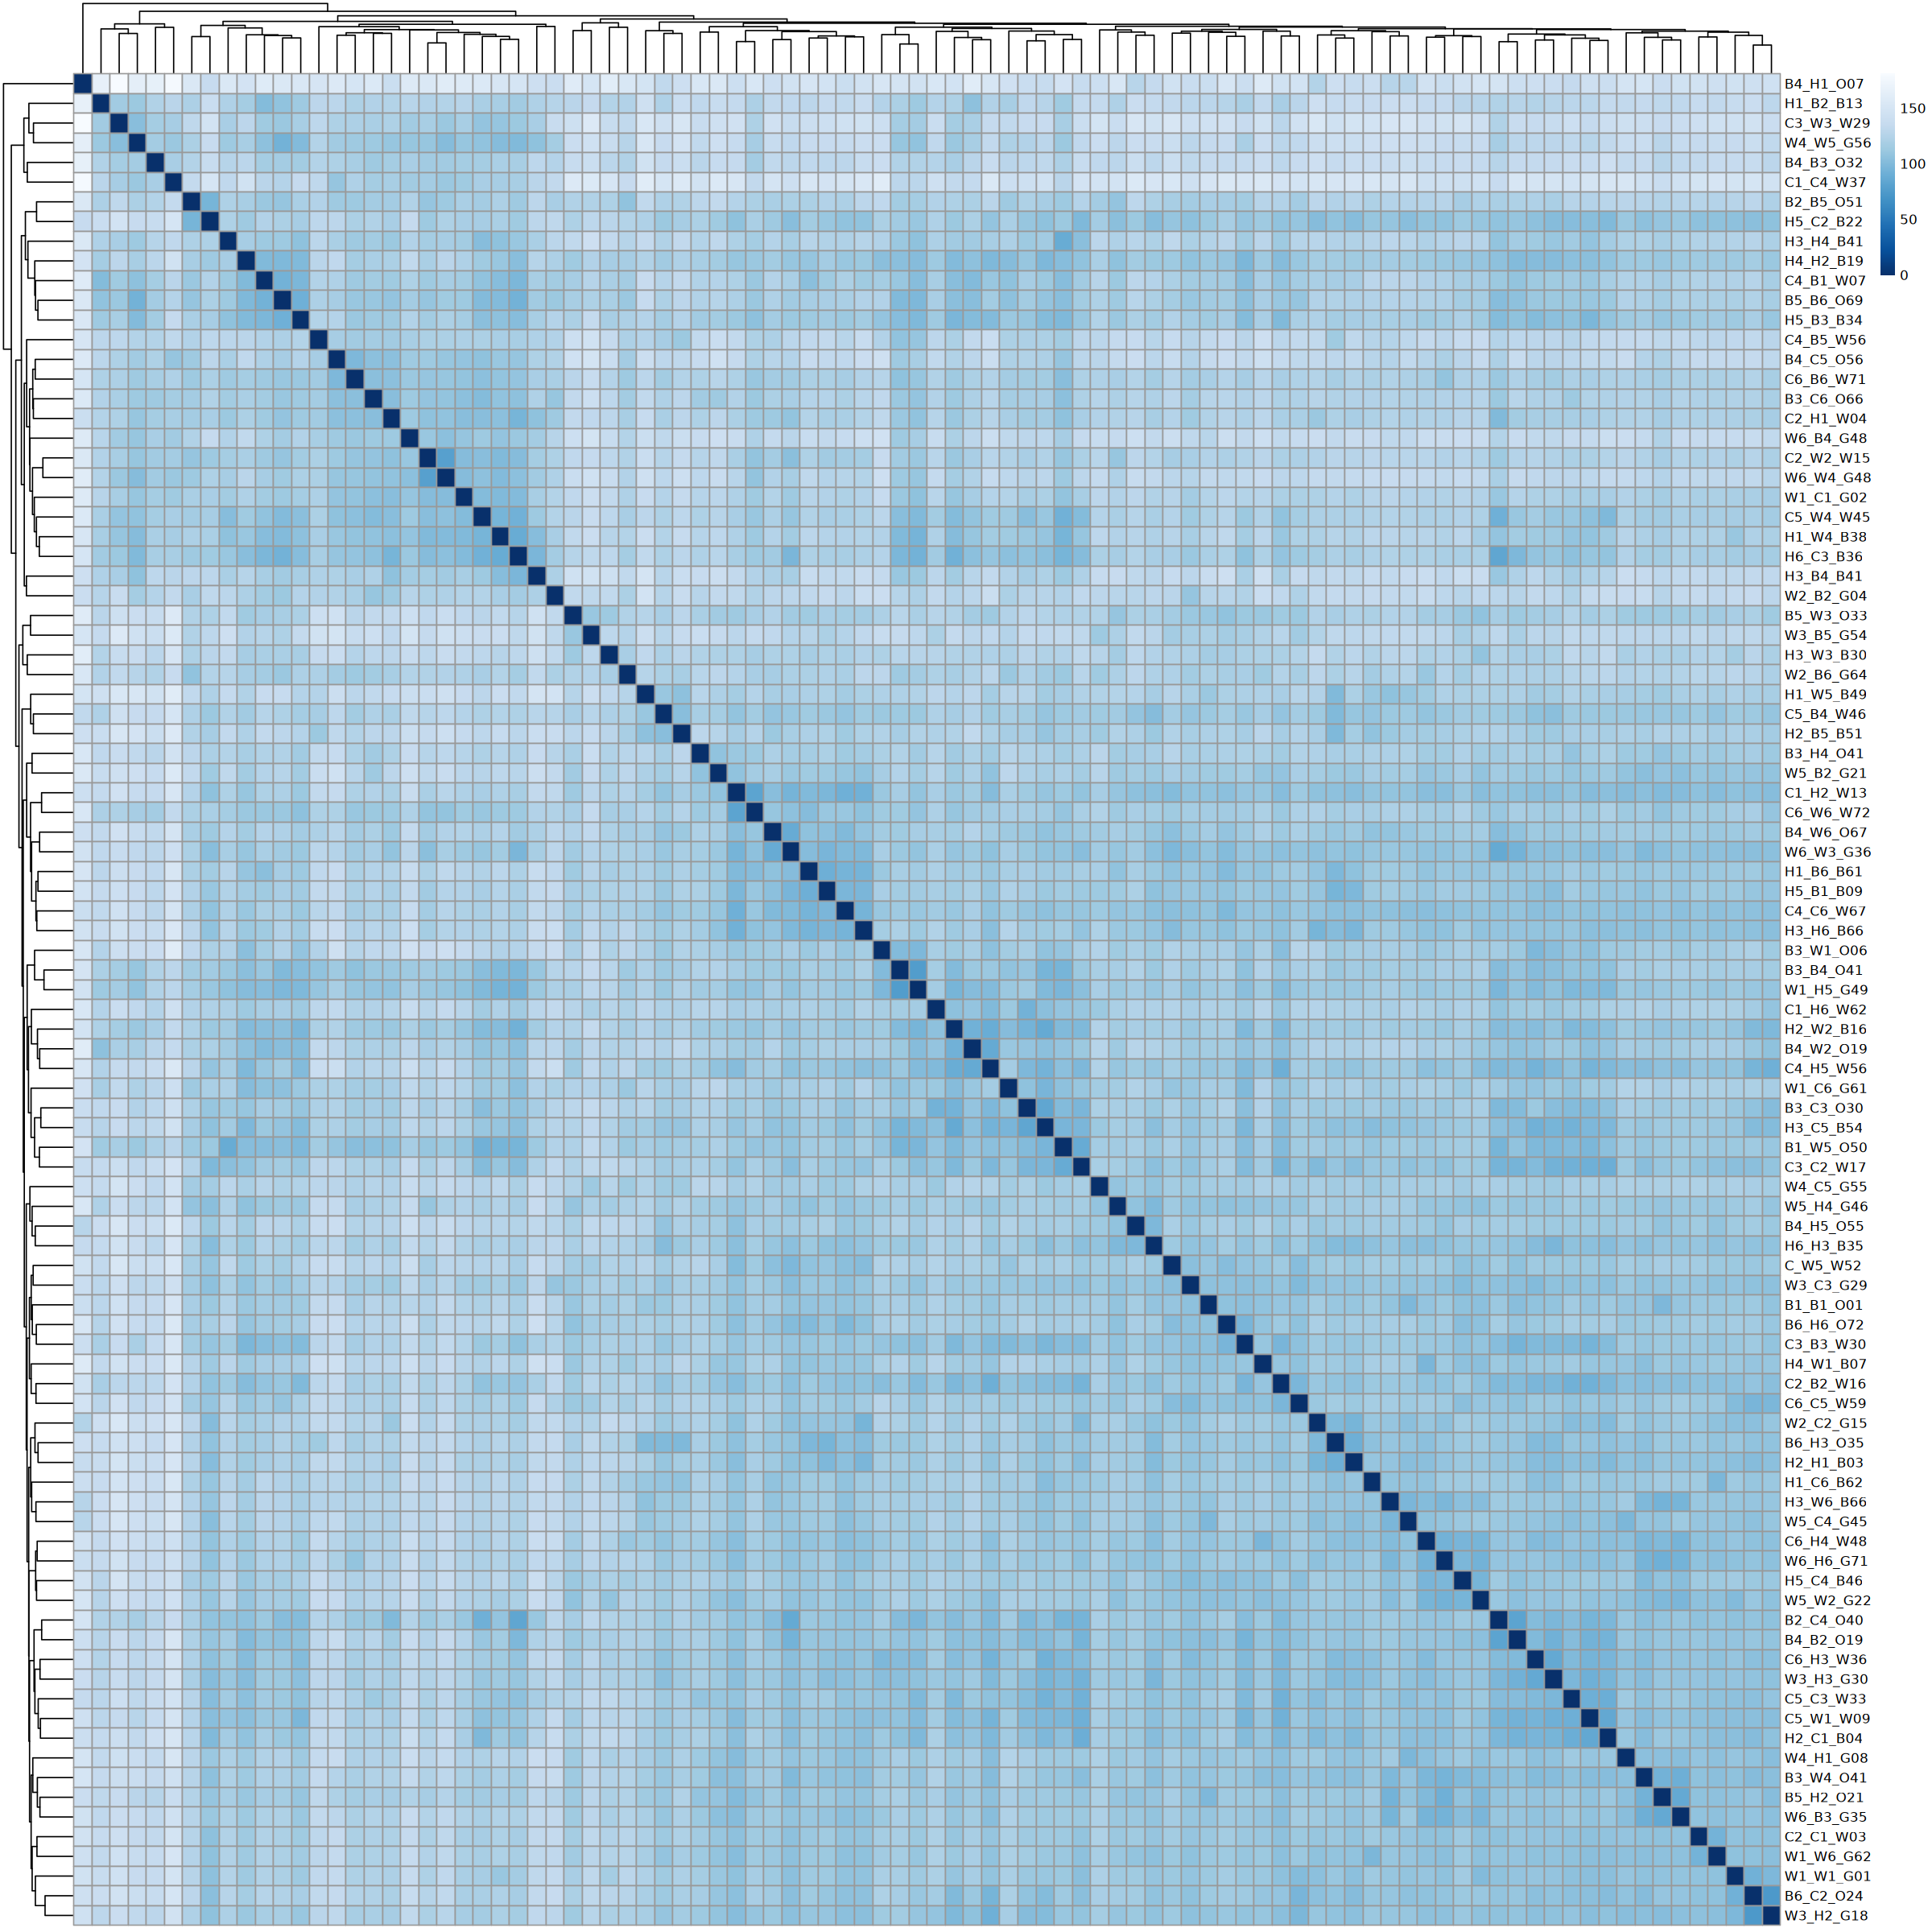

In [107]:
options(repr.plot.width=20, repr.plot.height=20)

sampleDistMatrix <- as.matrix(sample_dists)
rownames(sampleDistMatrix) <- paste(colnames(vsd))
colnames(sampleDistMatrix) <- NULL
colors <- colorRampPalette( rev(brewer.pal(9, "Blues")) )(255)
pheatmap(sampleDistMatrix,
         clustering_distance_rows = sample_dists,
         clustering_distance_cols = sample_dists,
         col = colors)

## Pairwise comparisons

### 1. Effect of single exposure on GE after a period of recovery
- CC vs. WC
- CC vs. HC
- CC vs. BC

**CC vs. WC**

using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041

computing FSOS 'false sign or small' s-values (T=1)




out of 35396 with nonzero total read count
s-value < 0.005
LFC > 1.00 (up)    : 41, 0.12%
LFC < -1.00 (down) : 49, 0.14%



Gene         baseMean    log2FoldChange lfcSE       stat        pvalue   
1 LOC111116054   9.0629842  1.684013e-04  0.018305639  0.44047770 0.6595912
2 LOC111126949 539.2853993 -1.510958e-05  0.007741036 -0.09086219 0.9276021
3 LOC111110729 114.0070007  9.793524e-05  0.006851507  0.55548287 0.5785644
4 LOC111112434   6.9517032 -2.714075e-04  0.028635977 -0.40259431 0.6872467
5 LOC111120752 429.0263780 -2.276593e-04  0.009449425 -1.11800790 0.2635636
6 LOC111128944   0.1088474  0.000000e+00  0.337332140  0.00000000 1.0000000
  padj svalue    B1_B1_O01  B1_W5_O50  ⋯ W4_W5_G56  W5_B2_G21  W5_C4_G45
1  1   0.9899086   1.875059   5.965799 ⋯   4.336105   2.452846  11.19491
2  1   0.9930892 829.713451 474.281013 ⋯ 230.897604 544.531781 506.25864
3  1   0.9936909  60.001877  92.469883 ⋯ 128.999131  62.138762  87.07151
4  1   0.9881456  10.312823   1.988600 ⋯   6.504158   0.000000  13.68267
5  1   0.9926109 337.510556 334.084739 ⋯ 421.686235 286.165350 446.55246
6 NA   0.9612649   0.000000   0.000000 ⋯   0.000000   0.000000   0.00000
  W5_H4_G46  W5_W2_G22  W6_B3_G35  W6_B4_G48  W6_H6_G71 W6_W3_G36  W6_W4_G48
1   2.006592   7.359253   5.277065   2.300668  21.05700   1.075999   0.0000 
2 742.439160 650.373981 428.497663 480.839693 469.90350 302.355713 636.4963 
3 149.491128 111.308701 121.372491 144.942108 119.69240 136.651870 226.3334 
4   6.019777   3.679626   0.000000   2.300668  17.73221   8.607992   0.0000 
5 346.137176 402.919100 293.404804 330.145914 461.03739 358.307660 456.9172 
6   0.000000   0.000000   0.000000   0.000000   0.00000   0.000000   0.0000

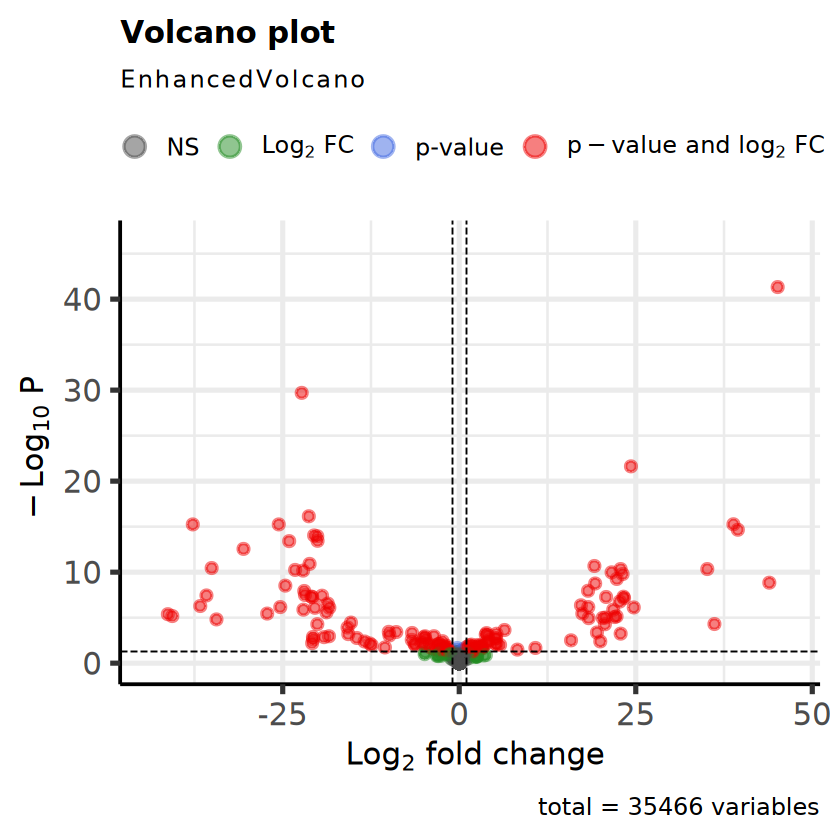

In [23]:
res.wc.cc <- lfcShrink(dds.noOutliers, 
                       contrast= c('complete_trtmt', 'warm.control', 'control.control'), # CC is the "control"
                     type = 'ashr',
                      lfcThreshold = 1)

summary(res.wc.cc)

EnhancedVolcano(res.wc.cc,
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

res.wc.cc <- merge(res.wc.cc, counts(dds.noOutliers, normalized=TRUE), by="row.names", sort=FALSE) # add normalized counts to DESeq results
names(res.wc.cc)[1] <- 'Gene'

head(res.wc.cc)

In [24]:
write.csv(res.wc.cc, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_res_files/all_genes/wc_cc.csv', row.names = FALSE)

**CC vs. HC**

using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041

computing FSOS 'false sign or small' s-values (T=1)




out of 35396 with nonzero total read count
s-value < 0.005
LFC > 1.00 (up)    : 36, 0.1%
LFC < -1.00 (down) : 98, 0.28%



Gene         baseMean    log2FoldChange lfcSE       stat         pvalue   
1 LOC111116054   9.0629842 -5.726338e-05  0.014260362 -0.221443616 0.8247470
2 LOC111126949 539.2853993  2.415433e-07  0.007379312  0.001592433 0.9987294
3 LOC111110729 114.0070007  2.934917e-05  0.006610421  0.167773839 0.8667612
4 LOC111112434   6.9517032  5.115051e-05  0.021328732  0.119392271 0.9049646
5 LOC111120752 429.0263780 -1.394489e-04  0.007567354 -0.806698158 0.4198404
6 LOC111128944   0.1088474  0.000000e+00  0.386472416  0.000000000 1.0000000
  padj svalue    B1_B1_O01  B1_W5_O50  ⋯ W4_W5_G56  W5_B2_G21  W5_C4_G45
1  1   0.9884238   1.875059   5.965799 ⋯   4.336105   2.452846  11.19491
2  1   0.9917271 829.713451 474.281013 ⋯ 230.897604 544.531781 506.25864
3  1   0.9926428  60.001877  92.469883 ⋯ 128.999131  62.138762  87.07151
4  1   0.9870052  10.312823   1.988600 ⋯   6.504158   0.000000  13.68267
5  1   0.9915841 337.510556 334.084739 ⋯ 421.686235 286.165350 446.55246
6 NA   0.9442207   0.000000   0.000000 ⋯   0.000000   0.000000   0.00000
  W5_H4_G46  W5_W2_G22  W6_B3_G35  W6_B4_G48  W6_H6_G71 W6_W3_G36  W6_W4_G48
1   2.006592   7.359253   5.277065   2.300668  21.05700   1.075999   0.0000 
2 742.439160 650.373981 428.497663 480.839693 469.90350 302.355713 636.4963 
3 149.491128 111.308701 121.372491 144.942108 119.69240 136.651870 226.3334 
4   6.019777   3.679626   0.000000   2.300668  17.73221   8.607992   0.0000 
5 346.137176 402.919100 293.404804 330.145914 461.03739 358.307660 456.9172 
6   0.000000   0.000000   0.000000   0.000000   0.00000   0.000000   0.0000

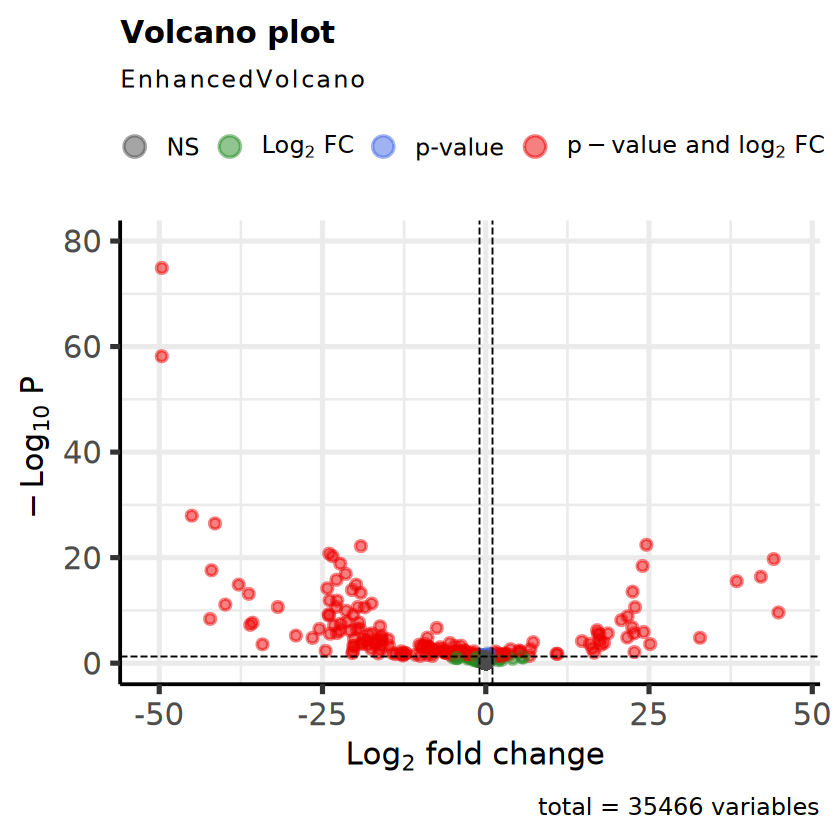

In [27]:
res.hc.cc <- lfcShrink(dds.noOutliers, contrast= c('complete_trtmt', 'hypoxic.control', 'control.control'), # CC is the "control"
                     type = 'ashr',
                      lfcThreshold = 1)

summary(res.hc.cc)

EnhancedVolcano(res.hc.cc,
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

res.hc.cc <- merge(res.hc.cc, counts(dds.noOutliers, normalized=TRUE), by="row.names", sort=FALSE) # add normalized counts to DESeq results
names(res.hc.cc)[1] <- 'Gene'

head(res.hc.cc)

In [28]:
write.csv(res.hc.cc, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_res_files/all_genes/hc_cc.csv', row.names = FALSE)

**CC vs. BC**

using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041

computing FSOS 'false sign or small' s-values (T=1)




out of 35396 with nonzero total read count
s-value < 0.005
LFC > 1.00 (up)    : 37, 0.1%
LFC < -1.00 (down) : 146, 0.41%



Gene         baseMean    log2FoldChange lfcSE       stat       pvalue    padj
1 LOC111116054   9.0629842 -7.848177e-05  0.017034682 -0.2239960 0.8227604 1   
2 LOC111126949 539.2853993  7.281688e-05  0.008201698  0.4440357 0.6570168 1   
3 LOC111110729 114.0070007  5.403266e-05  0.006594906  0.3312989 0.7404187 1   
4 LOC111112434   6.9517032 -1.783508e-04  0.027504387 -0.2802909 0.7792543 1   
5 LOC111120752 429.0263780 -2.543452e-04  0.010259983 -1.2400538 0.2149555 1   
6 LOC111128944   0.1088474  0.000000e+00  0.467802937  0.0000000 1.0000000 1   
  svalue    B1_B1_O01  B1_W5_O50  ⋯ W4_W5_G56  W5_B2_G21  W5_C4_G45 W5_H4_G46 
1 0.9853845   1.875059   5.965799 ⋯   4.336105   2.452846  11.19491   2.006592
2 0.9889234 829.713451 474.281013 ⋯ 230.897604 544.531781 506.25864 742.439160
3 0.9906323  60.001877  92.469883 ⋯ 128.999131  62.138762  87.07151 149.491128
4 0.9825589  10.312823   1.988600 ⋯   6.504158   0.000000  13.68267   6.019777
5 0.9883526 337.510556 334.084739 ⋯ 421.686235 286.165350 446.55246 346.137176
6 0.9289564   0.000000   0.000000 ⋯   0.000000   0.000000   0.00000   0.000000
  W5_W2_G22  W6_B3_G35  W6_B4_G48  W6_H6_G71 W6_W3_G36  W6_W4_G48
1   7.359253   5.277065   2.300668  21.05700   1.075999   0.0000 
2 650.373981 428.497663 480.839693 469.90350 302.355713 636.4963 
3 111.308701 121.372491 144.942108 119.69240 136.651870 226.3334 
4   3.679626   0.000000   2.300668  17.73221   8.607992   0.0000 
5 402.919100 293.404804 330.145914 461.03739 358.307660 456.9172 
6   0.000000   0.000000   0.000000   0.00000   0.000000   0.0000

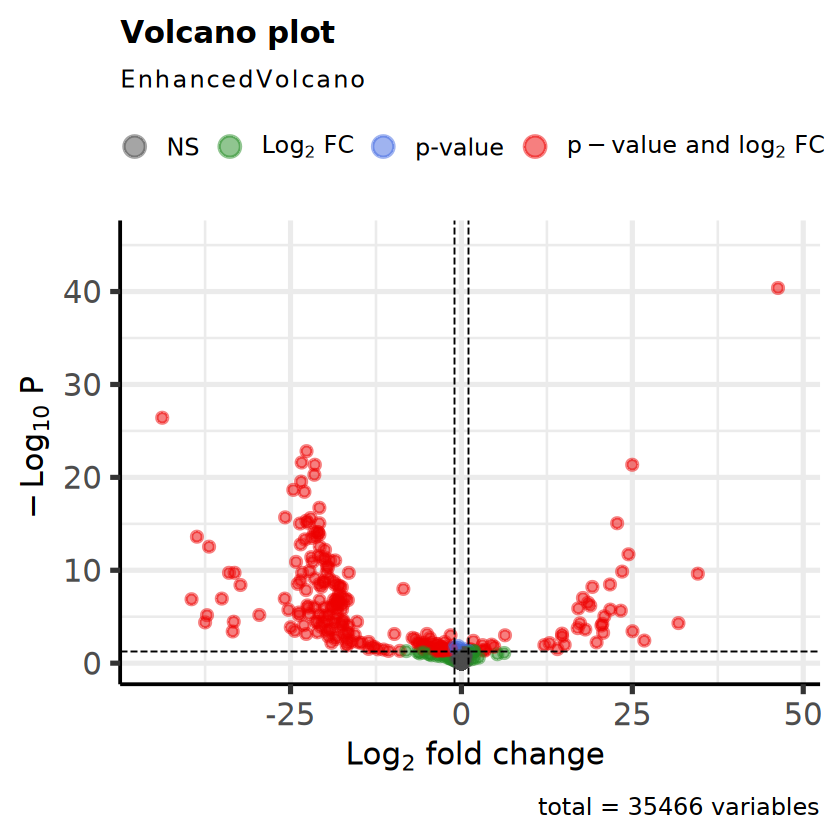

In [29]:
res.bc.cc <- lfcShrink(dds.noOutliers, contrast= c('complete_trtmt', 'both.control', 'control.control'), # CC is the "control"
                     type = 'ashr',
                      lfcThreshold = 1)

summary(res.bc.cc)

EnhancedVolcano(res.bc.cc,
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

res.bc.cc <- merge(res.bc.cc, counts(dds.noOutliers, normalized=TRUE), by="row.names", sort=FALSE) # add normalized counts to DESeq results
names(res.bc.cc)[1] <- 'Gene'

head(res.bc.cc)

In [30]:
write.csv(res.bc.cc, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_res_files/all_genes/bc_cc.csv', row.names = FALSE)

### 2. Effect of single exposure experienced only later in life
- CC vs. CW
- CC vs. CH
- CC vs. CB

**CC vs. CW**

using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041

computing FSOS 'false sign or small' s-values (T=1)




out of 35396 with nonzero total read count
s-value < 0.005
LFC > 1.00 (up)    : 43, 0.12%
LFC < -1.00 (down) : 37, 0.1%



Gene         baseMean    log2FoldChange lfcSE      stat       pvalue    
1 LOC111116054   9.0629842 -0.002810347   0.08942868 -0.2682325 0.78852039
2 LOC111126949 539.2853993  0.018926071   0.08477087  0.9627117 0.33569222
3 LOC111110729 114.0070007  0.060127893   0.08901711  2.1808881 0.02919169
4 LOC111112434   6.9517032 -0.005446503   0.09926540 -0.6289035 0.52941224
5 LOC111120752 429.0263780 -0.035951367   0.08477678 -1.5078882 0.13158314
6 LOC111128944   0.1088474  0.001915011   0.33302781  0.1429308 0.88634483
  padj      svalue    B1_B1_O01  B1_W5_O50  ⋯ W4_W5_G56  W5_B2_G21  W5_C4_G45
1 1.0000000 0.9892307   1.875059   5.965799 ⋯   4.336105   2.452846  11.19491
2 0.9771461 0.9910207 829.713451 474.281013 ⋯ 230.897604 544.531781 506.25864
3 0.6007896 0.9898775  60.001877  92.469883 ⋯ 128.999131  62.138762  87.07151
4 1.0000000 0.9851196  10.312823   1.988600 ⋯   6.504158   0.000000  13.68267
5 0.8628621 0.9909672 337.510556 334.084739 ⋯ 421.686235 286.165350 446.55246
6        NA 0.9639551   0.000000   0.000000 ⋯   0.000000   0.000000   0.00000
  W5_H4_G46  W5_W2_G22  W6_B3_G35  W6_B4_G48  W6_H6_G71 W6_W3_G36  W6_W4_G48
1   2.006592   7.359253   5.277065   2.300668  21.05700   1.075999   0.0000 
2 742.439160 650.373981 428.497663 480.839693 469.90350 302.355713 636.4963 
3 149.491128 111.308701 121.372491 144.942108 119.69240 136.651870 226.3334 
4   6.019777   3.679626   0.000000   2.300668  17.73221   8.607992   0.0000 
5 346.137176 402.919100 293.404804 330.145914 461.03739 358.307660 456.9172 
6   0.000000   0.000000   0.000000   0.000000   0.00000   0.000000   0.0000

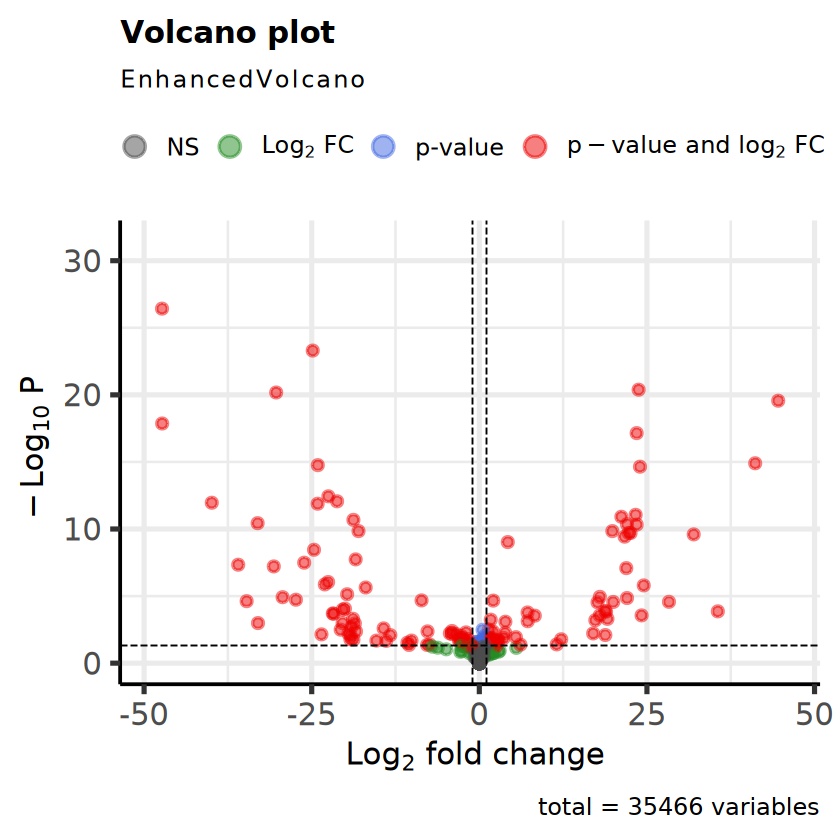

In [31]:
res.cw.cc <- lfcShrink(dds.noOutliers, contrast= c('complete_trtmt', 'control.warm', 'control.control'), # CC is the "control"
                     type = 'ashr',
                      lfcThreshold = 1)

summary(res.cw.cc)

EnhancedVolcano(res.cw.cc,
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

res.cw.cc <- merge(res.cw.cc, counts(dds.noOutliers, normalized=TRUE), by="row.names", sort=FALSE) # add normalized counts to DESeq results
names(res.cw.cc)[1] <- 'Gene'

head(res.cw.cc)

In [32]:
write.csv(res.cw.cc, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_res_files/all_genes/cw_cc.csv', row.names = FALSE)

**CC vs. CH**

using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041

computing FSOS 'false sign or small' s-values (T=1)




out of 35396 with nonzero total read count
s-value < 0.005
LFC > 1.00 (up)    : 37, 0.1%
LFC < -1.00 (down) : 89, 0.25%



Gene         baseMean    log2FoldChange lfcSE      stat       pvalue    
1 LOC111116054   9.0629842 -0.017714203   0.10784162 -1.2741984 0.20259311
2 LOC111126949 539.2853993  0.024121223   0.09814347  0.9043384 0.36581600
3 LOC111110729 114.0070007  0.011710406   0.09367668  0.3317821 0.74005377
4 LOC111112434   6.9517032 -0.010119602   0.11050732 -0.9587209 0.33769938
5 LOC111120752 429.0263780 -0.075609854   0.10192079 -2.3137501 0.02068143
6 LOC111128944   0.1088474  0.002518355   0.41611548  0.1199736 0.90450403
  padj      svalue    B1_B1_O01  B1_W5_O50  ⋯ W4_W5_G56  W5_B2_G21  W5_C4_G45
1 0.9112951 0.9792085   1.875059   5.965799 ⋯   4.336105   2.452846  11.19491
2 0.9819065 0.9900869 829.713451 474.281013 ⋯ 230.897604 544.531781 506.25864
3 1.0000000 0.9922563  60.001877  92.469883 ⋯ 128.999131  62.138762  87.07151
4 0.9727517 0.9792173  10.312823   1.988600 ⋯   6.504158   0.000000  13.68267
5 0.5069984 0.9842178 337.510556 334.084739 ⋯ 421.686235 286.165350 446.55246
6 1.0000000 0.9414877   0.000000   0.000000 ⋯   0.000000   0.000000   0.00000
  W5_H4_G46  W5_W2_G22  W6_B3_G35  W6_B4_G48  W6_H6_G71 W6_W3_G36  W6_W4_G48
1   2.006592   7.359253   5.277065   2.300668  21.05700   1.075999   0.0000 
2 742.439160 650.373981 428.497663 480.839693 469.90350 302.355713 636.4963 
3 149.491128 111.308701 121.372491 144.942108 119.69240 136.651870 226.3334 
4   6.019777   3.679626   0.000000   2.300668  17.73221   8.607992   0.0000 
5 346.137176 402.919100 293.404804 330.145914 461.03739 358.307660 456.9172 
6   0.000000   0.000000   0.000000   0.000000   0.00000   0.000000   0.0000

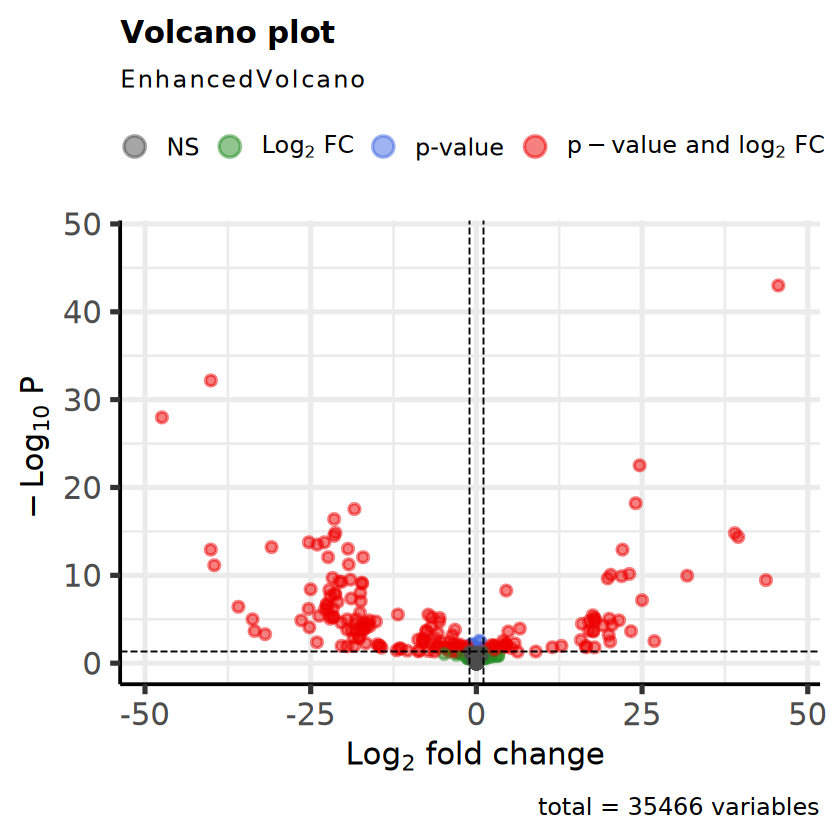

In [33]:
res.ch.cc <- lfcShrink(dds.noOutliers, contrast= c('complete_trtmt', 'control.hypoxic', 'control.control'), # CC is the "control"
                     type = 'ashr',
                      lfcThreshold = 1)

summary(res.ch.cc)

EnhancedVolcano(res.ch.cc,
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

res.ch.cc <- merge(res.ch.cc, counts(dds.noOutliers, normalized=TRUE), by="row.names", sort=FALSE) # add normalized counts to DESeq results
names(res.ch.cc)[1] <- 'Gene'

head(res.ch.cc)

In [34]:
write.csv(res.ch.cc, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_res_files/all_genes/ch_cc.csv', row.names = FALSE)

**CC vs. CB**

using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041

computing FSOS 'false sign or small' s-values (T=1)




out of 35396 with nonzero total read count
s-value < 0.005
LFC > 1.00 (up)    : 42, 0.12%
LFC < -1.00 (down) : 89, 0.25%



Gene         baseMean    log2FoldChange lfcSE     stat         pvalue   
1 LOC111116054   9.0629842  0.0394551274  0.1692529  1.140804569 0.2539513
2 LOC111126949 539.2853993  0.0673582574  0.1472642  1.226192373 0.2201263
3 LOC111110729 114.0070007  0.0468756504  0.1268223  0.739115937 0.4598366
4 LOC111112434   6.9517032 -0.0001951383  0.1641972 -0.007610126 0.9939281
5 LOC111120752 429.0263780 -0.1323246269  0.1594044 -1.996380661 0.0458925
6 LOC111128944   0.1088474  0.0000000000  0.4098034  0.000000000 1.0000000
  padj      svalue    B1_B1_O01  B1_W5_O50  ⋯ W4_W5_G56  W5_B2_G21  W5_C4_G45
1 0.8943512 0.9724301   1.875059   5.965799 ⋯   4.336105   2.452846  11.19491
2 0.8587969 0.9866035 829.713451 474.281013 ⋯ 230.897604 544.531781 506.25864
3 0.9807682 0.9899820  60.001877  92.469883 ⋯ 128.999131  62.138762  87.07151
4 1.0000000 0.9848460  10.312823   1.988600 ⋯   6.504158   0.000000  13.68267
5 0.5424278 0.9840477 337.510556 334.084739 ⋯ 421.686235 286.165350 446.55246
6        NA 0.9634835   0.000000   0.000000 ⋯   0.000000   0.000000   0.00000
  W5_H4_G46  W5_W2_G22  W6_B3_G35  W6_B4_G48  W6_H6_G71 W6_W3_G36  W6_W4_G48
1   2.006592   7.359253   5.277065   2.300668  21.05700   1.075999   0.0000 
2 742.439160 650.373981 428.497663 480.839693 469.90350 302.355713 636.4963 
3 149.491128 111.308701 121.372491 144.942108 119.69240 136.651870 226.3334 
4   6.019777   3.679626   0.000000   2.300668  17.73221   8.607992   0.0000 
5 346.137176 402.919100 293.404804 330.145914 461.03739 358.307660 456.9172 
6   0.000000   0.000000   0.000000   0.000000   0.00000   0.000000   0.0000

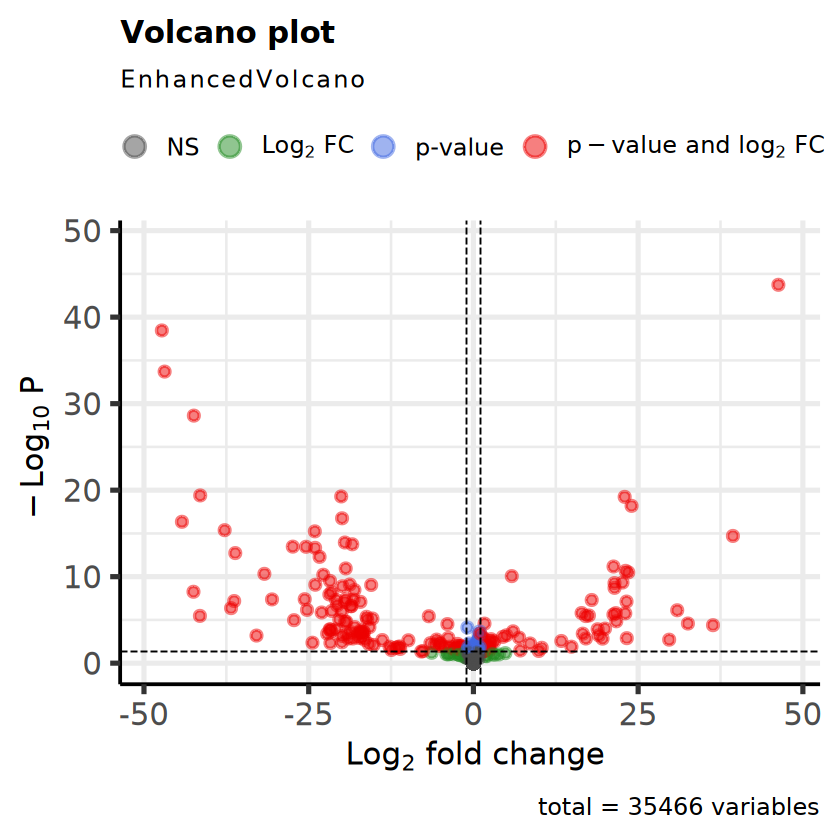

In [35]:
res.cb.cc <- lfcShrink(dds.noOutliers, contrast= c('complete_trtmt', 'control.both', 'control.control'), # CC is the "control"
                     type = 'ashr',
                      lfcThreshold = 1)

summary(res.cb.cc)

EnhancedVolcano(res.cb.cc,
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

res.cb.cc <- merge(res.cb.cc, counts(dds.noOutliers, normalized=TRUE), by="row.names", sort=FALSE) # add normalized counts to DESeq results
names(res.cb.cc)[1] <- 'Gene'

head(res.cb.cc)

In [36]:
write.csv(res.cb.cc, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_res_files/all_genes/cb_cc.csv', row.names = FALSE)

### 3. Timing of Stress Exposure
How does GE change depending on when stress is experienced (when all oysters only experience stress once)?
- CH vs. HC
- CW vs. WC
- CB vs. BC

**CH vs. HC**

using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041

computing FSOS 'false sign or small' s-values (T=1)




out of 35396 with nonzero total read count
s-value < 0.005
LFC > 1.00 (up)    : 74, 0.21%
LFC < -1.00 (down) : 73, 0.21%



Gene         baseMean    log2FoldChange lfcSE      stat       pvalue   
1 LOC111116054   9.0629842 -0.0013534773  0.03665930 -1.0521907 0.2927121
2 LOC111126949 539.2853993  0.0017805166  0.02701588  0.9025947 0.3667410
3 LOC111110729 114.0070007  0.0004489181  0.02612559  0.1635587 0.8700785
4 LOC111112434   6.9517032 -0.0015349739  0.04994849 -1.0762159 0.2818307
5 LOC111120752 429.0263780 -0.0037035339  0.02780323 -1.5067657 0.1318707
6 LOC111128944   0.1088474  0.0022171569  0.40723033  0.1102090 0.9122436
  padj      svalue    B1_B1_O01  B1_W5_O50  ⋯ W4_W5_G56  W5_B2_G21  W5_C4_G45
1 1.0000000 0.9815142   1.875059   5.965799 ⋯   4.336105   2.452846  11.19491
2 1.0000000 0.9895917 829.713451 474.281013 ⋯ 230.897604 544.531781 506.25864
3 1.0000000 0.9920481  60.001877  92.469883 ⋯ 128.999131  62.138762  87.07151
4 1.0000000 0.9752359  10.312823   1.988600 ⋯   6.504158   0.000000  13.68267
5 0.9616578 0.9893491 337.510556 334.084739 ⋯ 421.686235 286.165350 446.55246
6 1.0000000 0.9327689   0.000000   0.000000 ⋯   0.000000   0.000000   0.00000
  W5_H4_G46  W5_W2_G22  W6_B3_G35  W6_B4_G48  W6_H6_G71 W6_W3_G36  W6_W4_G48
1   2.006592   7.359253   5.277065   2.300668  21.05700   1.075999   0.0000 
2 742.439160 650.373981 428.497663 480.839693 469.90350 302.355713 636.4963 
3 149.491128 111.308701 121.372491 144.942108 119.69240 136.651870 226.3334 
4   6.019777   3.679626   0.000000   2.300668  17.73221   8.607992   0.0000 
5 346.137176 402.919100 293.404804 330.145914 461.03739 358.307660 456.9172 
6   0.000000   0.000000   0.000000   0.000000   0.00000   0.000000   0.0000

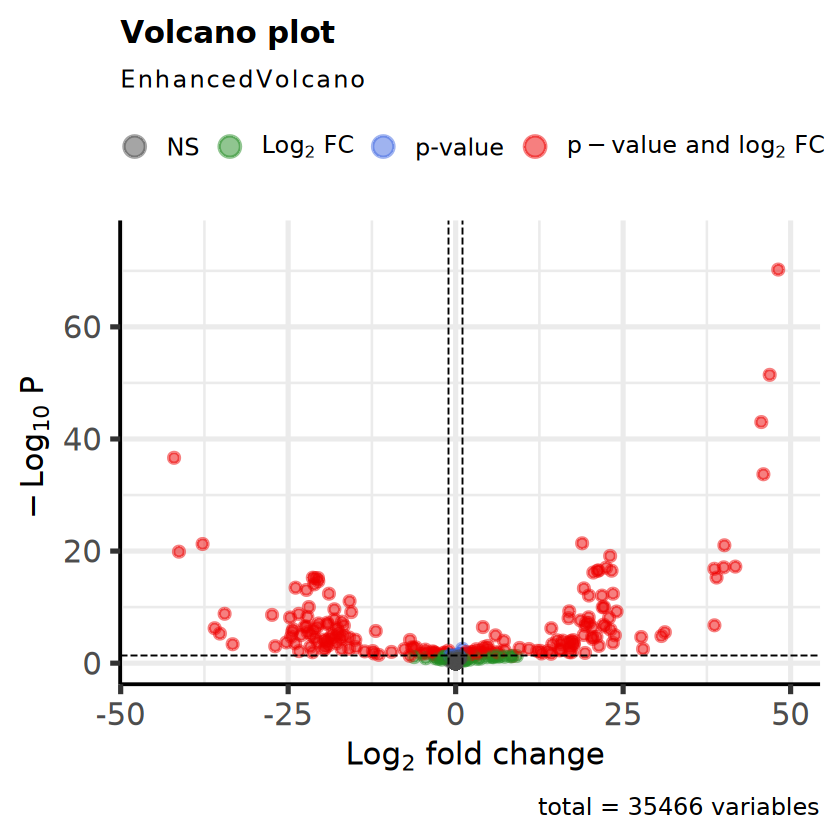

In [37]:
res.ch.hc <- lfcShrink(dds.noOutliers, contrast= c('complete_trtmt', 'control.hypoxic', 'hypoxic.control'), # HC is the "control"
                     type = 'ashr',
                      lfcThreshold = 1)

summary(res.ch.hc)

EnhancedVolcano(res.ch.hc,
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

res.ch.hc <- merge(res.ch.hc, counts(dds.noOutliers, normalized=TRUE), by="row.names", sort=FALSE) # add normalized counts to DESeq results
names(res.ch.hc)[1] <- 'Gene'

head(res.ch.hc)

In [38]:
write.csv(res.ch.hc, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_res_files/all_genes/ch_hc.csv', row.names = FALSE)

**CW vs. WC**

using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041

computing FSOS 'false sign or small' s-values (T=1)




out of 35396 with nonzero total read count
s-value < 0.005
LFC > 1.00 (up)    : 57, 0.16%
LFC < -1.00 (down) : 46, 0.13%



Gene         baseMean    log2FoldChange lfcSE     stat       pvalue   
1 LOC111116054   9.0629842 -0.028579189   0.1765320 -0.7058780 0.4802640
2 LOC111126949 539.2853993  0.073618202   0.1593307  1.0532431 0.2922296
3 LOC111110729 114.0070007  0.135167488   0.1453968  1.6219680 0.1048102
4 LOC111112434   6.9517032 -0.006912183   0.1813588 -0.2267327 0.8206316
5 LOC111120752 429.0263780 -0.030364866   0.1498546 -0.3899568 0.6965685
6 LOC111128944   0.1088474  0.002530254   0.4073713  0.1254499 0.9001674
  padj      svalue    B1_B1_O01  B1_W5_O50  ⋯ W4_W5_G56  W5_B2_G21  W5_C4_G45
1 0.9105206 0.9831096   1.875059   5.965799 ⋯   4.336105   2.452846  11.19491
2 0.8128319 0.9874279 829.713451 474.281013 ⋯ 230.897604 544.531781 506.25864
3 0.6139547 0.9886239  60.001877  92.469883 ⋯ 128.999131  62.138762  87.07151
4 0.9935450 0.9831731  10.312823   1.988600 ⋯   6.504158   0.000000  13.68267
5 0.9723209 0.9898209 337.510556 334.084739 ⋯ 421.686235 286.165350 446.55246
6        NA 0.9569139   0.000000   0.000000 ⋯   0.000000   0.000000   0.00000
  W5_H4_G46  W5_W2_G22  W6_B3_G35  W6_B4_G48  W6_H6_G71 W6_W3_G36  W6_W4_G48
1   2.006592   7.359253   5.277065   2.300668  21.05700   1.075999   0.0000 
2 742.439160 650.373981 428.497663 480.839693 469.90350 302.355713 636.4963 
3 149.491128 111.308701 121.372491 144.942108 119.69240 136.651870 226.3334 
4   6.019777   3.679626   0.000000   2.300668  17.73221   8.607992   0.0000 
5 346.137176 402.919100 293.404804 330.145914 461.03739 358.307660 456.9172 
6   0.000000   0.000000   0.000000   0.000000   0.00000   0.000000   0.0000

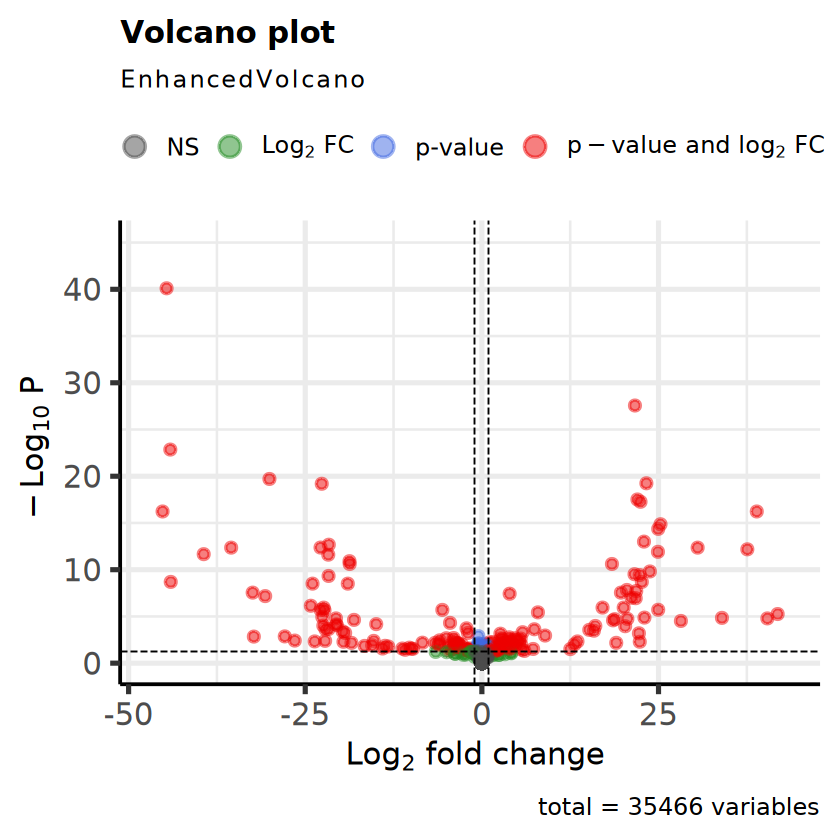

In [39]:
res.cw.wc <- lfcShrink(dds.noOutliers, contrast= c('complete_trtmt', 'control.warm', 'warm.control'), # WC is the "control"
                     type = 'ashr',
                      lfcThreshold = 1)

summary(res.cw.wc)

EnhancedVolcano(res.cw.wc,
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

res.cw.wc <- merge(res.cw.wc, counts(dds.noOutliers, normalized=TRUE), by="row.names", sort=FALSE) # add normalized counts to DESeq results
names(res.cw.wc)[1] <- 'Gene'

head(res.cw.wc)

In [40]:
write.csv(res.cw.wc, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_res_files/all_genes/cw_wc.csv', row.names = FALSE)

**CB vs. BC**

using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041

computing FSOS 'false sign or small' s-values (T=1)




out of 35396 with nonzero total read count
s-value < 0.005
LFC > 1.00 (up)    : 138, 0.39%
LFC < -1.00 (down) : 76, 0.21%



Gene         baseMean    log2FoldChange lfcSE     stat       pvalue   
1 LOC111116054   9.0629842  0.045556301   0.1781729  1.3075090 0.1910399
2 LOC111126949 539.2853993  0.037788736   0.1435489  0.7251306 0.4683719
3 LOC111110729 114.0070007  0.021723880   0.1239541  0.3738657 0.7085042
4 LOC111112434   6.9517032  0.006929753   0.1684364  0.2724353 0.7852873
5 LOC111120752 429.0263780 -0.037576021   0.1337414 -0.6640069 0.5066859
6 LOC111128944   0.1088474  0.000000000   0.5516789  0.0000000 1.0000000
  padj      svalue    B1_B1_O01  B1_W5_O50  ⋯ W4_W5_G56  W5_B2_G21  W5_C4_G45
1 0.7981617 0.9589249   1.875059   5.965799 ⋯   4.336105   2.452846  11.19491
2 0.9522049 0.9842384 829.713451 474.281013 ⋯ 230.897604 544.531781 506.25864
3 0.9899845 0.9870451  60.001877  92.469883 ⋯ 128.999131  62.138762  87.07151
4 0.9974794 0.9777038  10.312823   1.988600 ⋯   6.504158   0.000000  13.68267
5 0.9620084 0.9858942 337.510556 334.084739 ⋯ 421.686235 286.165350 446.55246
6        NA 0.9377166   0.000000   0.000000 ⋯   0.000000   0.000000   0.00000
  W5_H4_G46  W5_W2_G22  W6_B3_G35  W6_B4_G48  W6_H6_G71 W6_W3_G36  W6_W4_G48
1   2.006592   7.359253   5.277065   2.300668  21.05700   1.075999   0.0000 
2 742.439160 650.373981 428.497663 480.839693 469.90350 302.355713 636.4963 
3 149.491128 111.308701 121.372491 144.942108 119.69240 136.651870 226.3334 
4   6.019777   3.679626   0.000000   2.300668  17.73221   8.607992   0.0000 
5 346.137176 402.919100 293.404804 330.145914 461.03739 358.307660 456.9172 
6   0.000000   0.000000   0.000000   0.000000   0.00000   0.000000   0.0000

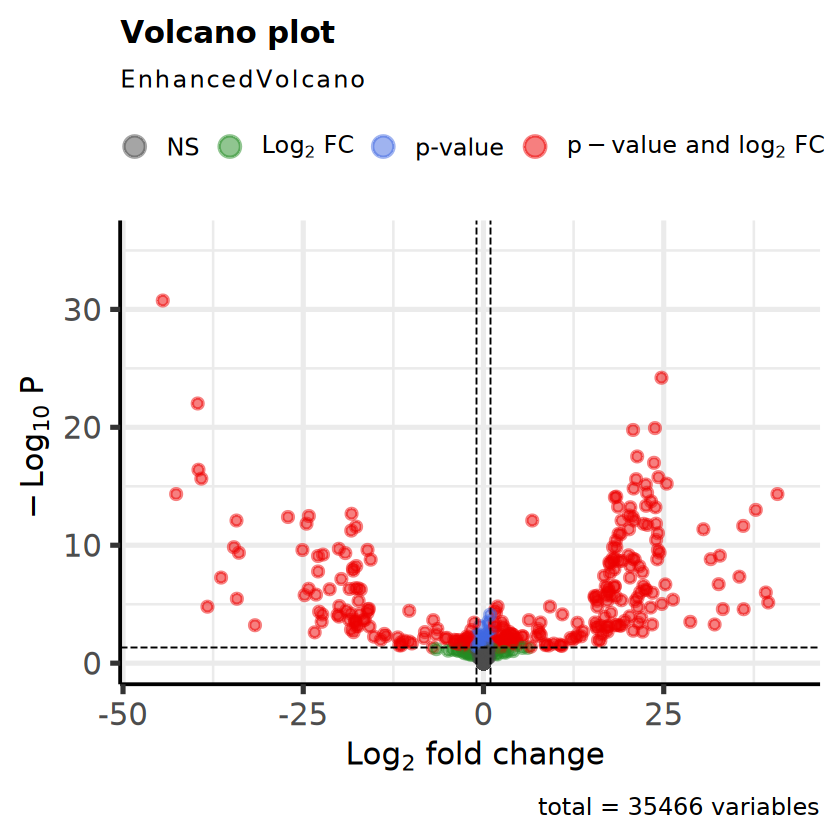

In [41]:
res.cb.bc <- lfcShrink(dds.noOutliers, contrast= c('complete_trtmt', 'control.both', 'both.control'), # BC is the "control"
                     type = 'ashr',
                      lfcThreshold = 1)

summary(res.cb.bc)

EnhancedVolcano(res.cb.bc,
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

res.cb.bc <- merge(res.cb.bc, counts(dds.noOutliers, normalized=TRUE), by="row.names", sort=FALSE) # add normalized counts to DESeq results
names(res.cb.bc)[1] <- 'Gene'

head(res.cb.bc)

In [42]:
write.csv(res.cb.bc, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_res_files/all_genes/cb_bc.csv', row.names = FALSE)

### 4. No stress vs. most stress
- CC vs. WW
- CC vs. HH
- CC vs. BB

**CC vs. WW**

using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041

computing FSOS 'false sign or small' s-values (T=1)




out of 35396 with nonzero total read count
s-value < 0.005
LFC > 1.00 (up)    : 43, 0.12%
LFC < -1.00 (down) : 44, 0.12%



Gene         baseMean    log2FoldChange lfcSE      stat       pvalue    
1 LOC111116054   9.0629842 -0.0032126601  0.05363175 -1.6929407 0.09046676
2 LOC111126949 539.2853993  0.0002815072  0.03173199  0.1003701 0.92005051
3 LOC111110729 114.0070007  0.0082823163  0.03356744  2.0161106 0.04378842
4 LOC111112434   6.9517032 -0.0015939212  0.04717261 -1.1036117 0.26976160
5 LOC111120752 429.0263780 -0.0034475539  0.03178548 -0.9901461 0.32210269
6 LOC111128944   0.1088474  0.0032832039  0.33368106  0.2531660 0.80013996
  padj      svalue    B1_B1_O01  B1_W5_O50  ⋯ W4_W5_G56  W5_B2_G21  W5_C4_G45
1 1.0000000 0.9747664   1.875059   5.965799 ⋯   4.336105   2.452846  11.19491
2 1.0000000 0.9942658 829.713451 474.281013 ⋯ 230.897604 544.531781 506.25864
3 0.8999161 0.9928997  60.001877  92.469883 ⋯ 128.999131  62.138762  87.07151
4 1.0000000 0.9832124  10.312823   1.988600 ⋯   6.504158   0.000000  13.68267
5 1.0000000 0.9940444 337.510556 334.084739 ⋯ 421.686235 286.165350 446.55246
6 1.0000000 0.9391456   0.000000   0.000000 ⋯   0.000000   0.000000   0.00000
  W5_H4_G46  W5_W2_G22  W6_B3_G35  W6_B4_G48  W6_H6_G71 W6_W3_G36  W6_W4_G48
1   2.006592   7.359253   5.277065   2.300668  21.05700   1.075999   0.0000 
2 742.439160 650.373981 428.497663 480.839693 469.90350 302.355713 636.4963 
3 149.491128 111.308701 121.372491 144.942108 119.69240 136.651870 226.3334 
4   6.019777   3.679626   0.000000   2.300668  17.73221   8.607992   0.0000 
5 346.137176 402.919100 293.404804 330.145914 461.03739 358.307660 456.9172 
6   0.000000   0.000000   0.000000   0.000000   0.00000   0.000000   0.0000

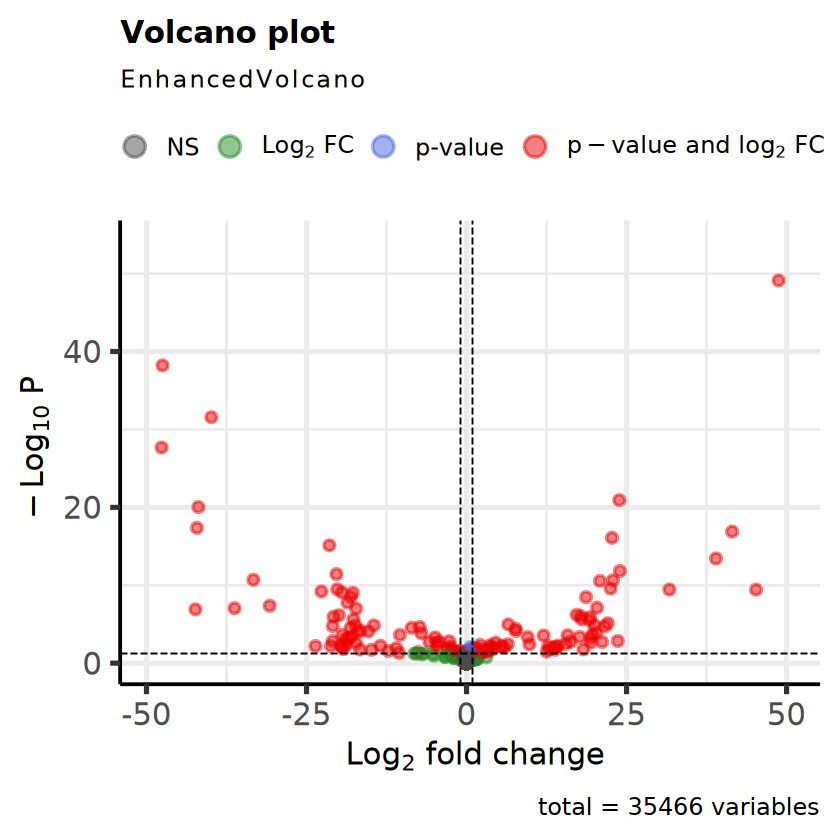

In [43]:
res.cc.ww <- lfcShrink(dds.noOutliers, contrast= c('complete_trtmt', 'warm.warm', 'control.control'), # CC is the "control"
                     type = 'ashr',
                      lfcThreshold = 1)

summary(res.cc.ww)

EnhancedVolcano(res.cc.ww,
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

res.cc.ww <- merge(res.cc.ww, counts(dds.noOutliers, normalized=TRUE), by="row.names", sort=FALSE) # add normalized counts to DESeq results
names(res.cc.ww)[1] <- 'Gene'

head(res.cc.ww)

In [44]:
write.csv(res.cc.ww, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_res_files/all_genes/ww_cc.csv', row.names = FALSE)

**CC vs. HH**

using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041

computing FSOS 'false sign or small' s-values (T=1)




out of 35396 with nonzero total read count
s-value < 0.005
LFC > 1.00 (up)    : 34, 0.096%
LFC < -1.00 (down) : 179, 0.51%



Gene         baseMean    log2FoldChange lfcSE      stat       pvalue   
1 LOC111116054   9.0629842 -0.008610599   0.09336735 -0.8210431 0.4116217
2 LOC111126949 539.2853993 -0.028023639   0.08880010 -1.3688881 0.1710343
3 LOC111110729 114.0070007 -0.012491053   0.08489364 -0.4538486 0.6499378
4 LOC111112434   6.9517032 -0.005203912   0.09742624 -0.6399750 0.5221888
5 LOC111120752 429.0263780 -0.037500458   0.08723759 -1.5156350 0.1296117
6 LOC111128944   0.1088474  0.000000000   0.53741011  0.0000000 1.0000000
  padj      svalue    B1_B1_O01  B1_W5_O50  ⋯ W4_W5_G56  W5_B2_G21  W5_C4_G45
1 0.9792734 0.9777299   1.875059   5.965799 ⋯   4.336105   2.452846  11.19491
2 0.8522741 0.9828078 829.713451 474.281013 ⋯ 230.897604 544.531781 506.25864
3 1.0000000 0.9882091  60.001877  92.469883 ⋯ 128.999131  62.138762  87.07151
4 1.0000000 0.9751716  10.312823   1.988600 ⋯   6.504158   0.000000  13.68267
5 0.8045900 0.9846280 337.510556 334.084739 ⋯ 421.686235 286.165350 446.55246
6        NA 0.9248240   0.000000   0.000000 ⋯   0.000000   0.000000   0.00000
  W5_H4_G46  W5_W2_G22  W6_B3_G35  W6_B4_G48  W6_H6_G71 W6_W3_G36  W6_W4_G48
1   2.006592   7.359253   5.277065   2.300668  21.05700   1.075999   0.0000 
2 742.439160 650.373981 428.497663 480.839693 469.90350 302.355713 636.4963 
3 149.491128 111.308701 121.372491 144.942108 119.69240 136.651870 226.3334 
4   6.019777   3.679626   0.000000   2.300668  17.73221   8.607992   0.0000 
5 346.137176 402.919100 293.404804 330.145914 461.03739 358.307660 456.9172 
6   0.000000   0.000000   0.000000   0.000000   0.00000   0.000000   0.0000

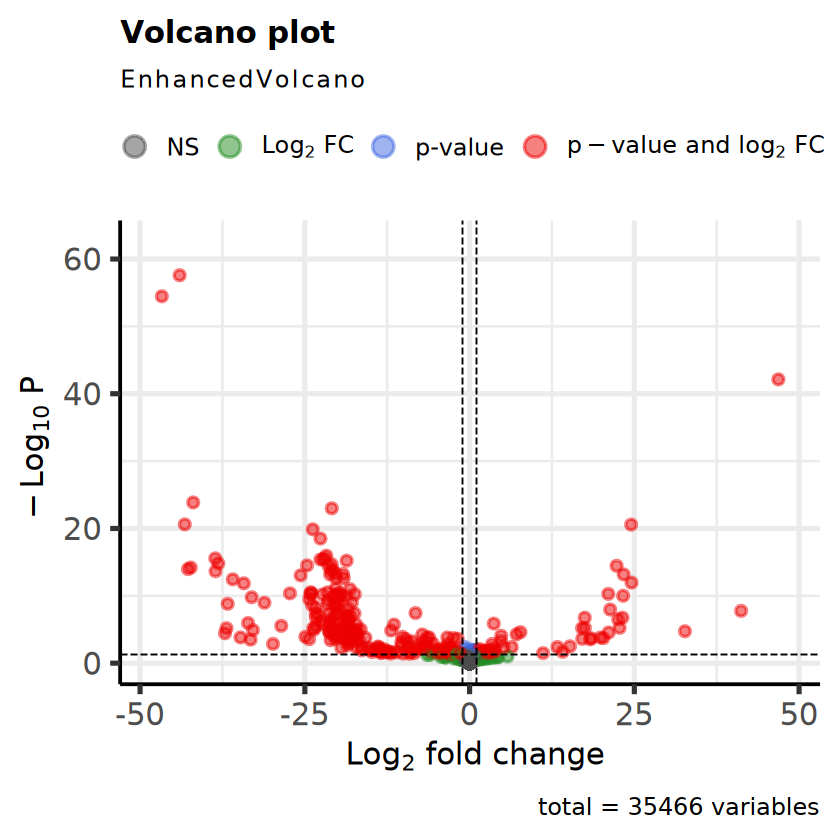

In [45]:
res.cc.hh <- lfcShrink(dds.noOutliers, contrast= c('complete_trtmt', 'hypoxic.hypoxic', 'control.control'), # CC is the "control"
                     type = 'ashr',
                      lfcThreshold = 1)

summary(res.cc.hh)

EnhancedVolcano(res.cc.hh,
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

res.cc.hh <- merge(res.cc.hh, counts(dds.noOutliers, normalized=TRUE), by="row.names", sort=FALSE) # add normalized counts to DESeq results
names(res.cc.hh)[1] <- 'Gene'

head(res.cc.hh)

In [46]:
write.csv(res.cc.hh, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_res_files/all_genes/hh_cc.csv', row.names = FALSE)

**CC vs. BB**

using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041

computing FSOS 'false sign or small' s-values (T=1)




out of 35396 with nonzero total read count
s-value < 0.005
LFC > 1.00 (up)    : 33, 0.093%
LFC < -1.00 (down) : 41, 0.12%



Gene         baseMean    log2FoldChange lfcSE     stat        pvalue    
1 LOC111116054   9.0629842  0.0259479758  0.1402977  1.25567421 0.20923411
2 LOC111126949 539.2853993 -0.0449490919  0.1165042 -1.33937885 0.18044737
3 LOC111110729 114.0070007  0.0410675894  0.1029589  1.00110678 0.31677519
4 LOC111112434   6.9517032 -0.0065767034  0.1296686 -0.41782612 0.67607425
5 LOC111120752 429.0263780  0.0928699742  0.1371736  2.16428698 0.03044233
6 LOC111128944   0.1088474 -0.0002295948  0.3710452 -0.01360725 0.98914332
  padj      svalue    B1_B1_O01  B1_W5_O50  ⋯ W4_W5_G56  W5_B2_G21  W5_C4_G45
1 0.8319315 0.9732181   1.875059   5.965799 ⋯   4.336105   2.452846  11.19491
2 0.8099303 0.9884593 829.713451 474.281013 ⋯ 230.897604 544.531781 506.25864
3 0.8906606 0.9913654  60.001877  92.469883 ⋯ 128.999131  62.138762  87.07151
4 0.9810808 0.9854003  10.312823   1.988600 ⋯   6.504158   0.000000  13.68267
5 0.5232864 0.9843004 337.510556 334.084739 ⋯ 421.686235 286.165350 446.55246
6        NA 0.9712555   0.000000   0.000000 ⋯   0.000000   0.000000   0.00000
  W5_H4_G46  W5_W2_G22  W6_B3_G35  W6_B4_G48  W6_H6_G71 W6_W3_G36  W6_W4_G48
1   2.006592   7.359253   5.277065   2.300668  21.05700   1.075999   0.0000 
2 742.439160 650.373981 428.497663 480.839693 469.90350 302.355713 636.4963 
3 149.491128 111.308701 121.372491 144.942108 119.69240 136.651870 226.3334 
4   6.019777   3.679626   0.000000   2.300668  17.73221   8.607992   0.0000 
5 346.137176 402.919100 293.404804 330.145914 461.03739 358.307660 456.9172 
6   0.000000   0.000000   0.000000   0.000000   0.00000   0.000000   0.0000

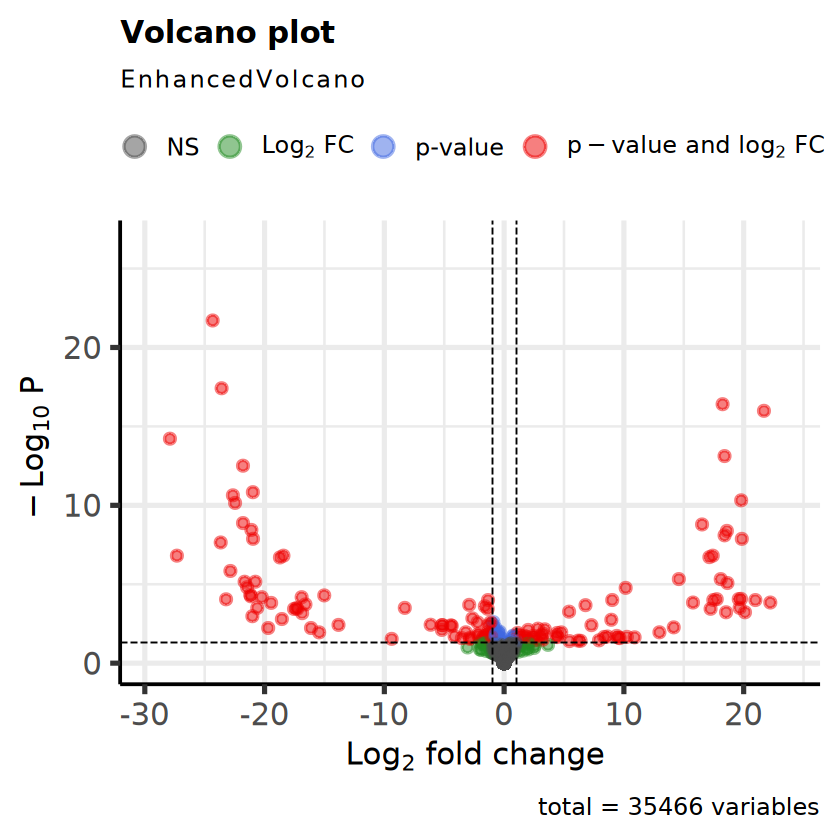

In [47]:
res.cc.bb <- lfcShrink(dds.noOutliers, coef='complete_trtmt_control.control_vs_both.both', # BB is the "control"
                     type = 'ashr',
                      lfcThreshold = 1)

summary(res.cc.bb)

EnhancedVolcano(res.cc.bb,
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

res.cc.bb <- merge(res.cc.bb, counts(dds.noOutliers, normalized=TRUE), by="row.names", sort=FALSE) # add normalized counts to DESeq results
names(res.cc.bb)[1] <- 'Gene'

head(res.cc.bb)

switch LFC direction so CC is the baseline (deseq recognizes as bb as the baseline rn)

In [48]:
cc.bb.df <- as.data.frame(res.cc.bb) %>% # create df
mutate(log2FoldChange = log2FoldChange * -1) # multiple by -1 to make pos to neg and vice versa 

# validate
head(res.cc.bb)
head(cc.bb.df)

Gene         baseMean    log2FoldChange lfcSE     stat        pvalue    
1 LOC111116054   9.0629842  0.0259479758  0.1402977  1.25567421 0.20923411
2 LOC111126949 539.2853993 -0.0449490919  0.1165042 -1.33937885 0.18044737
3 LOC111110729 114.0070007  0.0410675894  0.1029589  1.00110678 0.31677519
4 LOC111112434   6.9517032 -0.0065767034  0.1296686 -0.41782612 0.67607425
5 LOC111120752 429.0263780  0.0928699742  0.1371736  2.16428698 0.03044233
6 LOC111128944   0.1088474 -0.0002295948  0.3710452 -0.01360725 0.98914332
  padj      svalue    B1_B1_O01  B1_W5_O50  ⋯ W4_W5_G56  W5_B2_G21  W5_C4_G45
1 0.8319315 0.9732181   1.875059   5.965799 ⋯   4.336105   2.452846  11.19491
2 0.8099303 0.9884593 829.713451 474.281013 ⋯ 230.897604 544.531781 506.25864
3 0.8906606 0.9913654  60.001877  92.469883 ⋯ 128.999131  62.138762  87.07151
4 0.9810808 0.9854003  10.312823   1.988600 ⋯   6.504158   0.000000  13.68267
5 0.5232864 0.9843004 337.510556 334.084739 ⋯ 421.686235 286.165350 446.55246
6        NA 0.9712555   0.000000   0.000000 ⋯   0.000000   0.000000   0.00000
  W5_H4_G46  W5_W2_G22  W6_B3_G35  W6_B4_G48  W6_H6_G71 W6_W3_G36  W6_W4_G48
1   2.006592   7.359253   5.277065   2.300668  21.05700   1.075999   0.0000 
2 742.439160 650.373981 428.497663 480.839693 469.90350 302.355713 636.4963 
3 149.491128 111.308701 121.372491 144.942108 119.69240 136.651870 226.3334 
4   6.019777   3.679626   0.000000   2.300668  17.73221   8.607992   0.0000 
5 346.137176 402.919100 293.404804 330.145914 461.03739 358.307660 456.9172 
6   0.000000   0.000000   0.000000   0.000000   0.00000   0.000000   0.0000

Gene         baseMean    log2FoldChange lfcSE     stat        pvalue    
1 LOC111116054   9.0629842 -0.0259479758  0.1402977  1.25567421 0.20923411
2 LOC111126949 539.2853993  0.0449490919  0.1165042 -1.33937885 0.18044737
3 LOC111110729 114.0070007 -0.0410675894  0.1029589  1.00110678 0.31677519
4 LOC111112434   6.9517032  0.0065767034  0.1296686 -0.41782612 0.67607425
5 LOC111120752 429.0263780 -0.0928699742  0.1371736  2.16428698 0.03044233
6 LOC111128944   0.1088474  0.0002295948  0.3710452 -0.01360725 0.98914332
  padj      svalue    B1_B1_O01  B1_W5_O50  ⋯ W4_W5_G56  W5_B2_G21  W5_C4_G45
1 0.8319315 0.9732181   1.875059   5.965799 ⋯   4.336105   2.452846  11.19491
2 0.8099303 0.9884593 829.713451 474.281013 ⋯ 230.897604 544.531781 506.25864
3 0.8906606 0.9913654  60.001877  92.469883 ⋯ 128.999131  62.138762  87.07151
4 0.9810808 0.9854003  10.312823   1.988600 ⋯   6.504158   0.000000  13.68267
5 0.5232864 0.9843004 337.510556 334.084739 ⋯ 421.686235 286.165350 446.55246
6        NA 0.9712555   0.000000   0.000000 ⋯   0.000000   0.000000   0.00000
  W5_H4_G46  W5_W2_G22  W6_B3_G35  W6_B4_G48  W6_H6_G71 W6_W3_G36  W6_W4_G48
1   2.006592   7.359253   5.277065   2.300668  21.05700   1.075999   0.0000 
2 742.439160 650.373981 428.497663 480.839693 469.90350 302.355713 636.4963 
3 149.491128 111.308701 121.372491 144.942108 119.69240 136.651870 226.3334 
4   6.019777   3.679626   0.000000   2.300668  17.73221   8.607992   0.0000 
5 346.137176 402.919100 293.404804 330.145914 461.03739 358.307660 456.9172 
6   0.000000   0.000000   0.000000   0.000000   0.00000   0.000000   0.0000

In [49]:
write.csv(cc.bb.df, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_res_files/all_genes/bb_cc.csv', row.names = FALSE)

### 5. Effect of initial exposure on response in later exposure
(also gets at the effect of priming to stress)

#### 5A. Matched stressors
Oyster is primed with a stress, and experiences the *same* stressor again
- HH vs. CH
- WW vs. CW
- BB vs. CB

**HH vs. CH**

using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041

computing FSOS 'false sign or small' s-values (T=1)




out of 35396 with nonzero total read count
s-value < 0.005
LFC > 1.00 (up)    : 67, 0.19%
LFC < -1.00 (down) : 164, 0.46%



Gene         baseMean    log2FoldChange lfcSE       stat       pvalue    
1 LOC111116054   9.0629842  0.0003740910  0.029815496  0.3951406 0.69273915
2 LOC111126949 539.2853993 -0.0050145226  0.069398962 -2.2306013 0.02570755
3 LOC111110729 114.0070007 -0.0002059319  0.009389247 -0.7697657 0.44143891
4 LOC111112434   6.9517032  0.0004458616  0.044393585  0.2748434 0.78343655
5 LOC111120752 429.0263780  0.0001920376  0.010265668  0.6904710 0.48989802
6 LOC111128944   0.1088474 -0.0041874887  0.568846168 -0.1118285 0.91095936
  padj      svalue    B1_B1_O01  B1_W5_O50  ⋯ W4_W5_G56  W5_B2_G21  W5_C4_G45
1 1.0000000 0.9765342   1.875059   5.965799 ⋯   4.336105   2.452846  11.19491
2 0.5651909 0.9480565 829.713451 474.281013 ⋯ 230.897604 544.531781 506.25864
3 1.0000000 0.9849767  60.001877  92.469883 ⋯ 128.999131  62.138762  87.07151
4 1.0000000 0.9735909  10.312823   1.988600 ⋯   6.504158   0.000000  13.68267
5 1.0000000 0.9841346 337.510556 334.084739 ⋯ 421.686235 286.165350 446.55246
6 1.0000000 0.9096974   0.000000   0.000000 ⋯   0.000000   0.000000   0.00000
  W5_H4_G46  W5_W2_G22  W6_B3_G35  W6_B4_G48  W6_H6_G71 W6_W3_G36  W6_W4_G48
1   2.006592   7.359253   5.277065   2.300668  21.05700   1.075999   0.0000 
2 742.439160 650.373981 428.497663 480.839693 469.90350 302.355713 636.4963 
3 149.491128 111.308701 121.372491 144.942108 119.69240 136.651870 226.3334 
4   6.019777   3.679626   0.000000   2.300668  17.73221   8.607992   0.0000 
5 346.137176 402.919100 293.404804 330.145914 461.03739 358.307660 456.9172 
6   0.000000   0.000000   0.000000   0.000000   0.00000   0.000000   0.0000

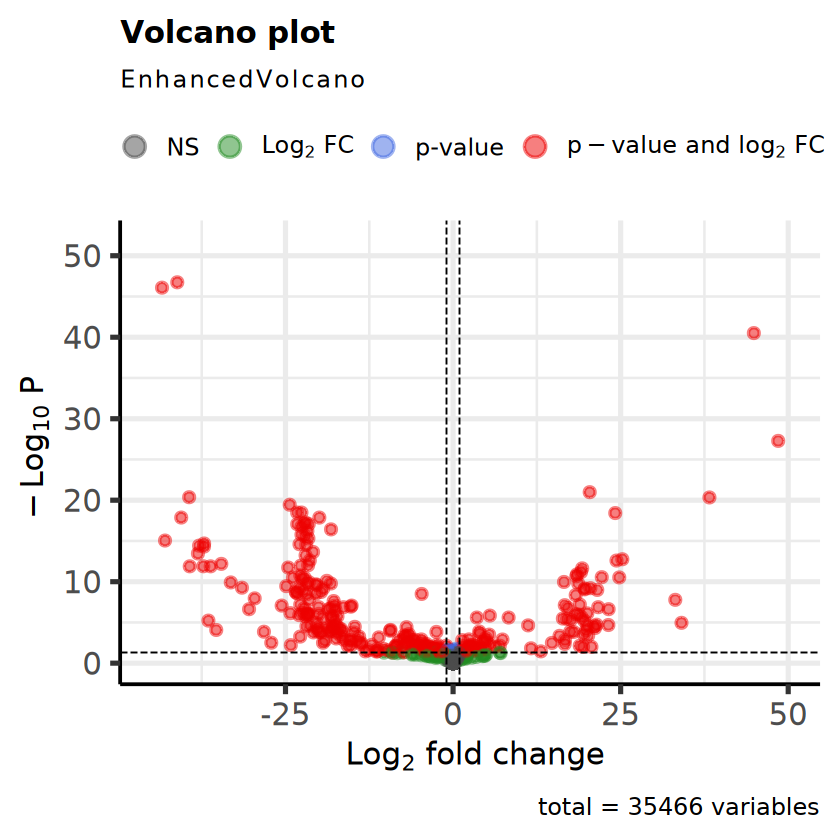

In [50]:
res.hh.ch <- lfcShrink(dds.noOutliers, contrast= c('complete_trtmt', 'hypoxic.hypoxic', 'control.hypoxic'), # CH is the "control"
                     type = 'ashr',
                      lfcThreshold = 1)

summary(res.hh.ch)

EnhancedVolcano(res.hh.ch,
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

res.hh.ch <- merge(res.hh.ch, counts(dds.noOutliers, normalized=TRUE), by="row.names", sort=FALSE) # add normalized counts to DESeq results
names(res.hh.ch)[1] <- 'Gene'

head(res.hh.ch)

In [51]:
write.csv(res.hh.ch, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_res_files/all_genes/hh_ch.csv', row.names = FALSE)

**WW vs. CW**

using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041

computing FSOS 'false sign or small' s-values (T=1)




out of 35396 with nonzero total read count
s-value < 0.005
LFC > 1.00 (up)    : 39, 0.11%
LFC < -1.00 (down) : 39, 0.11%



Gene         baseMean    log2FoldChange lfcSE       stat       pvalue    padj
1 LOC111116054   9.0629842 -8.705515e-04  0.036956616 -1.4225248 0.1548740 1   
2 LOC111126949 539.2853993 -1.458115e-04  0.008820456 -0.8622406 0.3885551 1   
3 LOC111110729 114.0070007 -2.921078e-05  0.006550487 -0.1679160 0.8666493 1   
4 LOC111112434   6.9517032 -2.223628e-04  0.024801382 -0.4743242 0.6352687 1   
5 LOC111120752 429.0263780  8.458394e-05  0.007037658  0.5181182 0.6043758 1   
6 LOC111128944   0.1088474  1.283008e-03  0.309813517  0.1100058 0.9124048 1   
  svalue    B1_B1_O01  B1_W5_O50  ⋯ W4_W5_G56  W5_B2_G21  W5_C4_G45 W5_H4_G46 
1 0.9815734   1.875059   5.965799 ⋯   4.336105   2.452846  11.19491   2.006592
2 0.9933548 829.713451 474.281013 ⋯ 230.897604 544.531781 506.25864 742.439160
3 0.9949105  60.001877  92.469883 ⋯ 128.999131  62.138762  87.07151 149.491128
4 0.9892921  10.312823   1.988600 ⋯   6.504158   0.000000  13.68267   6.019777
5 0.9943777 337.510556 334.084739 ⋯ 421.686235 286.165350 446.55246 346.137176
6 0.9549049   0.000000   0.000000 ⋯   0.000000   0.000000   0.00000   0.000000
  W5_W2_G22  W6_B3_G35  W6_B4_G48  W6_H6_G71 W6_W3_G36  W6_W4_G48
1   7.359253   5.277065   2.300668  21.05700   1.075999   0.0000 
2 650.373981 428.497663 480.839693 469.90350 302.355713 636.4963 
3 111.308701 121.372491 144.942108 119.69240 136.651870 226.3334 
4   3.679626   0.000000   2.300668  17.73221   8.607992   0.0000 
5 402.919100 293.404804 330.145914 461.03739 358.307660 456.9172 
6   0.000000   0.000000   0.000000   0.00000   0.000000   0.0000

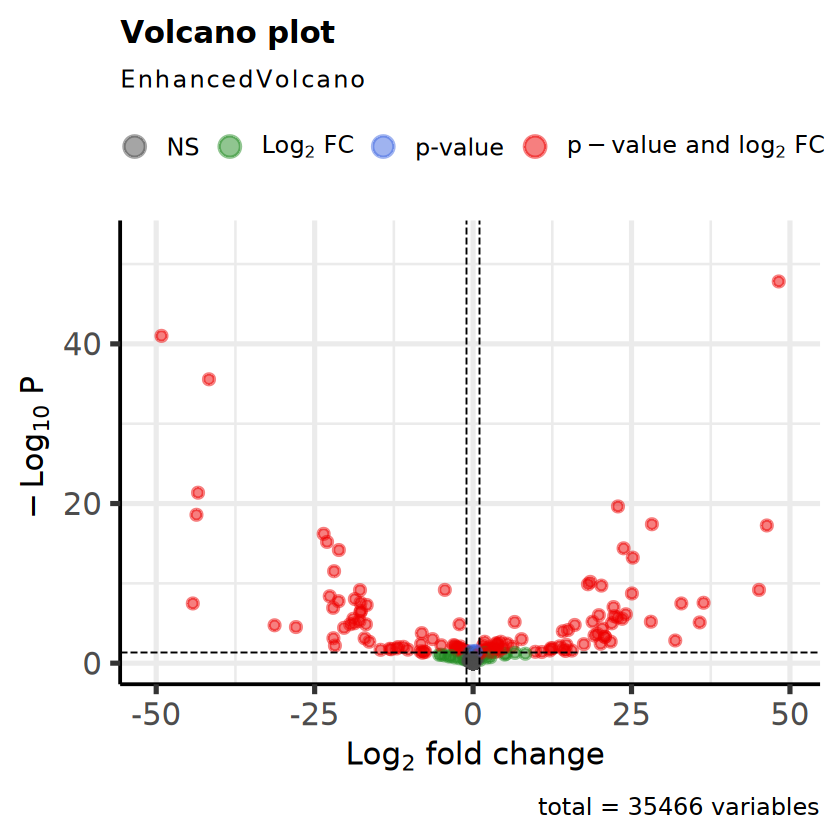

In [52]:
res.ww.cw <- lfcShrink(dds.noOutliers, contrast= c('complete_trtmt', 'warm.warm', 'control.warm'), # CW is the "control"
                     type = 'ashr',
                      lfcThreshold = 1)

summary(res.ww.cw)

EnhancedVolcano(res.ww.cw,
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

res.ww.cw <- merge(res.ww.cw, counts(dds.noOutliers, normalized=TRUE), by="row.names", sort=FALSE) # add normalized counts to DESeq results
names(res.ww.cw)[1] <- 'Gene'

head(res.ww.cw)

In [53]:
write.csv(res.ww.cw, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_res_files/all_genes/ww_cw.csv', row.names = FALSE)

**BB vs. CB**

using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041

computing FSOS 'false sign or small' s-values (T=1)




out of 35396 with nonzero total read count
s-value < 0.005
LFC > 1.00 (up)    : 34, 0.096%
LFC < -1.00 (down) : 88, 0.25%



Gene         baseMean    log2FoldChange lfcSE       stat         pvalue    
1 LOC111116054   9.0629842  1.392211e-02  0.170712517  2.375834273 0.01750932
2 LOC111126949 539.2853993 -1.760036e-05  0.007496281 -0.113056017 0.90998614
3 LOC111110729 114.0070007  4.937664e-04  0.014354156  1.735312694 0.08268543
4 LOC111112434   6.9517032 -3.194641e-04  0.030355779 -0.424395516 0.67127739
5 LOC111120752 429.0263780  2.428646e-05  0.006500916  0.167438584 0.86702497
6 LOC111128944   0.1088474  1.823512e-04  0.429201824  0.008076425 0.99355601
  padj      svalue    B1_B1_O01  B1_W5_O50  ⋯ W4_W5_G56  W5_B2_G21  W5_C4_G45
1 0.5644305 0.8266603   1.875059   5.965799 ⋯   4.336105   2.452846  11.19491
2 0.9995772 0.9908146 829.713451 474.281013 ⋯ 230.897604 544.531781 506.25864
3 0.9375556 0.9896109  60.001877  92.469883 ⋯ 128.999131  62.138762  87.07151
4 0.9995772 0.9841770  10.312823   1.988600 ⋯   6.504158   0.000000  13.68267
5 0.9995772 0.9914936 337.510556 334.084739 ⋯ 421.686235 286.165350 446.55246
6 0.9995772 0.9503786   0.000000   0.000000 ⋯   0.000000   0.000000   0.00000
  W5_H4_G46  W5_W2_G22  W6_B3_G35  W6_B4_G48  W6_H6_G71 W6_W3_G36  W6_W4_G48
1   2.006592   7.359253   5.277065   2.300668  21.05700   1.075999   0.0000 
2 742.439160 650.373981 428.497663 480.839693 469.90350 302.355713 636.4963 
3 149.491128 111.308701 121.372491 144.942108 119.69240 136.651870 226.3334 
4   6.019777   3.679626   0.000000   2.300668  17.73221   8.607992   0.0000 
5 346.137176 402.919100 293.404804 330.145914 461.03739 358.307660 456.9172 
6   0.000000   0.000000   0.000000   0.000000   0.00000   0.000000   0.0000

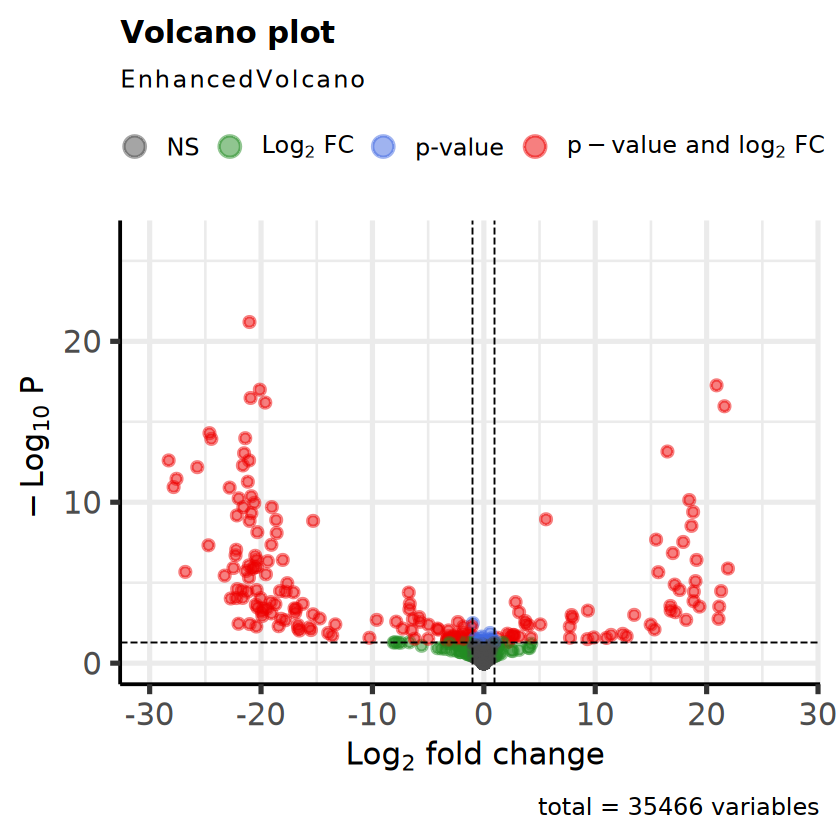

In [54]:
res.cb.bb <- lfcShrink(dds.noOutliers, 
                       coef= 'complete_trtmt_control.both_vs_both.both', # BB is the "control"
                       type = 'ashr',
                      lfcThreshold = 1)

summary(res.cb.bb)

EnhancedVolcano(res.cb.bb,
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

res.cb.bb <- merge(res.cb.bb, counts(dds.noOutliers, normalized=TRUE), by="row.names", sort=FALSE) # add normalized counts to DESeq results
names(res.cb.bb)[1] <- 'Gene'

head(res.cb.bb)

In [55]:
write.csv(res.cb.bb, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_res_files/all_genes/cb_bb.csv', row.names = FALSE)

#### 5B. Semi-matched priming: in context of later *single* stress
- CH vs. BH
- CW vs. BW

**CH vs. BH**

using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041

computing FSOS 'false sign or small' s-values (T=1)




out of 35396 with nonzero total read count
s-value < 0.005
LFC > 1.00 (up)    : 83, 0.23%
LFC < -1.00 (down) : 147, 0.42%



Gene         baseMean    log2FoldChange lfcSE     stat        pvalue    
1 LOC111116054   9.0629842  0.138977845   0.2785701  1.88120604 0.05994390
2 LOC111126949 539.2853993 -0.043304271   0.1899077 -0.43623278 0.66266785
3 LOC111110729 114.0070007 -0.009196232   0.1593905 -0.09057395 0.92783114
4 LOC111112434   6.9517032  0.243930508   0.6018735  2.52377107 0.01161035
5 LOC111120752 429.0263780  0.359239835   0.2138358  2.85982039 0.00423881
6 LOC111128944   0.1088474 -0.003722895   0.6181611 -0.07980125 0.93639533
  padj      svalue    B1_B1_O01  B1_W5_O50  ⋯ W4_W5_G56  W5_B2_G21  W5_C4_G45
1 0.3864814 0.8756374   1.875059   5.965799 ⋯   4.336105   2.452846  11.19491
2 0.9194079 0.9793397 829.713451 474.281013 ⋯ 230.897604 544.531781 506.25864
3 0.9912003 0.9822902  60.001877  92.469883 ⋯ 128.999131  62.138762  87.07151
4 0.1801676 0.6404261  10.312823   1.988600 ⋯   6.504158   0.000000  13.68267
5 0.1099728 0.9389369 337.510556 334.084739 ⋯ 421.686235 286.165350 446.55246
6        NA 0.9206215   0.000000   0.000000 ⋯   0.000000   0.000000   0.00000
  W5_H4_G46  W5_W2_G22  W6_B3_G35  W6_B4_G48  W6_H6_G71 W6_W3_G36  W6_W4_G48
1   2.006592   7.359253   5.277065   2.300668  21.05700   1.075999   0.0000 
2 742.439160 650.373981 428.497663 480.839693 469.90350 302.355713 636.4963 
3 149.491128 111.308701 121.372491 144.942108 119.69240 136.651870 226.3334 
4   6.019777   3.679626   0.000000   2.300668  17.73221   8.607992   0.0000 
5 346.137176 402.919100 293.404804 330.145914 461.03739 358.307660 456.9172 
6   0.000000   0.000000   0.000000   0.000000   0.00000   0.000000   0.0000

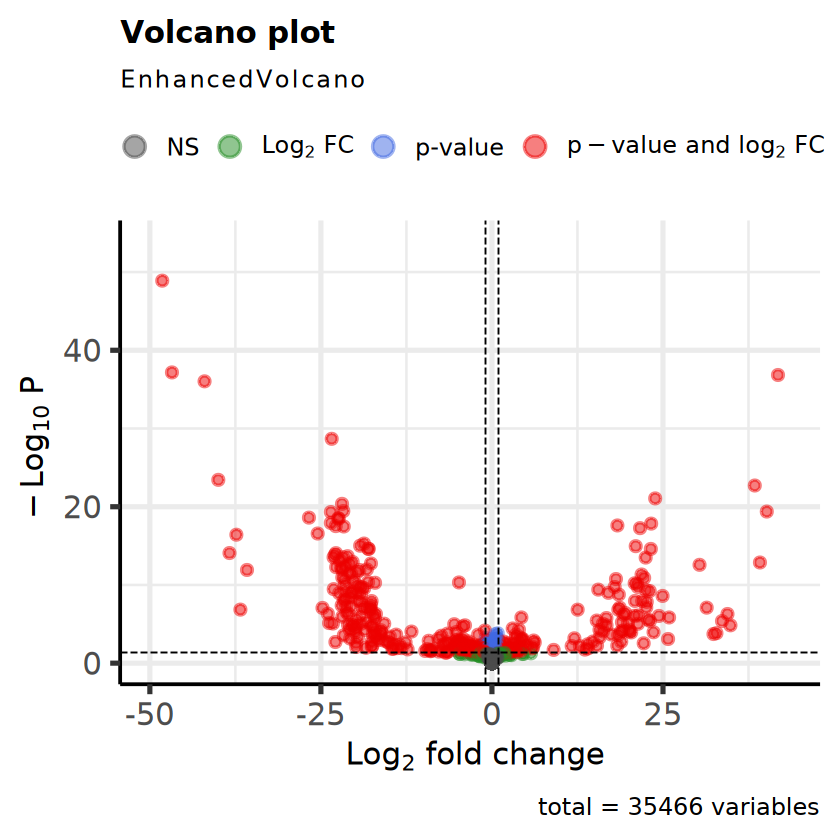

In [56]:
res.bh.ch <- lfcShrink(dds.noOutliers, contrast= c('complete_trtmt', 'both.hypoxic', 'control.hypoxic'), # CH is the "control"
                     type = 'ashr',
                      lfcThreshold = 1)

summary(res.bh.ch)

EnhancedVolcano(res.bh.ch,
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

res.bh.ch <- merge(res.bh.ch, counts(dds.noOutliers, normalized=TRUE), by="row.names", sort=FALSE) # add normalized counts to DESeq results
names(res.bh.ch)[1] <- 'Gene'

head(res.bh.ch)

In [57]:
write.csv(res.bh.ch, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_res_files/all_genes/bh_ch.csv', row.names = FALSE)

**CW vs. BW**

using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041

computing FSOS 'false sign or small' s-values (T=1)




out of 35396 with nonzero total read count
s-value < 0.005
LFC > 1.00 (up)    : 45, 0.13%
LFC < -1.00 (down) : 101, 0.29%



Gene         baseMean    log2FoldChange lfcSE      stat        pvalue   
1 LOC111116054   9.0629842 -0.001689459   0.04148253 -1.06234617 0.2880786
2 LOC111126949 539.2853993  0.000098165   0.02901431  0.04183174 0.9666328
3 LOC111110729 114.0070007 -0.001160466   0.02865097 -0.34857610 0.7274076
4 LOC111112434   6.9517032  0.001031736   0.04420712  0.69179604 0.4890654
5 LOC111120752 429.0263780 -0.003833397   0.02989596 -1.31019272 0.1901306
6 LOC111128944   0.1088474 -0.002902644   0.44265042 -0.12235694 0.9026163
  padj      svalue    B1_B1_O01  B1_W5_O50  ⋯ W4_W5_G56  W5_B2_G21  W5_C4_G45
1 0.9542280 0.9801334   1.875059   5.965799 ⋯   4.336105   2.452846  11.19491
2 1.0000000 0.9901729 829.713451 474.281013 ⋯ 230.897604 544.531781 506.25864
3 1.0000000 0.9911611  60.001877  92.469883 ⋯ 128.999131  62.138762  87.07151
4 0.9933954 0.9805064  10.312823   1.988600 ⋯   6.504158   0.000000  13.68267
5 0.9009458 0.9889714 337.510556 334.084739 ⋯ 421.686235 286.165350 446.55246
6        NA 0.9319773   0.000000   0.000000 ⋯   0.000000   0.000000   0.00000
  W5_H4_G46  W5_W2_G22  W6_B3_G35  W6_B4_G48  W6_H6_G71 W6_W3_G36  W6_W4_G48
1   2.006592   7.359253   5.277065   2.300668  21.05700   1.075999   0.0000 
2 742.439160 650.373981 428.497663 480.839693 469.90350 302.355713 636.4963 
3 149.491128 111.308701 121.372491 144.942108 119.69240 136.651870 226.3334 
4   6.019777   3.679626   0.000000   2.300668  17.73221   8.607992   0.0000 
5 346.137176 402.919100 293.404804 330.145914 461.03739 358.307660 456.9172 
6   0.000000   0.000000   0.000000   0.000000   0.00000   0.000000   0.0000

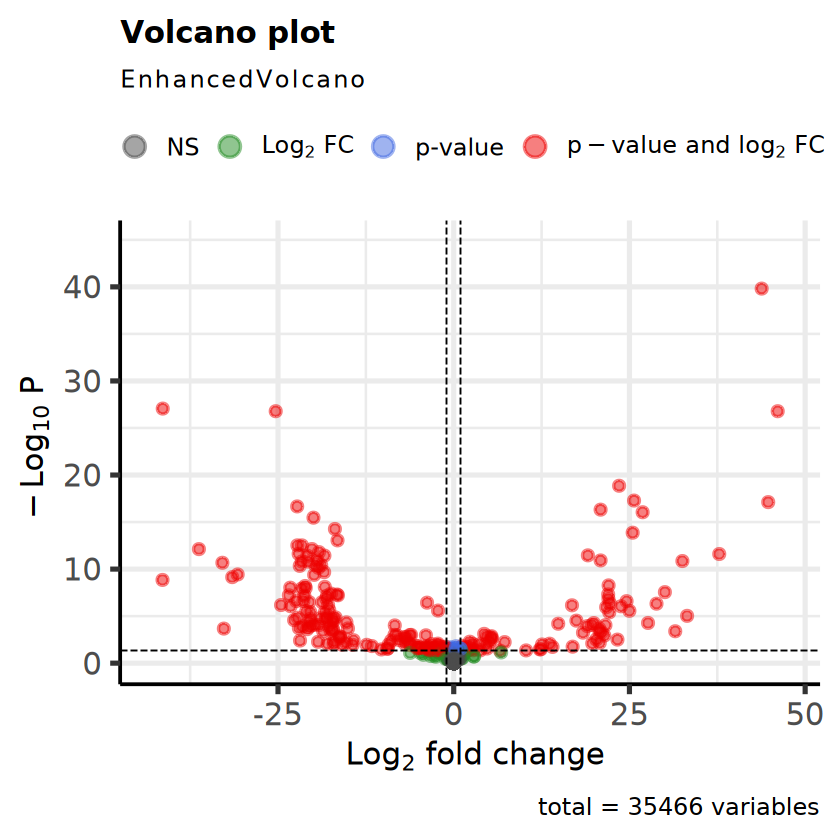

In [58]:
res.bw.cw <- lfcShrink(dds.noOutliers, contrast= c('complete_trtmt', 'both.warm', 'control.warm'), # CW is the "control"
                     type = 'ashr',
                      lfcThreshold = 1)

summary(res.bw.cw)

EnhancedVolcano(res.bw.cw,
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

res.bw.cw <- merge(res.bw.cw, counts(dds.noOutliers, normalized=TRUE), by="row.names", sort=FALSE) # add normalized counts to DESeq results
names(res.bw.cw)[1] <- 'Gene'

head(res.bw.cw)

In [59]:
write.csv(res.bw.cw, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_res_files/all_genes/bw_cw.csv', row.names = FALSE)

#### 5C. Semi-matched priming: in context of later *multiple* stress
- CB vs. WB
- CB vs. HB

**CB vs. WB**

using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041

computing FSOS 'false sign or small' s-values (T=1)




out of 35396 with nonzero total read count
s-value < 0.005
LFC > 1.00 (up)    : 124, 0.35%
LFC < -1.00 (down) : 53, 0.15%



Gene         baseMean    log2FoldChange lfcSE      stat       pvalue   
1 LOC111116054   9.0629842 -0.0150614827  0.15438953 -1.5752798 0.1151919
2 LOC111126949 539.2853993  0.0005521113  0.02100453  0.5837762 0.5593709
3 LOC111110729 114.0070007  0.0019490339  0.03108504  1.5429108 0.1228524
4 LOC111112434   6.9517032 -0.0007618763  0.07674322 -0.1391706 0.8893154
5 LOC111120752 429.0263780  0.0003508953  0.01527745  0.5329586 0.5940622
6 LOC111128944   0.1088474  0.0040733768  0.52056883  0.1236724 0.9015747
  padj      svalue    B1_B1_O01  B1_W5_O50  ⋯ W4_W5_G56  W5_B2_G21  W5_C4_G45
1 0.7288680 0.9050404   1.875059   5.965799 ⋯   4.336105   2.452846  11.19491
2 0.9721690 0.9753269 829.713451 474.281013 ⋯ 230.897604 544.531781 506.25864
3 0.7401825 0.9754867  60.001877  92.469883 ⋯ 128.999131  62.138762  87.07151
4 0.9985610 0.9652399  10.312823   1.988600 ⋯   6.504158   0.000000  13.68267
5 0.9764067 0.9776387 337.510556 334.084739 ⋯ 421.686235 286.165350 446.55246
6        NA 0.9146878   0.000000   0.000000 ⋯   0.000000   0.000000   0.00000
  W5_H4_G46  W5_W2_G22  W6_B3_G35  W6_B4_G48  W6_H6_G71 W6_W3_G36  W6_W4_G48
1   2.006592   7.359253   5.277065   2.300668  21.05700   1.075999   0.0000 
2 742.439160 650.373981 428.497663 480.839693 469.90350 302.355713 636.4963 
3 149.491128 111.308701 121.372491 144.942108 119.69240 136.651870 226.3334 
4   6.019777   3.679626   0.000000   2.300668  17.73221   8.607992   0.0000 
5 346.137176 402.919100 293.404804 330.145914 461.03739 358.307660 456.9172 
6   0.000000   0.000000   0.000000   0.000000   0.00000   0.000000   0.0000

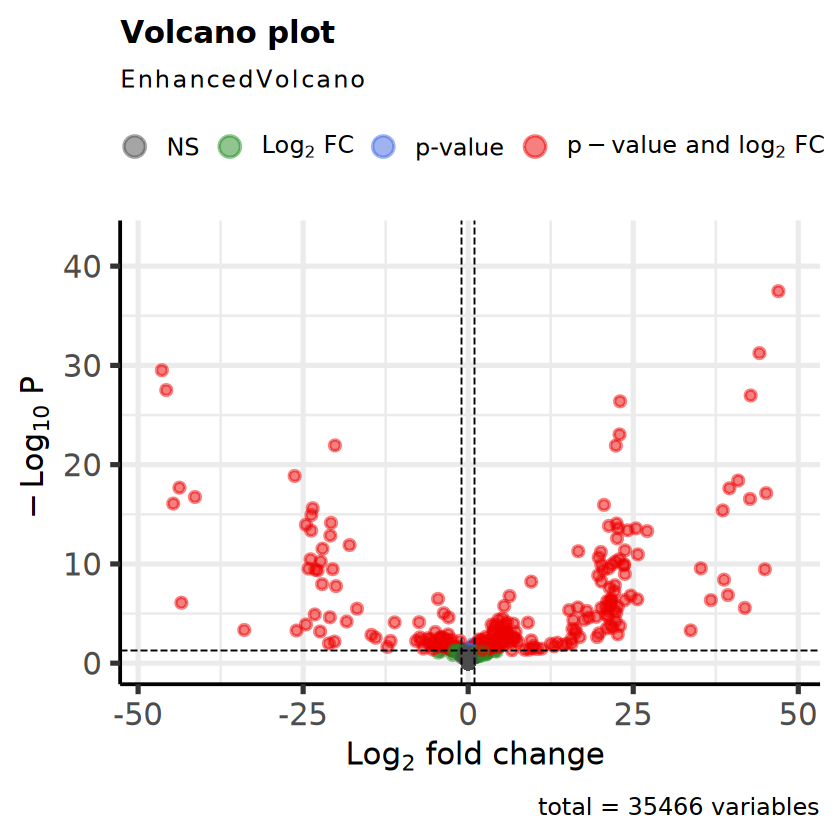

In [60]:
res.wb.cb <- lfcShrink(dds.noOutliers, contrast = c('complete_trtmt', 'warm.both', 'control.both'), # CB is the "control"
                       type = 'ashr',
                      lfcThreshold = 1)

summary(res.wb.cb)

EnhancedVolcano(res.wb.cb,
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

res.wb.cb <- merge(res.wb.cb, counts(dds.noOutliers, normalized=TRUE), by="row.names", sort=FALSE) # add normalized counts to DESeq results
names(res.wb.cb)[1] <- 'Gene'

head(res.wb.cb)

In [61]:
write.csv(res.wb.cb, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_res_files/all_genes/wb_cb.csv', row.names = FALSE)

**CB vs. HB**

using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041

computing FSOS 'false sign or small' s-values (T=1)




out of 35396 with nonzero total read count
s-value < 0.005
LFC > 1.00 (up)    : 75, 0.21%
LFC < -1.00 (down) : 50, 0.14%



Gene         baseMean    log2FoldChange lfcSE       stat       pvalue    padj
1 LOC111116054   9.0629842 -2.606256e-04  0.019236058 -0.8324653 0.4051464 1   
2 LOC111126949 539.2853993  4.709093e-05  0.007405231  0.3174545 0.7508988 1   
3 LOC111110729 114.0070007 -2.334946e-04  0.008036832 -1.2191321 0.2227941 1   
4 LOC111112434   6.9517032 -2.083427e-03  0.070453661 -1.5311654 0.1257285 1   
5 LOC111120752 429.0263780  1.993864e-04  0.008369690  1.1097351 0.2671132 1   
6 LOC111128944   0.1088474  0.000000e+00  0.372284361  0.0000000 1.0000000 1   
  svalue    B1_B1_O01  B1_W5_O50  ⋯ W4_W5_G56  W5_B2_G21  W5_C4_G45 W5_H4_G46 
1 0.9867059   1.875059   5.965799 ⋯   4.336105   2.452846  11.19491   2.006592
2 0.9921366 829.713451 474.281013 ⋯ 230.897604 544.531781 506.25864 742.439160
3 0.9923250  60.001877  92.469883 ⋯ 128.999131  62.138762  87.07151 149.491128
4 0.9617069  10.312823   1.988600 ⋯   6.504158   0.000000  13.68267   6.019777
5 0.9918607 337.510556 334.084739 ⋯ 421.686235 286.165350 446.55246 346.137176
6 0.9442443   0.000000   0.000000 ⋯   0.000000   0.000000   0.00000   0.000000
  W5_W2_G22  W6_B3_G35  W6_B4_G48  W6_H6_G71 W6_W3_G36  W6_W4_G48
1   7.359253   5.277065   2.300668  21.05700   1.075999   0.0000 
2 650.373981 428.497663 480.839693 469.90350 302.355713 636.4963 
3 111.308701 121.372491 144.942108 119.69240 136.651870 226.3334 
4   3.679626   0.000000   2.300668  17.73221   8.607992   0.0000 
5 402.919100 293.404804 330.145914 461.03739 358.307660 456.9172 
6   0.000000   0.000000   0.000000   0.00000   0.000000   0.0000

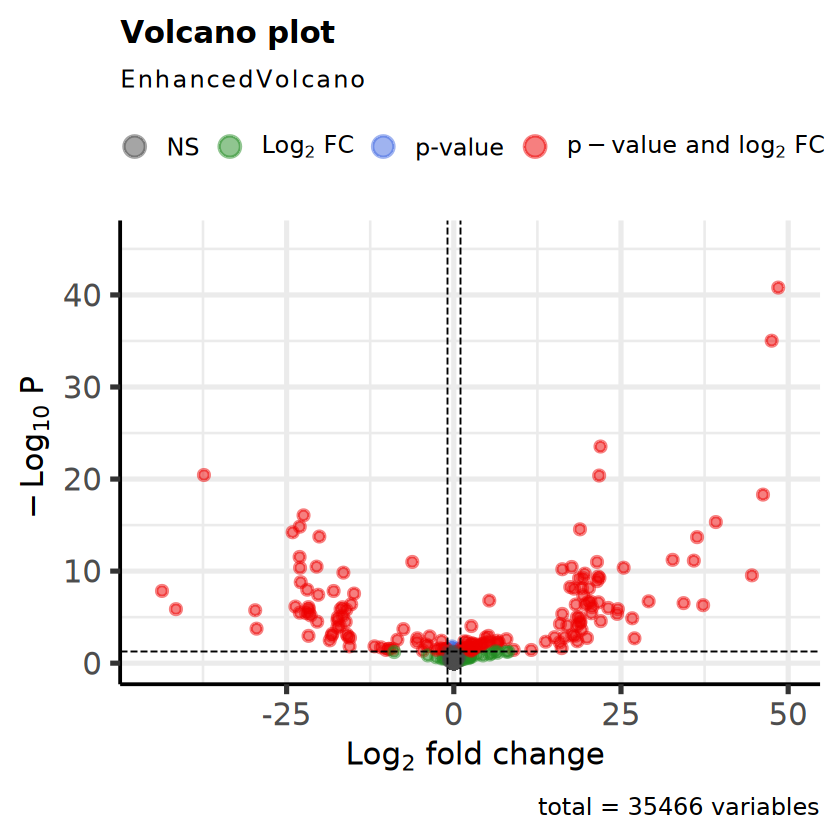

In [62]:
res.hb.cb <- lfcShrink(dds.noOutliers, contrast = c('complete_trtmt', 'hypoxic.both', 'control.both'), # CB is the "control"
                       type = 'ashr',
                      lfcThreshold = 1)

summary(res.hb.cb)

EnhancedVolcano(res.hb.cb,
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

res.hb.cb <- merge(res.hb.cb, counts(dds.noOutliers, normalized=TRUE), by="row.names", sort=FALSE) # add normalized counts to DESeq results
names(res.hb.cb)[1] <- 'Gene'

head(res.hb.cb)

In [63]:
write.csv(res.hb.cb, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_res_files/all_genes/hb_cb.csv', row.names = FALSE)

### 6. Effect of initial exposure on subsequent response to stress
Oysters all experience the same early stressor, but either return to that stressor or experience control conditions
- HC vs. HH
- WC vs. WW
- BB vs. BC

**HC vs. HH**

using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041

computing FSOS 'false sign or small' s-values (T=1)




out of 35396 with nonzero total read count
s-value < 0.005
LFC > 1.00 (up)    : 158, 0.45%
LFC < -1.00 (down) : 79, 0.22%



Gene         baseMean    log2FoldChange lfcSE      stat      pvalue   
1 LOC111116054   9.0629842 0.004774264    0.08057159 0.6097239 0.5420447
2 LOC111126949 539.2853993 0.020744525    0.07818391 1.3701982 0.1706250
3 LOC111110729 114.0070007 0.012263142    0.07261191 0.6130737 0.5398276
4 LOC111112434   6.9517032 0.004845443    0.08873729 0.7525244 0.4517358
5 LOC111120752 429.0263780 0.013332555    0.07386046 0.7463821 0.4554366
6 LOC111128944   0.1088474 0.000000000    0.55527996 0.0000000 1.0000000
  padj      svalue    B1_B1_O01  B1_W5_O50  ⋯ W4_W5_G56  W5_B2_G21  W5_C4_G45
1 1.0000000 0.9778155   1.875059   5.965799 ⋯   4.336105   2.452846  11.19491
2 0.8958423 0.9809920 829.713451 474.281013 ⋯ 230.897604 544.531781 506.25864
3 1.0000000 0.9867567  60.001877  92.469883 ⋯ 128.999131  62.138762  87.07151
4 1.0000000 0.9710872  10.312823   1.988600 ⋯   6.504158   0.000000  13.68267
5 1.0000000 0.9856894 337.510556 334.084739 ⋯ 421.686235 286.165350 446.55246
6 1.0000000 0.9124272   0.000000   0.000000 ⋯   0.000000   0.000000   0.00000
  W5_H4_G46  W5_W2_G22  W6_B3_G35  W6_B4_G48  W6_H6_G71 W6_W3_G36  W6_W4_G48
1   2.006592   7.359253   5.277065   2.300668  21.05700   1.075999   0.0000 
2 742.439160 650.373981 428.497663 480.839693 469.90350 302.355713 636.4963 
3 149.491128 111.308701 121.372491 144.942108 119.69240 136.651870 226.3334 
4   6.019777   3.679626   0.000000   2.300668  17.73221   8.607992   0.0000 
5 346.137176 402.919100 293.404804 330.145914 461.03739 358.307660 456.9172 
6   0.000000   0.000000   0.000000   0.000000   0.00000   0.000000   0.0000

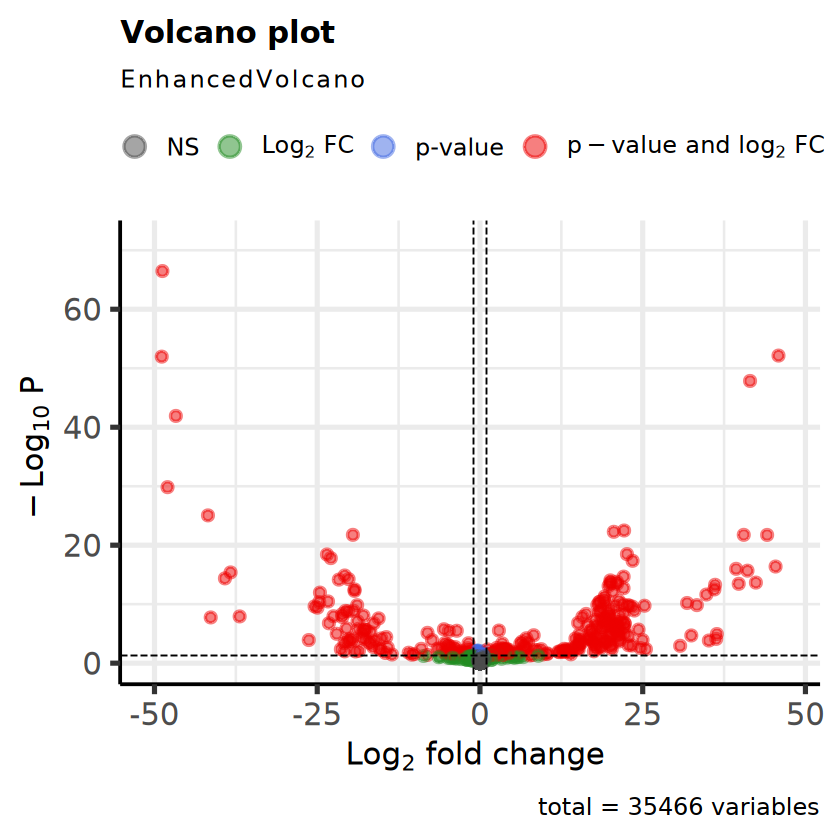

In [64]:
res.hc.hh <- lfcShrink(dds.noOutliers, contrast = c('complete_trtmt', 'hypoxic.control', 'hypoxic.hypoxic'), # HH is the "control"
                     type = 'ashr',
                      lfcThreshold = 1)

summary(res.hc.hh)

EnhancedVolcano(res.hc.hh,
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

res.hc.hh <- merge(res.hc.hh, counts(dds.noOutliers, normalized=TRUE), by="row.names", sort=FALSE) # add normalized counts to DESeq results
names(res.hc.hh)[1] <- 'Gene'

head(res.hc.hh)

In [65]:
write.csv(res.hc.hh, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_res_files/all_genes/hc_hh.csv', row.names = FALSE)

**WC vs. WW**

using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041

computing FSOS 'false sign or small' s-values (T=1)




out of 35396 with nonzero total read count
s-value < 0.005
LFC > 1.00 (up)    : 46, 0.13%
LFC < -1.00 (down) : 61, 0.17%



Gene         baseMean    log2FoldChange lfcSE     stat       pvalue    
1 LOC111116054   9.0629842  0.071190384   0.2061759  2.1203492 0.03397661
2 LOC111126949 539.2853993 -0.010292001   0.1390675 -0.1911883 0.84837807
3 LOC111110729 114.0070007 -0.097760585   0.1307282 -1.4566532 0.14521215
4 LOC111112434   6.9517032  0.015653864   0.1580097  0.7014961 0.48299348
5 LOC111120752 429.0263780 -0.007878439   0.1330459 -0.1280906 0.89807727
6 LOC111128944   0.1088474 -0.004761685   0.4128858 -0.2356570 0.81369884
  padj      svalue    B1_B1_O01  B1_W5_O50  ⋯ W4_W5_G56  W5_B2_G21  W5_C4_G45
1 0.4838416 0.8878103   1.875059   5.965799 ⋯   4.336105   2.452846  11.19491
2 1.0000000 0.9910032 829.713451 474.281013 ⋯ 230.897604 544.531781 506.25864
3 0.7232793 0.9908022  60.001877  92.469883 ⋯ 128.999131  62.138762  87.07151
4 0.9457917 0.9824049  10.312823   1.988600 ⋯   6.504158   0.000000  13.68267
5 1.0000000 0.9917253 337.510556 334.084739 ⋯ 421.686235 286.165350 446.55246
6 1.0000000 0.9515556   0.000000   0.000000 ⋯   0.000000   0.000000   0.00000
  W5_H4_G46  W5_W2_G22  W6_B3_G35  W6_B4_G48  W6_H6_G71 W6_W3_G36  W6_W4_G48
1   2.006592   7.359253   5.277065   2.300668  21.05700   1.075999   0.0000 
2 742.439160 650.373981 428.497663 480.839693 469.90350 302.355713 636.4963 
3 149.491128 111.308701 121.372491 144.942108 119.69240 136.651870 226.3334 
4   6.019777   3.679626   0.000000   2.300668  17.73221   8.607992   0.0000 
5 346.137176 402.919100 293.404804 330.145914 461.03739 358.307660 456.9172 
6   0.000000   0.000000   0.000000   0.000000   0.00000   0.000000   0.0000

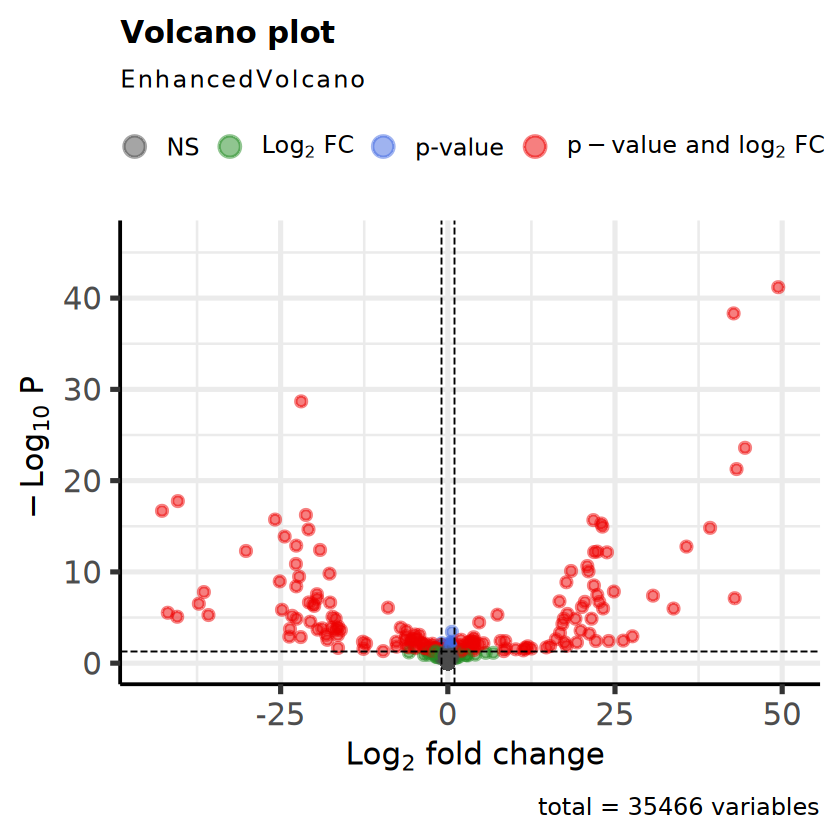

In [66]:
res.wc.ww <- lfcShrink(dds.noOutliers, contrast = c('complete_trtmt', 'warm.control', 'warm.warm'), # WW is the "control"
                     type = 'ashr',
                      lfcThreshold = 1)

summary(res.wc.ww)

EnhancedVolcano(res.wc.ww,
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

res.wc.ww <- merge(res.wc.ww, counts(dds.noOutliers, normalized=TRUE), by="row.names", sort=FALSE) # add normalized counts to DESeq results
names(res.wc.ww)[1] <- 'Gene'

head(res.wc.ww)

In [67]:
write.csv(res.wc.ww, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_res_files/all_genes/wc_ww.csv', row.names = FALSE)

**BC vs. BB**

using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041

computing FSOS 'false sign or small' s-values (T=1)




out of 35396 with nonzero total read count
s-value < 0.005
LFC > 1.00 (up)    : 25, 0.071%
LFC < -1.00 (down) : 144, 0.41%



Gene         baseMean    log2FoldChange lfcSE      stat         pvalue   
1 LOC111116054   9.0629842  0.012280097   0.10873166  0.976530293 0.3288017
2 LOC111126949 539.2853993 -0.016724293   0.08977881 -0.832992954 0.4048487
3 LOC111110729 114.0070007  0.033620214   0.09002440  1.285031844 0.1987812
4 LOC111112434   6.9517032 -0.007123823   0.11296739 -0.677165998 0.4983006
5 LOC111120752 429.0263780  0.018912916   0.08595646  0.823876129 0.4100099
6 LOC111128944   0.1088474 -0.000345508   0.57531366 -0.008932799 0.9928728
  padj      svalue    B1_B1_O01  B1_W5_O50  ⋯ W4_W5_G56  W5_B2_G21  W5_C4_G45
1 0.9087430 0.9710944   1.875059   5.965799 ⋯   4.336105   2.452846  11.19491
2 0.9372601 0.9830196 829.713451 474.281013 ⋯ 230.897604 544.531781 506.25864
3 0.8236597 0.9846736  60.001877  92.469883 ⋯ 128.999131  62.138762  87.07151
4 0.9610270 0.9710187  10.312823   1.988600 ⋯   6.504158   0.000000  13.68267
5 0.9391285 0.9848333 337.510556 334.084739 ⋯ 421.686235 286.165350 446.55246
6        NA 0.9343285   0.000000   0.000000 ⋯   0.000000   0.000000   0.00000
  W5_H4_G46  W5_W2_G22  W6_B3_G35  W6_B4_G48  W6_H6_G71 W6_W3_G36  W6_W4_G48
1   2.006592   7.359253   5.277065   2.300668  21.05700   1.075999   0.0000 
2 742.439160 650.373981 428.497663 480.839693 469.90350 302.355713 636.4963 
3 149.491128 111.308701 121.372491 144.942108 119.69240 136.651870 226.3334 
4   6.019777   3.679626   0.000000   2.300668  17.73221   8.607992   0.0000 
5 346.137176 402.919100 293.404804 330.145914 461.03739 358.307660 456.9172 
6   0.000000   0.000000   0.000000   0.000000   0.00000   0.000000   0.0000

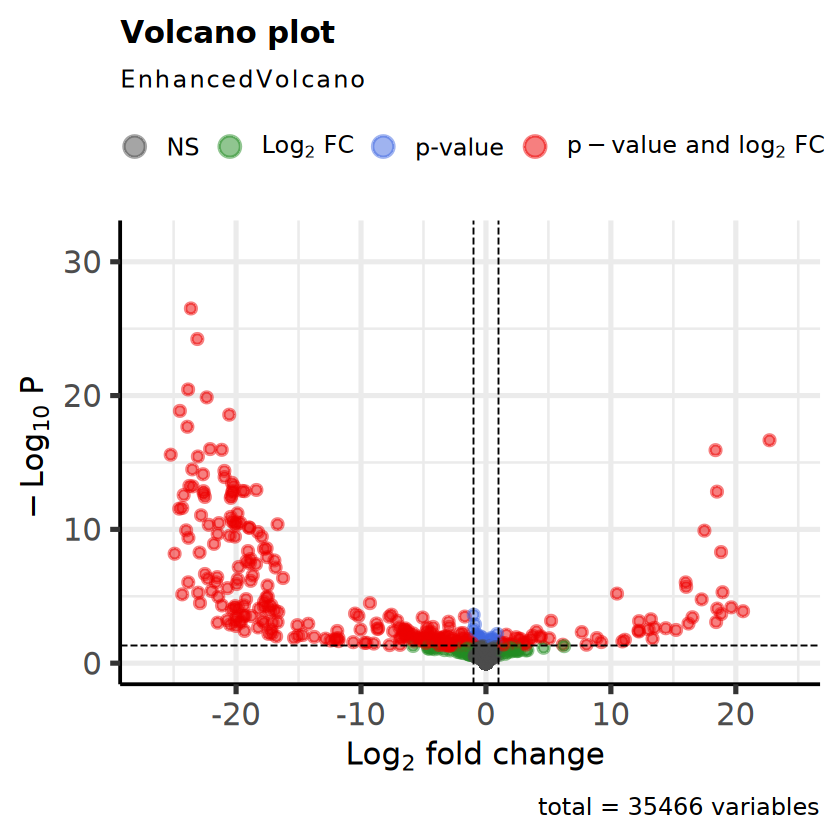

In [68]:
res.bc.bb <- lfcShrink(dds.noOutliers, coef = 'complete_trtmt_both.control_vs_both.both', # BB is the "control"
                     type = 'ashr',
                      lfcThreshold = 1)

summary(res.bc.bb)

EnhancedVolcano(res.bc.bb,
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

res.bc.bb <- merge(res.bc.bb, counts(dds.noOutliers, normalized=TRUE), by="row.names", sort=FALSE) # add normalized counts to DESeq results
names(res.bc.bb)[1] <- 'Gene'

head(res.bc.bb)

In [69]:
write.csv(res.bc.bb, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_res_files/all_genes/bc_bb.csv', row.names = FALSE)

### 7. Effect of initial single/multiple stress on response in ...
Is it better to be primed with a single stressor or multiple stressor, depending on the context of the future enviornment (single/multiple stressor)?

#### 7A. ...later *single* stress
Oyster is primed with either multiple or a single stressors, and then experiences only a sinlge stressor later
- BH vs. HH
- BW vs. WW

**BH vs. HH**

using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041

computing FSOS 'false sign or small' s-values (T=1)




out of 35396 with nonzero total read count
s-value < 0.005
LFC > 1.00 (up)    : 146, 0.41%
LFC < -1.00 (down) : 120, 0.34%



Gene         baseMean    log2FoldChange lfcSE     stat      pvalue    
1 LOC111116054   9.0629842 0.07447715     0.2146328 1.4040391 0.16030720
2 LOC111126949 539.2853993 0.16248283     0.1969964 1.8133428 0.06977896
3 LOC111110729 114.0070007 0.06239498     0.1581797 0.6784526 0.49748480
4 LOC111112434   6.9517032 0.10390072     0.3142477 2.1364778 0.03264049
5 LOC111120752 429.0263780 0.20284536     0.1892907 2.0371892 0.04163109
6 LOC111128944   0.1088474 0.00000000     0.6119441 0.0000000 1.00000000
  padj      svalue    B1_B1_O01  B1_W5_O50  ⋯ W4_W5_G56  W5_B2_G21  W5_C4_G45
1 0.6505765 0.9578439   1.875059   5.965799 ⋯   4.336105   2.452846  11.19491
2 0.4846405 0.9742988 829.713451 474.281013 ⋯ 230.897604 544.531781 506.25864
3 0.8952513 0.9854354  60.001877  92.469883 ⋯ 128.999131  62.138762  87.07151
4 0.3563528 0.7813331  10.312823   1.988600 ⋯   6.504158   0.000000  13.68267
5 0.3967872 0.9777348 337.510556 334.084739 ⋯ 421.686235 286.165350 446.55246
6        NA 0.9162353   0.000000   0.000000 ⋯   0.000000   0.000000   0.00000
  W5_H4_G46  W5_W2_G22  W6_B3_G35  W6_B4_G48  W6_H6_G71 W6_W3_G36  W6_W4_G48
1   2.006592   7.359253   5.277065   2.300668  21.05700   1.075999   0.0000 
2 742.439160 650.373981 428.497663 480.839693 469.90350 302.355713 636.4963 
3 149.491128 111.308701 121.372491 144.942108 119.69240 136.651870 226.3334 
4   6.019777   3.679626   0.000000   2.300668  17.73221   8.607992   0.0000 
5 346.137176 402.919100 293.404804 330.145914 461.03739 358.307660 456.9172 
6   0.000000   0.000000   0.000000   0.000000   0.00000   0.000000   0.0000

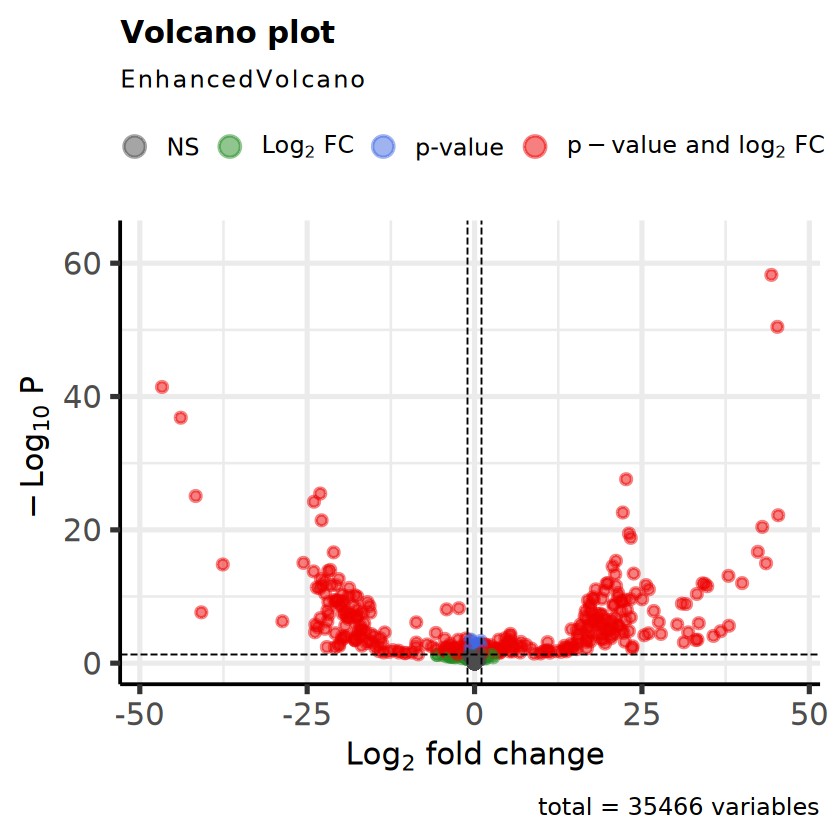

In [70]:
res.hh.bh <- lfcShrink(dds.noOutliers, contrast= c('complete_trtmt', 'both.hypoxic', 'hypoxic.hypoxic'), # HH is the "control"
                     type = 'ashr',
                      lfcThreshold = 1)

summary(res.hh.bh)

EnhancedVolcano(res.hh.bh,
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

res.hh.bh <- merge(res.hh.bh, counts(dds.noOutliers, normalized=TRUE), by="row.names", sort=FALSE) # add normalized counts to DESeq results
names(res.hh.bh)[1] <- 'Gene'

head(res.hh.bh)

In [71]:
write.csv(res.hh.bh, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_res_files/all_genes/bh_hh.csv', row.names = FALSE)

**BW vs. WW**

using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041

computing FSOS 'false sign or small' s-values (T=1)




out of 35396 with nonzero total read count
s-value < 0.005
LFC > 1.00 (up)    : 40, 0.11%
LFC < -1.00 (down) : 104, 0.29%



Gene         baseMean    log2FoldChange lfcSE      stat       pvalue    
1 LOC111116054   9.0629842  0.002250397   0.07132198  0.3608133 0.71823900
2 LOC111126949 539.2853993  0.011581328   0.06805633  0.9041305 0.36592623
3 LOC111110729 114.0070007 -0.003230407   0.06623574 -0.1811392 0.85625835
4 LOC111112434   6.9517032  0.006652912   0.08958934  1.1652697 0.24390986
5 LOC111120752 429.0263780 -0.028801959   0.06912399 -1.8287385 0.06743879
6 LOC111128944   0.1088474 -0.005543383   0.45007211 -0.2325591 0.81610380
  padj      svalue    B1_B1_O01  B1_W5_O50  ⋯ W4_W5_G56  W5_B2_G21  W5_C4_G45
1 1.0000000 0.9853953   1.875059   5.965799 ⋯   4.336105   2.452846  11.19491
2 1.0000000 0.9885774 829.713451 474.281013 ⋯ 230.897604 544.531781 506.25864
3 1.0000000 0.9912110  60.001877  92.469883 ⋯ 128.999131  62.138762  87.07151
4 0.9523363 0.9711893  10.312823   1.988600 ⋯   6.504158   0.000000  13.68267
5 0.7348307 0.9869527 337.510556 334.084739 ⋯ 421.686235 286.165350 446.55246
6 1.0000000 0.9264407   0.000000   0.000000 ⋯   0.000000   0.000000   0.00000
  W5_H4_G46  W5_W2_G22  W6_B3_G35  W6_B4_G48  W6_H6_G71 W6_W3_G36  W6_W4_G48
1   2.006592   7.359253   5.277065   2.300668  21.05700   1.075999   0.0000 
2 742.439160 650.373981 428.497663 480.839693 469.90350 302.355713 636.4963 
3 149.491128 111.308701 121.372491 144.942108 119.69240 136.651870 226.3334 
4   6.019777   3.679626   0.000000   2.300668  17.73221   8.607992   0.0000 
5 346.137176 402.919100 293.404804 330.145914 461.03739 358.307660 456.9172 
6   0.000000   0.000000   0.000000   0.000000   0.00000   0.000000   0.0000

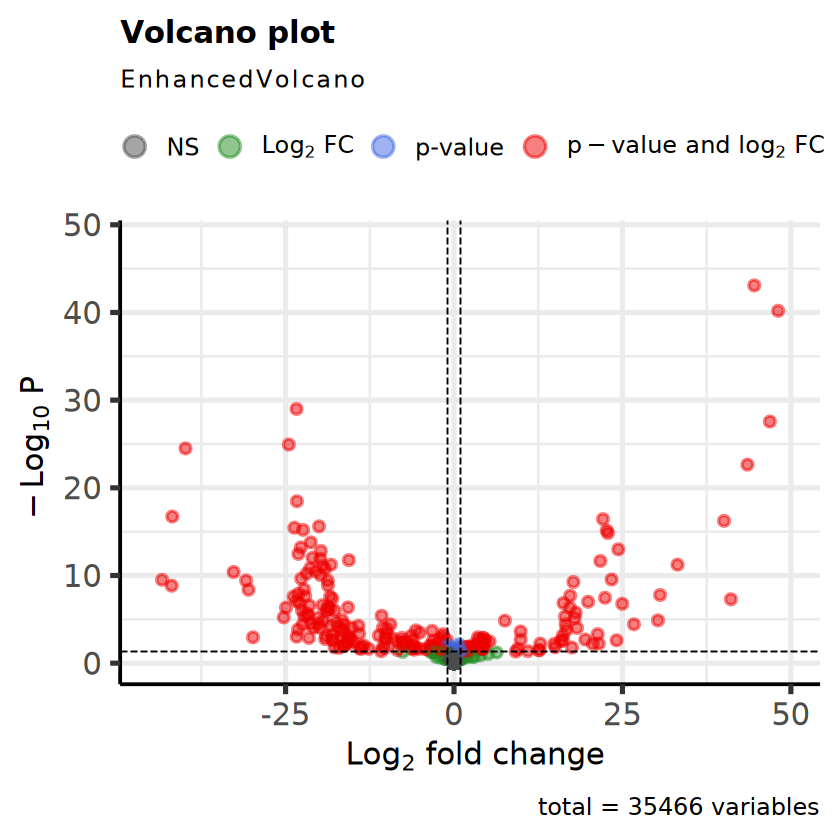

In [72]:
res.bw.ww <- lfcShrink(dds.noOutliers, contrast= c('complete_trtmt', 'both.warm', 'warm.warm'), # WW is the "control"
                     type = 'ashr',
                      lfcThreshold = 1)

summary(res.bw.ww)

EnhancedVolcano(res.bw.ww,
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

res.bw.ww <- merge(res.bw.ww, counts(dds.noOutliers, normalized=TRUE), by="row.names", sort=FALSE) # add normalized counts to DESeq results
names(res.bw.ww)[1] <- 'Gene'

head(res.bw.ww)

In [73]:
write.csv(res.bw.ww, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_res_files/all_genes/bw_ww.csv', row.names = FALSE)

#### 7B. ...later *multiple* stressors
Oyster is primed with either multiple or a single stressors, and then experiences multiple stressors later
- HB vs. BB
- WB vs. BB

**HB vs. BB**

using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041

computing FSOS 'false sign or small' s-values (T=1)




out of 35396 with nonzero total read count
s-value < 0.005
LFC > 1.00 (up)    : 37, 0.1%
LFC < -1.00 (down) : 73, 0.21%



Gene         baseMean    log2FoldChange lfcSE       stat        pvalue    
1 LOC111116054   9.0629842  2.166590e-03  0.059070225  1.54760668 0.12171702
2 LOC111126949 539.2853993  4.795701e-05  0.009247916  0.20445714 0.83799628
3 LOC111110729 114.0070007  1.275058e-04  0.008174011  0.50857236 0.61105201
4 LOC111112434   6.9517032 -9.504635e-03  0.156920973 -1.94156367 0.05218994
5 LOC111120752 429.0263780  3.952222e-04  0.012358120  1.27731021 0.20149275
6 LOC111128944   0.1088474  5.468961e-04  0.406325832  0.02703977 0.97842801
  padj      svalue    B1_B1_O01  B1_W5_O50  ⋯ W4_W5_G56  W5_B2_G21  W5_C4_G45
1 0.9995702 0.9710492   1.875059   5.965799 ⋯   4.336105   2.452846  11.19491
2 0.9998514 0.9915639 829.713451 474.281013 ⋯ 230.897604 544.531781 506.25864
3 0.9998514 0.9923772  60.001877  92.469883 ⋯ 128.999131  62.138762  87.07151
4 0.8395385 0.8873165  10.312823   1.988600 ⋯   6.504158   0.000000  13.68267
5 0.9998514 0.9908032 337.510556 334.084739 ⋯ 421.686235 286.165350 446.55246
6 0.9998514 0.9570694   0.000000   0.000000 ⋯   0.000000   0.000000   0.00000
  W5_H4_G46  W5_W2_G22  W6_B3_G35  W6_B4_G48  W6_H6_G71 W6_W3_G36  W6_W4_G48
1   2.006592   7.359253   5.277065   2.300668  21.05700   1.075999   0.0000 
2 742.439160 650.373981 428.497663 480.839693 469.90350 302.355713 636.4963 
3 149.491128 111.308701 121.372491 144.942108 119.69240 136.651870 226.3334 
4   6.019777   3.679626   0.000000   2.300668  17.73221   8.607992   0.0000 
5 346.137176 402.919100 293.404804 330.145914 461.03739 358.307660 456.9172 
6   0.000000   0.000000   0.000000   0.000000   0.00000   0.000000   0.0000

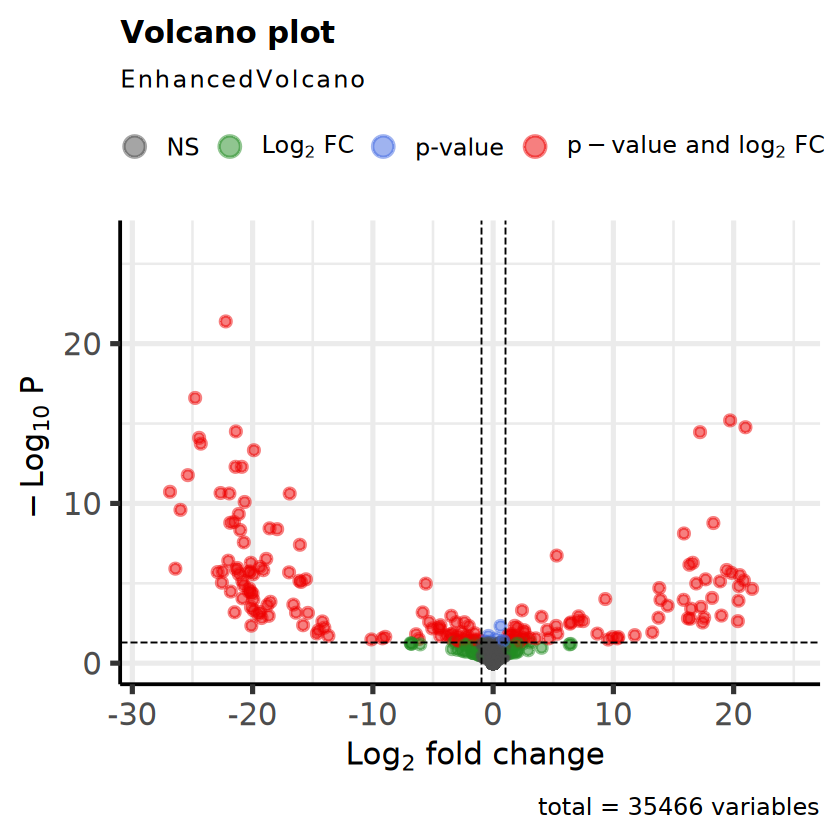

In [74]:
res.hb.bb <- lfcShrink(dds.noOutliers, 
                       coef= 'complete_trtmt_hypoxic.both_vs_both.both', # BB is the "control"
                     type = 'ashr',
                      lfcThreshold = 1)

summary(res.hb.bb)

EnhancedVolcano(res.hb.bb,
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

res.hb.bb <- merge(res.hb.bb, counts(dds.noOutliers, normalized=TRUE), by="row.names", sort=FALSE) # add normalized counts to DESeq results
names(res.hb.bb)[1] <- 'Gene'

head(res.hb.bb)

In [75]:
write.csv(res.hb.bb, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_res_files/all_genes/hb_bb.csv', row.names = FALSE)

**WB vs. BB**

using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041

computing FSOS 'false sign or small' s-values (T=1)




out of 35396 with nonzero total read count
s-value < 0.005
LFC > 1.00 (up)    : 29, 0.082%
LFC < -1.00 (down) : 42, 0.12%



Gene         baseMean    log2FoldChange lfcSE       stat       pvalue     
1 LOC111116054   9.0629842  0.0007591567  0.034238388  0.8086034 0.418743303
2 LOC111126949 539.2853993  0.0001130530  0.009958649  0.4707830 0.637795734
3 LOC111110729 114.0070007  0.0468448779  0.197719768  3.2754483 0.001054944
4 LOC111112434   6.9517032 -0.0007415000  0.042106498 -0.5630216 0.573420142
5 LOC111120752 429.0263780  0.0001507627  0.008915123  0.7004777 0.483629015
6 LOC111128944   0.1088474  0.0021605976  0.367941858  0.1317838 0.895155307
  padj      svalue    B1_B1_O01  B1_W5_O50  ⋯ W4_W5_G56  W5_B2_G21  W5_C4_G45
1 0.9995470 0.9867239   1.875059   5.965799 ⋯   4.336105   2.452846  11.19491
2 0.9995470 0.9918517 829.713451 474.281013 ⋯ 230.897604 544.531781 506.25864
3 0.1346296 0.8029753  60.001877  92.469883 ⋯ 128.999131  62.138762  87.07151
4 0.9995470 0.9859847  10.312823   1.988600 ⋯   6.504158   0.000000  13.68267
5 0.9995470 0.9923487 337.510556 334.084739 ⋯ 421.686235 286.165350 446.55246
6        NA 0.9596564   0.000000   0.000000 ⋯   0.000000   0.000000   0.00000
  W5_H4_G46  W5_W2_G22  W6_B3_G35  W6_B4_G48  W6_H6_G71 W6_W3_G36  W6_W4_G48
1   2.006592   7.359253   5.277065   2.300668  21.05700   1.075999   0.0000 
2 742.439160 650.373981 428.497663 480.839693 469.90350 302.355713 636.4963 
3 149.491128 111.308701 121.372491 144.942108 119.69240 136.651870 226.3334 
4   6.019777   3.679626   0.000000   2.300668  17.73221   8.607992   0.0000 
5 346.137176 402.919100 293.404804 330.145914 461.03739 358.307660 456.9172 
6   0.000000   0.000000   0.000000   0.000000   0.00000   0.000000   0.0000

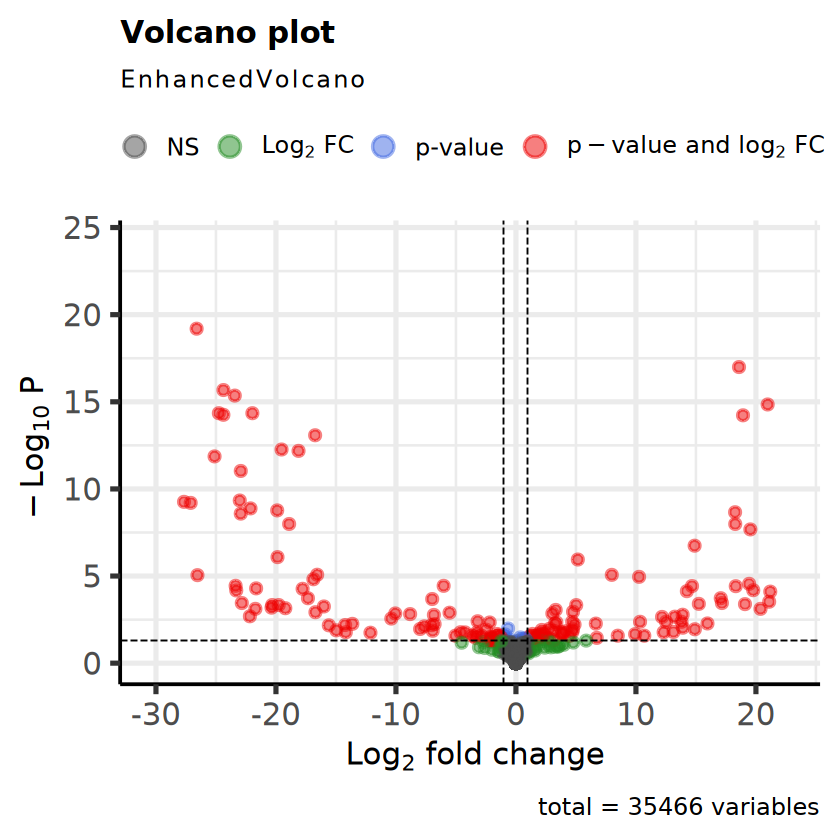

In [76]:
res.wb.bb <- lfcShrink(dds.noOutliers, 
                       coef= 'complete_trtmt_warm.both_vs_both.both', # BB is the "control"
                     type = 'ashr',
                      lfcThreshold = 1)

summary(res.wb.bb)

EnhancedVolcano(res.wb.bb,
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

res.wb.bb <- merge(res.wb.bb, counts(dds.noOutliers, normalized=TRUE), by="row.names", sort=FALSE) # add normalized counts to DESeq results
names(res.wb.bb)[1] <- 'Gene'

head(res.wb.bb)

In [77]:
write.csv(res.wb.bb, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_res_files/all_genes/wb_bb.csv', row.names = FALSE)

### 8. Shared/Unique responses among stressors with ...

#### 8A. ...different *early* stressors
>can compare these with the phase 1 vs. phase 1 DEGs to see if there are similarities
- WC vs. HC: single early stress
- BC vs. HC: mulitple vs. single
- BC vs. WC: multiple vs. single

**WC vs. HC**

using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041

computing FSOS 'false sign or small' s-values (T=1)




out of 35396 with nonzero total read count
s-value < 0.005
LFC > 1.00 (up)    : 81, 0.23%
LFC < -1.00 (down) : 53, 0.15%



Gene         baseMean    log2FoldChange lfcSE       stat        pvalue   
1 LOC111116054   9.0629842  2.118512e-04  0.018201183  0.66039302 0.5090017
2 LOC111126949 539.2853993 -1.407057e-05  0.007403970 -0.09243895 0.9263493
3 LOC111110729 114.0070007  6.710768e-05  0.006640444  0.38732016 0.6985192
4 LOC111112434   6.9517032 -2.744363e-04  0.026422827 -0.52106304 0.6023229
5 LOC111120752 429.0263780 -5.019025e-05  0.006877372 -0.31143725 0.7554682
6 LOC111128944   0.1088474  0.000000e+00  0.400408967  0.00000000 1.0000000
  padj svalue    B1_B1_O01  B1_W5_O50  ⋯ W4_W5_G56  W5_B2_G21  W5_C4_G45
1 1    0.9858683   1.875059   5.965799 ⋯   4.336105   2.452846  11.19491
2 1    0.9910401 829.713451 474.281013 ⋯ 230.897604 544.531781 506.25864
3 1    0.9919854  60.001877  92.469883 ⋯ 128.999131  62.138762  87.07151
4 1    0.9837734  10.312823   1.988600 ⋯   6.504158   0.000000  13.68267
5 1    0.9915985 337.510556 334.084739 ⋯ 421.686235 286.165350 446.55246
6 1    0.9437274   0.000000   0.000000 ⋯   0.000000   0.000000   0.00000
  W5_H4_G46  W5_W2_G22  W6_B3_G35  W6_B4_G48  W6_H6_G71 W6_W3_G36  W6_W4_G48
1   2.006592   7.359253   5.277065   2.300668  21.05700   1.075999   0.0000 
2 742.439160 650.373981 428.497663 480.839693 469.90350 302.355713 636.4963 
3 149.491128 111.308701 121.372491 144.942108 119.69240 136.651870 226.3334 
4   6.019777   3.679626   0.000000   2.300668  17.73221   8.607992   0.0000 
5 346.137176 402.919100 293.404804 330.145914 461.03739 358.307660 456.9172 
6   0.000000   0.000000   0.000000   0.000000   0.00000   0.000000   0.0000

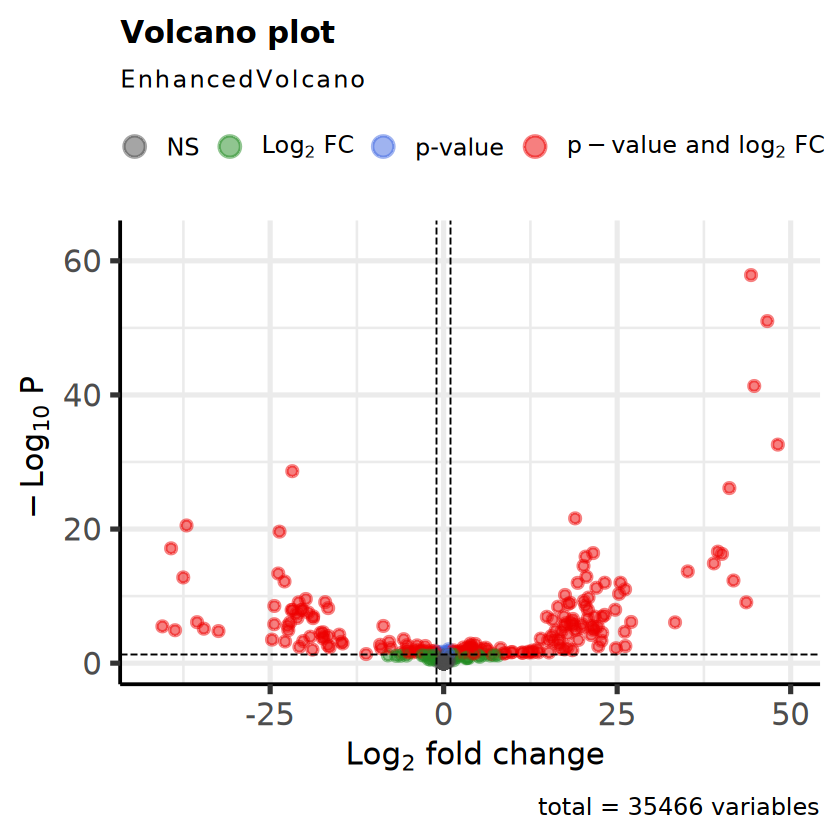

In [78]:
res.wc.hc <- lfcShrink(dds.noOutliers, contrast=c('complete_trtmt', 'warm.control', 'hypoxic.control'), # HC is the "control"
                     type = 'ashr',
                      lfcThreshold = 1)

summary(res.wc.hc)

EnhancedVolcano(res.wc.hc,
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

res.wc.hc <- merge(res.wc.hc, counts(dds.noOutliers, normalized=TRUE), by="row.names", sort=FALSE) # add normalized counts to DESeq results
names(res.wc.hc)[1] <- 'Gene'

head(res.wc.hc)

In [79]:
write.csv(res.wc.hc, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_res_files/all_genes/wc_hc.csv', row.names = FALSE)

**BC vs. HC**

using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041

computing FSOS 'false sign or small' s-values (T=1)




out of 35396 with nonzero total read count
s-value < 0.005
LFC > 1.00 (up)    : 71, 0.2%
LFC < -1.00 (down) : 128, 0.36%



Gene         baseMean    log2FoldChange lfcSE       stat        pvalue   
1 LOC111116054   9.0629842 -4.655259e-06  0.017060186 -0.01274749 0.9898293
2 LOC111126949 539.2853993  7.560595e-05  0.008376834  0.44244984 0.6581637
3 LOC111110729 114.0070007  2.856298e-05  0.006621451  0.17096942 0.8642478
4 LOC111112434   6.9517032 -2.751528e-04  0.029784329 -0.39358140 0.6938901
5 LOC111120752 429.0263780 -7.806724e-05  0.007312654 -0.47085889 0.6377415
6 LOC111128944   0.1088474  0.000000e+00  0.485756319  0.00000000 1.0000000
  padj svalue    B1_B1_O01  B1_W5_O50  ⋯ W4_W5_G56  W5_B2_G21  W5_C4_G45
1 1    0.9846103   1.875059   5.965799 ⋯   4.336105   2.452846  11.19491
2 1    0.9876873 829.713451 474.281013 ⋯ 230.897604 544.531781 506.25864
3 1    0.9897664  60.001877  92.469883 ⋯ 128.999131  62.138762  87.07151
4 1    0.9797729  10.312823   1.988600 ⋯   6.504158   0.000000  13.68267
5 1    0.9888079 337.510556 334.084739 ⋯ 421.686235 286.165350 446.55246
6 1    0.9228162   0.000000   0.000000 ⋯   0.000000   0.000000   0.00000
  W5_H4_G46  W5_W2_G22  W6_B3_G35  W6_B4_G48  W6_H6_G71 W6_W3_G36  W6_W4_G48
1   2.006592   7.359253   5.277065   2.300668  21.05700   1.075999   0.0000 
2 742.439160 650.373981 428.497663 480.839693 469.90350 302.355713 636.4963 
3 149.491128 111.308701 121.372491 144.942108 119.69240 136.651870 226.3334 
4   6.019777   3.679626   0.000000   2.300668  17.73221   8.607992   0.0000 
5 346.137176 402.919100 293.404804 330.145914 461.03739 358.307660 456.9172 
6   0.000000   0.000000   0.000000   0.000000   0.00000   0.000000   0.0000

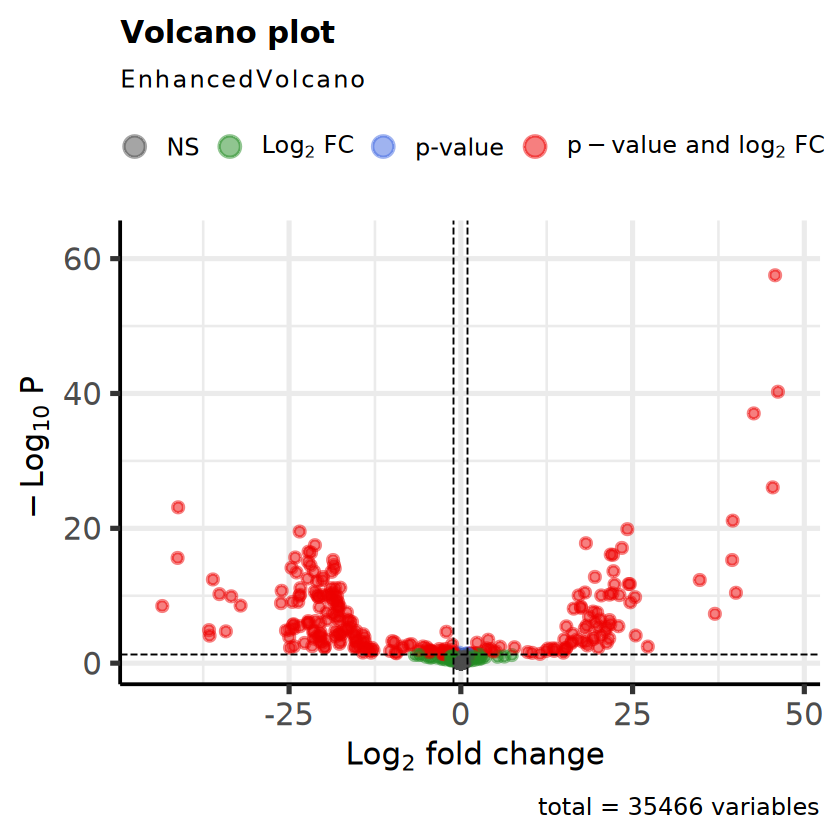

In [80]:
res.bc.hc <- lfcShrink(dds.noOutliers, contrast=c('complete_trtmt', 'both.control', 'hypoxic.control'), # HC is the "control"
                     type = 'ashr',
                      lfcThreshold = 1)

summary(res.bc.hc)

EnhancedVolcano(res.bc.hc,
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

res.bc.hc <- merge(res.bc.hc, counts(dds.noOutliers, normalized=TRUE), by="row.names", sort=FALSE) # add normalized counts to DESeq results
names(res.bc.hc)[1] <- 'Gene'

head(res.bc.hc)

In [81]:
write.csv(res.bc.hc, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_res_files/all_genes/bc_hc.csv', row.names = FALSE)

**BC vs. WC**

using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041

computing FSOS 'false sign or small' s-values (T=1)




out of 35396 with nonzero total read count
s-value < 0.005
LFC > 1.00 (up)    : 47, 0.13%
LFC < -1.00 (down) : 151, 0.43%



Gene         baseMean    log2FoldChange lfcSE       stat       pvalue    padj
1 LOC111116054   9.0629842 -3.620672e-04  0.024816275 -0.6424847 0.5205585 1   
2 LOC111126949 539.2853993  1.048851e-04  0.009284624  0.5305436 0.5957351 1   
3 LOC111110729 114.0070007 -3.422301e-05  0.006735269 -0.1988110 0.8424106 1   
4 LOC111112434   6.9517032  9.120595e-05  0.031438003  0.1040542 0.9171263 1   
5 LOC111120752 429.0263780 -2.970665e-05  0.007222551 -0.1737970 0.8620250 1   
6 LOC111128944   0.1088474  0.000000e+00  0.543971772  0.0000000 1.0000000 1   
  svalue    B1_B1_O01  B1_W5_O50  ⋯ W4_W5_G56  W5_B2_G21  W5_C4_G45 W5_H4_G46 
1 0.9790099   1.875059   5.965799 ⋯   4.336105   2.452846  11.19491   2.006592
2 0.9855505 829.713451 474.281013 ⋯ 230.897604 544.531781 506.25864 742.439160
3 0.9881127  60.001877  92.469883 ⋯ 128.999131  62.138762  87.07151 149.491128
4 0.9793810  10.312823   1.988600 ⋯   6.504158   0.000000  13.68267   6.019777
5 0.9874965 337.510556 334.084739 ⋯ 421.686235 286.165350 446.55246 346.137176
6 0.9256725   0.000000   0.000000 ⋯   0.000000   0.000000   0.00000   0.000000
  W5_W2_G22  W6_B3_G35  W6_B4_G48  W6_H6_G71 W6_W3_G36  W6_W4_G48
1   7.359253   5.277065   2.300668  21.05700   1.075999   0.0000 
2 650.373981 428.497663 480.839693 469.90350 302.355713 636.4963 
3 111.308701 121.372491 144.942108 119.69240 136.651870 226.3334 
4   3.679626   0.000000   2.300668  17.73221   8.607992   0.0000 
5 402.919100 293.404804 330.145914 461.03739 358.307660 456.9172 
6   0.000000   0.000000   0.000000   0.00000   0.000000   0.0000

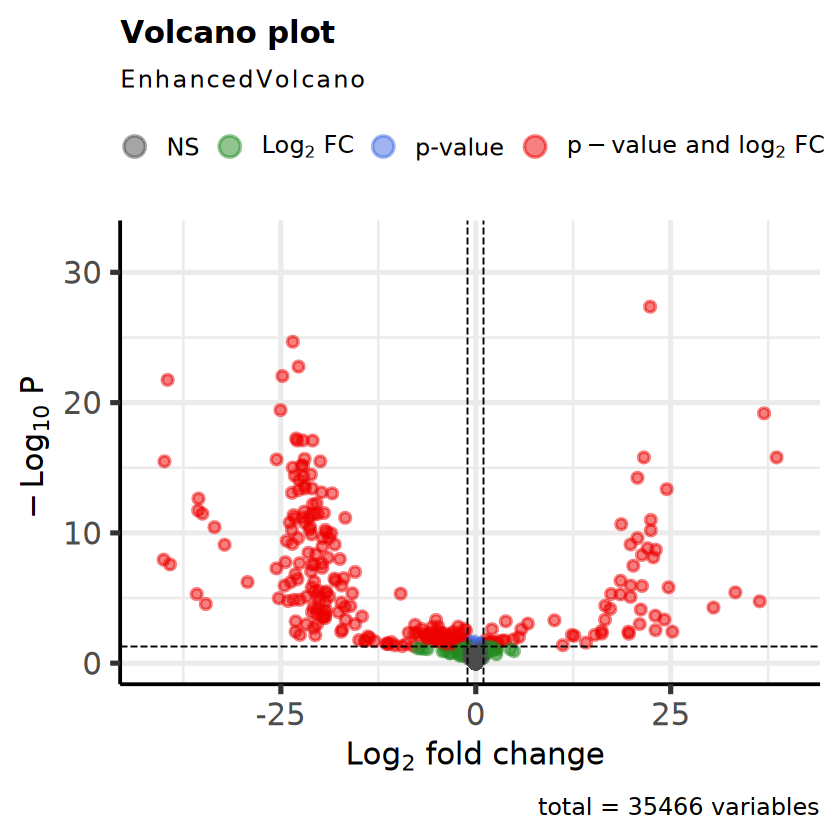

In [82]:
res.bc.wc <- lfcShrink(dds.noOutliers, contrast=c('complete_trtmt', 'both.control', 'warm.control'), # WC is the "control"
                     type = 'ashr',
                      lfcThreshold = 1)

summary(res.bc.wc)

EnhancedVolcano(res.bc.wc,
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

res.bc.wc <- merge(res.bc.wc, counts(dds.noOutliers, normalized=TRUE), by="row.names", sort=FALSE) # add normalized counts to DESeq results
names(res.bc.wc)[1] <- 'Gene'

head(res.bc.wc)

In [83]:
write.csv(res.bc.wc, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_res_files/all_genes/bc_wc.csv', row.names = FALSE)

#### 8B. ...different *late* stressors
- CW vs. CH: single early stress
- CB vs. CH: mulitple vs. single
- CB vs. CW: multiple vs. single

**CW vs. CH**

using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041

computing FSOS 'false sign or small' s-values (T=1)




out of 35396 with nonzero total read count
s-value < 0.005
LFC > 1.00 (up)    : 96, 0.27%
LFC < -1.00 (down) : 35, 0.099%



Gene         baseMean    log2FoldChange lfcSE      stat       pvalue    
1 LOC111116054   9.0629842 0.0046372894   0.07266592 1.00257025 0.31606825
2 LOC111126949 539.2853993 0.0003050574   0.04320473 0.05862777 0.95324859
3 LOC111110729 114.0070007 0.0145410165   0.05197184 1.84989818 0.06432823
4 LOC111112434   6.9517032 0.0014254292   0.07071245 0.32752377 0.74327177
5 LOC111120752 429.0263780 0.0050672363   0.04333480 0.80467836 0.42100531
6 LOC111128944   0.1088474 0.0005405195   0.43829465 0.02296871 0.98167523
  padj      svalue    B1_B1_O01  B1_W5_O50  ⋯ W4_W5_G56  W5_B2_G21  W5_C4_G45
1 0.9688767 0.9747292   1.875059   5.965799 ⋯   4.336105   2.452846  11.19491
2 1.0000000 0.9868605 829.713451 474.281013 ⋯ 230.897604 544.531781 506.25864
3 0.6934443 0.9847246  60.001877  92.469883 ⋯ 128.999131  62.138762  87.07151
4 1.0000000 0.9781815  10.312823   1.988600 ⋯   6.504158   0.000000  13.68267
5 1.0000000 0.9867019 337.510556 334.084739 ⋯ 421.686235 286.165350 446.55246
6 1.0000000 0.9507979   0.000000   0.000000 ⋯   0.000000   0.000000   0.00000
  W5_H4_G46  W5_W2_G22  W6_B3_G35  W6_B4_G48  W6_H6_G71 W6_W3_G36  W6_W4_G48
1   2.006592   7.359253   5.277065   2.300668  21.05700   1.075999   0.0000 
2 742.439160 650.373981 428.497663 480.839693 469.90350 302.355713 636.4963 
3 149.491128 111.308701 121.372491 144.942108 119.69240 136.651870 226.3334 
4   6.019777   3.679626   0.000000   2.300668  17.73221   8.607992   0.0000 
5 346.137176 402.919100 293.404804 330.145914 461.03739 358.307660 456.9172 
6   0.000000   0.000000   0.000000   0.000000   0.00000   0.000000   0.0000

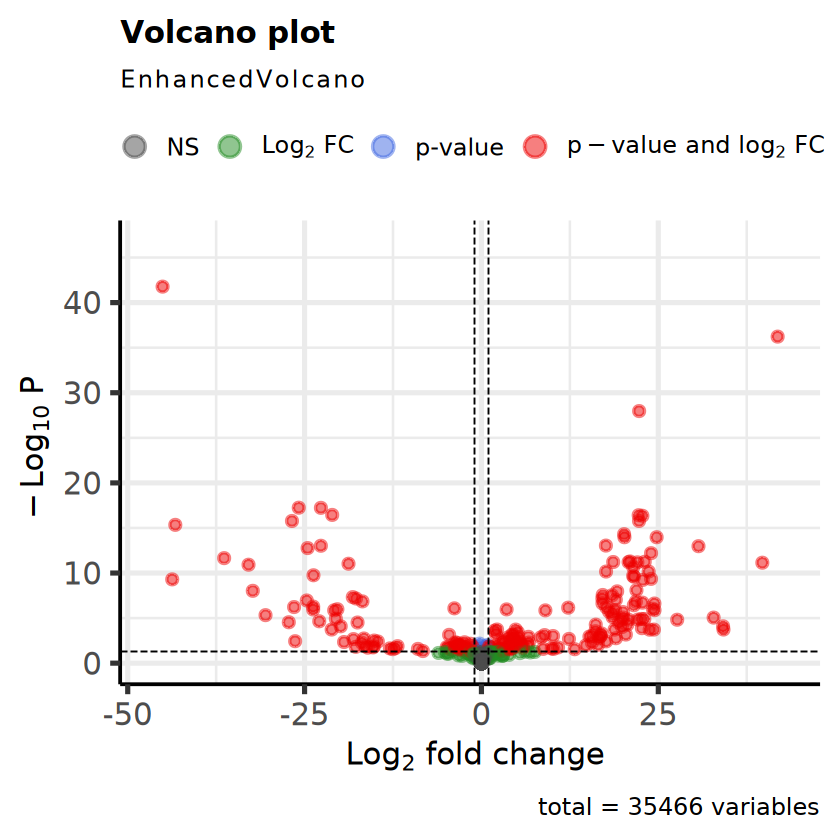

In [84]:
res.cw.ch <- lfcShrink(dds.noOutliers, contrast=c('complete_trtmt', 'control.warm', 'control.hypoxic'), # CH is the "control"
                     type = 'ashr',
                      lfcThreshold = 1)

summary(res.cw.ch)

EnhancedVolcano(res.cw.ch,
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

res.cw.ch <- merge(res.cw.ch, counts(dds.noOutliers, normalized=TRUE), by="row.names", sort=FALSE) # add normalized counts to DESeq results
names(res.cw.ch)[1] <- 'Gene'

head(res.cw.ch)

In [85]:
write.csv(res.cw.ch, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_res_files/all_genes/cw_ch.csv', row.names = FALSE)

**CB vs. CH**

using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041

computing FSOS 'false sign or small' s-values (T=1)




out of 35396 with nonzero total read count
s-value < 0.005
LFC > 1.00 (up)    : 84, 0.24%
LFC < -1.00 (down) : 97, 0.27%



Gene         baseMean    log2FoldChange lfcSE      stat        pvalue    
1 LOC111116054   9.0629842  0.085157517   0.34114562  2.39815467 0.01647791
2 LOC111126949 539.2853993  0.008513388   0.09744952  0.32207117 0.74739878
3 LOC111110729 114.0070007  0.014215263   0.09310318  0.40811237 0.68319118
4 LOC111112434   6.9517032  0.013031593   0.13598908  0.94891937 0.34266162
5 LOC111120752 429.0263780  0.009894118   0.09505172  0.31617145 0.75187237
6 LOC111128944   0.1088474 -0.002977626   0.49873103 -0.09829435 0.92169857
  padj      svalue    B1_B1_O01  B1_W5_O50  ⋯ W4_W5_G56  W5_B2_G21  W5_C4_G45
1 0.3751171 0.7188852   1.875059   5.965799 ⋯   4.336105   2.452846  11.19491
2 1.0000000 0.9827536 829.713451 474.281013 ⋯ 230.897604 544.531781 506.25864
3 1.0000000 0.9849088  60.001877  92.469883 ⋯ 128.999131  62.138762  87.07151
4 0.9220907 0.9606531  10.312823   1.988600 ⋯   6.504158   0.000000  13.68267
5 1.0000000 0.9841999 337.510556 334.084739 ⋯ 421.686235 286.165350 446.55246
6        NA 0.9279560   0.000000   0.000000 ⋯   0.000000   0.000000   0.00000
  W5_H4_G46  W5_W2_G22  W6_B3_G35  W6_B4_G48  W6_H6_G71 W6_W3_G36  W6_W4_G48
1   2.006592   7.359253   5.277065   2.300668  21.05700   1.075999   0.0000 
2 742.439160 650.373981 428.497663 480.839693 469.90350 302.355713 636.4963 
3 149.491128 111.308701 121.372491 144.942108 119.69240 136.651870 226.3334 
4   6.019777   3.679626   0.000000   2.300668  17.73221   8.607992   0.0000 
5 346.137176 402.919100 293.404804 330.145914 461.03739 358.307660 456.9172 
6   0.000000   0.000000   0.000000   0.000000   0.00000   0.000000   0.0000

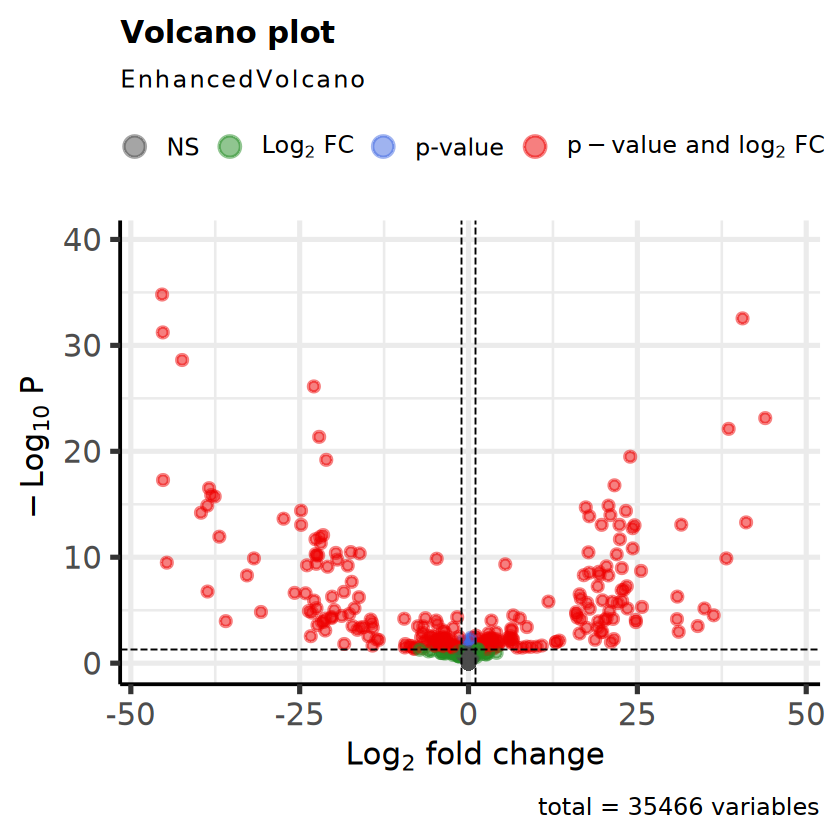

In [86]:
res.cb.ch <- lfcShrink(dds.noOutliers, contrast=c('complete_trtmt', 'control.both', 'control.hypoxic'), # CH is the "control"
                     type = 'ashr',
                      lfcThreshold = 1)

summary(res.cb.ch)

EnhancedVolcano(res.cb.ch,
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

res.cb.ch <- merge(res.cb.ch, counts(dds.noOutliers, normalized=TRUE), by="row.names", sort=FALSE) # add normalized counts to DESeq results
names(res.cb.ch)[1] <- 'Gene'

head(res.cb.ch)

In [87]:
write.csv(res.cb.ch, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_res_files/all_genes/cb_ch.csv', row.names = FALSE)

**CB vs. CW**

using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041

computing FSOS 'false sign or small' s-values (T=1)




out of 35396 with nonzero total read count
s-value < 0.005
LFC > 1.00 (up)    : 50, 0.14%
LFC < -1.00 (down) : 95, 0.27%



Gene         baseMean    log2FoldChange lfcSE      stat       pvalue   
1 LOC111116054   9.0629842  0.020530392   0.12668444  1.4021073 0.1608832
2 LOC111126949 539.2853993  0.005632383   0.08767348  0.2633668 0.7922679
3 LOC111110729 114.0070007 -0.041786991   0.08726850 -1.4383733 0.1503282
4 LOC111112434   6.9517032  0.006783259   0.11307022  0.6198623 0.5353485
5 LOC111120752 429.0263780 -0.012404581   0.08579942 -0.4882528 0.6253708
6 LOC111128944   0.1088474 -0.002739801   0.43160376 -0.1212533 0.9034904
  padj      svalue    B1_B1_O01  B1_W5_O50  ⋯ W4_W5_G56  W5_B2_G21  W5_C4_G45
1 0.8128260 0.9609764   1.875059   5.965799 ⋯   4.336105   2.452846  11.19491
2 1.0000000 0.9863987 829.713451 474.281013 ⋯ 230.897604 544.531781 506.25864
3 0.8055826 0.9862005  60.001877  92.469883 ⋯ 128.999131  62.138762  87.07151
4 0.9848366 0.9755258  10.312823   1.988600 ⋯   6.504158   0.000000  13.68267
5 0.9941483 0.9871758 337.510556 334.084739 ⋯ 421.686235 286.165350 446.55246
6        NA 0.9452302   0.000000   0.000000 ⋯   0.000000   0.000000   0.00000
  W5_H4_G46  W5_W2_G22  W6_B3_G35  W6_B4_G48  W6_H6_G71 W6_W3_G36  W6_W4_G48
1   2.006592   7.359253   5.277065   2.300668  21.05700   1.075999   0.0000 
2 742.439160 650.373981 428.497663 480.839693 469.90350 302.355713 636.4963 
3 149.491128 111.308701 121.372491 144.942108 119.69240 136.651870 226.3334 
4   6.019777   3.679626   0.000000   2.300668  17.73221   8.607992   0.0000 
5 346.137176 402.919100 293.404804 330.145914 461.03739 358.307660 456.9172 
6   0.000000   0.000000   0.000000   0.000000   0.00000   0.000000   0.0000

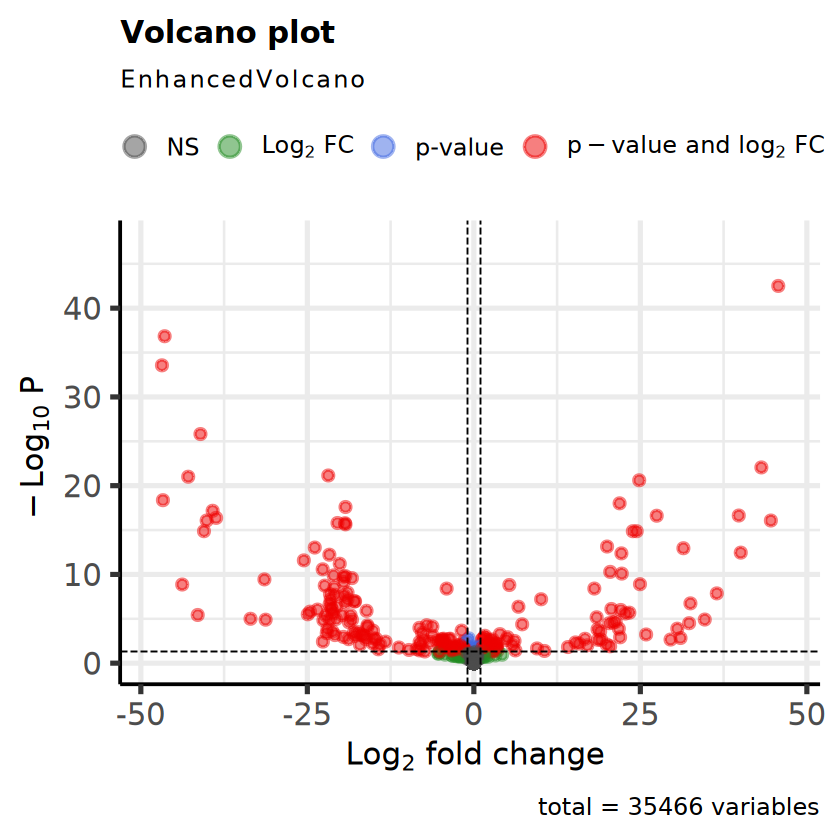

In [88]:
res.cb.cw <- lfcShrink(dds.noOutliers, contrast=c('complete_trtmt', 'control.both', 'control.warm'), # CW is the "control"
                     type = 'ashr',
                      lfcThreshold = 1)

summary(res.cb.cw)

EnhancedVolcano(res.cb.cw,
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

res.cb.cw <- merge(res.cb.cw, counts(dds.noOutliers, normalized=TRUE), by="row.names", sort=FALSE) # add normalized counts to DESeq results
names(res.cb.cw)[1] <- 'Gene'

head(res.cb.cw)

In [89]:
write.csv(res.cb.cw, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_res_files/all_genes/cb_cw.csv', row.names = FALSE)

### 9. Effect of the order of stressors
Does the order of when stress is experienced matter? Maybe one stressor is an informative cue for a later environmnet?
- WH vs. HW
- WB vs. BW
- HB vs. BH

**WH vs. HW**

using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041

computing FSOS 'false sign or small' s-values (T=1)




out of 35396 with nonzero total read count
s-value < 0.005
LFC > 1.00 (up)    : 81, 0.23%
LFC < -1.00 (down) : 52, 0.15%



Gene         baseMean    log2FoldChange lfcSE      stat       pvalue    
1 LOC111116054   9.0629842  0.0007888077  0.04525533  0.3177800 0.75065184
2 LOC111126949 539.2853993 -0.0112073593  0.07818049 -2.0386048 0.04148949
3 LOC111110729 114.0070007 -0.0004023614  0.02703085 -0.1378839 0.89033220
4 LOC111112434   6.9517032  0.0014286936  0.05844282  0.5023504 0.61542107
5 LOC111120752 429.0263780 -0.0009551295  0.02858526 -0.3448803 0.73018438
6 LOC111128944   0.1088474  0.0000000000  0.40159916  0.0000000 1.00000000
  padj      svalue    B1_B1_O01  B1_W5_O50  ⋯ W4_W5_G56  W5_B2_G21  W5_C4_G45
1 1.0000000 0.9855158   1.875059   5.965799 ⋯   4.336105   2.452846  11.19491
2 0.7107464 0.9752857 829.713451 474.281013 ⋯ 230.897604 544.531781 506.25864
3 1.0000000 0.9910122  60.001877  92.469883 ⋯ 128.999131  62.138762  87.07151
4 1.0000000 0.9820210  10.312823   1.988600 ⋯   6.504158   0.000000  13.68267
5 1.0000000 0.9903704 337.510556 334.084739 ⋯ 421.686235 286.165350 446.55246
6 1.0000000 0.9540589   0.000000   0.000000 ⋯   0.000000   0.000000   0.00000
  W5_H4_G46  W5_W2_G22  W6_B3_G35  W6_B4_G48  W6_H6_G71 W6_W3_G36  W6_W4_G48
1   2.006592   7.359253   5.277065   2.300668  21.05700   1.075999   0.0000 
2 742.439160 650.373981 428.497663 480.839693 469.90350 302.355713 636.4963 
3 149.491128 111.308701 121.372491 144.942108 119.69240 136.651870 226.3334 
4   6.019777   3.679626   0.000000   2.300668  17.73221   8.607992   0.0000 
5 346.137176 402.919100 293.404804 330.145914 461.03739 358.307660 456.9172 
6   0.000000   0.000000   0.000000   0.000000   0.00000   0.000000   0.0000

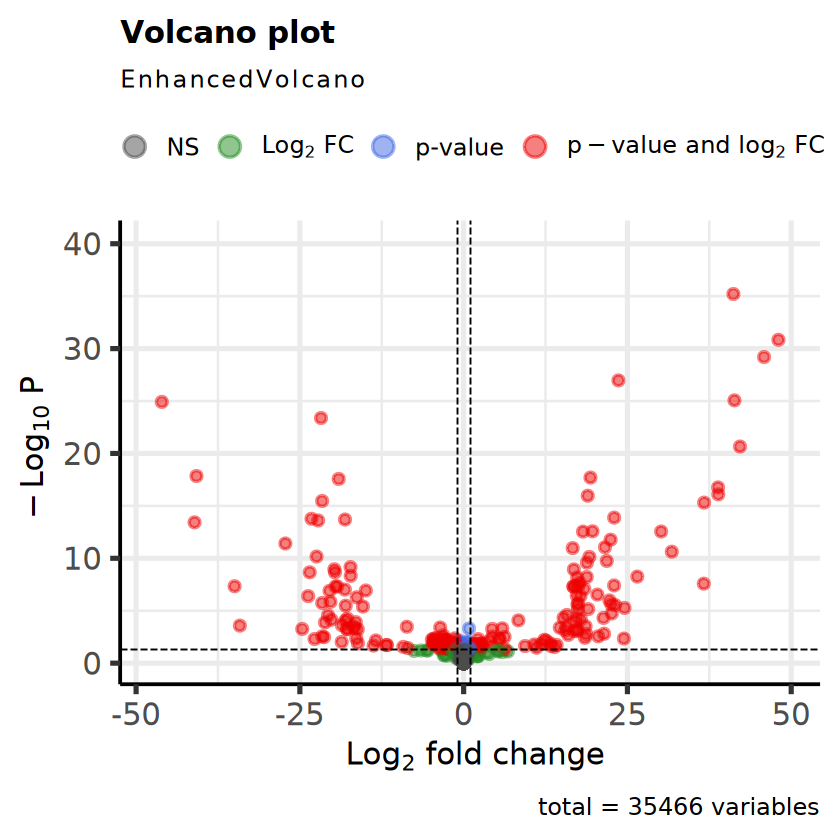

In [90]:
res.wh.hw <- lfcShrink(dds.noOutliers, contrast=c('complete_trtmt', 'warm.hypoxic', 'hypoxic.warm'), # HW is the "control"
                     type = 'ashr',
                      lfcThreshold = 1)

summary(res.wh.hw)

EnhancedVolcano(res.wh.hw,
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

res.wh.hw <- merge(res.wh.hw, counts(dds.noOutliers, normalized=TRUE), by="row.names", sort=FALSE) # add normalized counts to DESeq results
names(res.wh.hw)[1] <- 'Gene'

head(res.wh.hw)

In [91]:
write.csv(res.wh.hw, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_res_files/all_genes/wh_hw.csv', row.names = FALSE)

**WB vs. BW**

using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041

computing FSOS 'false sign or small' s-values (T=1)




out of 35396 with nonzero total read count
s-value < 0.005
LFC > 1.00 (up)    : 144, 0.41%
LFC < -1.00 (down) : 48, 0.14%



Gene         baseMean    log2FoldChange lfcSE     stat       pvalue   
1 LOC111116054   9.0629842  0.018994642   0.1385472  0.8863473 0.3754304
2 LOC111126949 539.2853993  0.028691117   0.1140907  0.8053099 0.4206409
3 LOC111110729 114.0070007  0.020593676   0.1059406  0.4537218 0.6500291
4 LOC111112434   6.9517032 -0.003797296   0.1385556 -0.2112115 0.8327222
5 LOC111120752 429.0263780  0.056897308   0.1129660  1.3547804 0.1754875
6 LOC111128944   0.1088474  0.004982864   0.5732957  0.1247761 0.9007008
  padj      svalue    B1_B1_O01  B1_W5_O50  ⋯ W4_W5_G56  W5_B2_G21  W5_C4_G45
1 0.8453066 0.9603308   1.875059   5.965799 ⋯   4.336105   2.452846  11.19491
2 0.8632382 0.9748018 829.713451 474.281013 ⋯ 230.897604 544.531781 506.25864
3 0.9360435 0.9795275  60.001877  92.469883 ⋯ 128.999131  62.138762  87.07151
4 0.9757225 0.9650910  10.312823   1.988600 ⋯   6.504158   0.000000  13.68267
5 0.7022263 0.9748028 337.510556 334.084739 ⋯ 421.686235 286.165350 446.55246
6        NA 0.9144081   0.000000   0.000000 ⋯   0.000000   0.000000   0.00000
  W5_H4_G46  W5_W2_G22  W6_B3_G35  W6_B4_G48  W6_H6_G71 W6_W3_G36  W6_W4_G48
1   2.006592   7.359253   5.277065   2.300668  21.05700   1.075999   0.0000 
2 742.439160 650.373981 428.497663 480.839693 469.90350 302.355713 636.4963 
3 149.491128 111.308701 121.372491 144.942108 119.69240 136.651870 226.3334 
4   6.019777   3.679626   0.000000   2.300668  17.73221   8.607992   0.0000 
5 346.137176 402.919100 293.404804 330.145914 461.03739 358.307660 456.9172 
6   0.000000   0.000000   0.000000   0.000000   0.00000   0.000000   0.0000

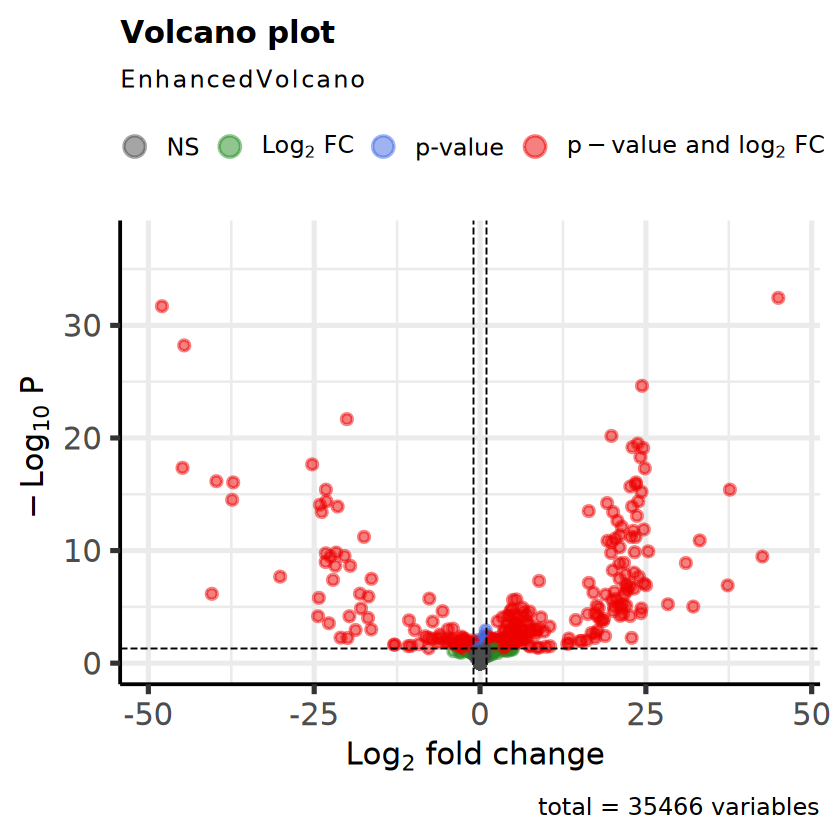

In [92]:
res.wb.bw <- lfcShrink(dds.noOutliers, contrast=c('complete_trtmt', 'warm.both', 'both.warm'), # BW is the "control"
                     type = 'ashr',
                      lfcThreshold = 1)

summary(res.wb.bw)

EnhancedVolcano(res.wb.bw,
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

res.wb.bw <- merge(res.wb.bw, counts(dds.noOutliers, normalized=TRUE), by="row.names", sort=FALSE) # add normalized counts to DESeq results
names(res.wb.bw)[1] <- 'Gene'

head(res.wb.bw)

In [93]:
write.csv(res.wb.bw, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_res_files/all_genes/wb_bw.csv', row.names = FALSE)

**HB vs. BH**

using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041

computing FSOS 'false sign or small' s-values (T=1)




out of 35396 with nonzero total read count
s-value < 0.005
LFC > 1.00 (up)    : 173, 0.49%
LFC < -1.00 (down) : 62, 0.18%



Gene         baseMean    log2FoldChange lfcSE     stat       pvalue    
1 LOC111116054   9.0629842 -0.01845806    0.2100223 -0.3164358 0.75167175
2 LOC111126949 539.2853993  0.09963602    0.1864992  1.0750201 0.28236575
3 LOC111110729 114.0070007 -0.07150864    0.1604272 -0.7203313 0.47132101
4 LOC111112434   6.9517032 -0.59435240    1.1803759 -3.0535527 0.00226149
5 LOC111120752 429.0263780 -0.14451323    0.1774459 -1.4323682 0.15203849
6 LOC111128944   0.1088474  0.00000000    0.6232349  0.0000000 1.00000000
  padj       svalue    B1_B1_O01  B1_W5_O50  ⋯ W4_W5_G56  W5_B2_G21  W5_C4_G45
1 0.95749215 0.9725022   1.875059   5.965799 ⋯   4.336105   2.452846  11.19491
2 0.73913321 0.9765585 829.713451 474.281013 ⋯ 230.897604 544.531781 506.25864
3 0.86169442 0.9813275  60.001877  92.469883 ⋯ 128.999131  62.138762  87.07151
4 0.07876609 0.3642020  10.312823   1.988600 ⋯   6.504158   0.000000  13.68267
5 0.59712237 0.9776249 337.510556 334.084739 ⋯ 421.686235 286.165350 446.55246
6         NA 0.9191786   0.000000   0.000000 ⋯   0.000000   0.000000   0.00000
  W5_H4_G46  W5_W2_G22  W6_B3_G35  W6_B4_G48  W6_H6_G71 W6_W3_G36  W6_W4_G48
1   2.006592   7.359253   5.277065   2.300668  21.05700   1.075999   0.0000 
2 742.439160 650.373981 428.497663 480.839693 469.90350 302.355713 636.4963 
3 149.491128 111.308701 121.372491 144.942108 119.69240 136.651870 226.3334 
4   6.019777   3.679626   0.000000   2.300668  17.73221   8.607992   0.0000 
5 346.137176 402.919100 293.404804 330.145914 461.03739 358.307660 456.9172 
6   0.000000   0.000000   0.000000   0.000000   0.00000   0.000000   0.0000

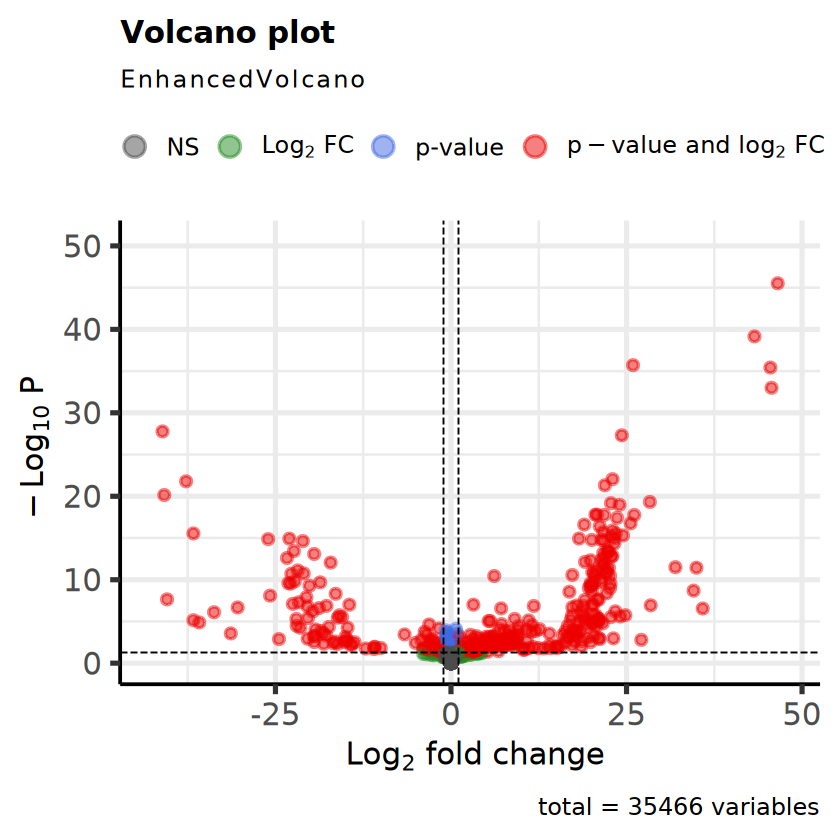

In [94]:
res.hb.bh <- lfcShrink(dds.noOutliers, contrast=c('complete_trtmt', 'hypoxic.both', 'both.hypoxic'), # BH is the "control"
                     type = 'ashr',
                      lfcThreshold = 1)

summary(res.hb.bh)

EnhancedVolcano(res.hb.bh,
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

res.hb.bh <- merge(res.hb.bh, counts(dds.noOutliers, normalized=TRUE), by="row.names", sort=FALSE) # add normalized counts to DESeq results
names(res.hb.bh)[1] <- 'Gene'

head(res.hb.bh)

In [95]:
write.csv(res.hb.bh, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_res_files/all_genes/hb_bh.csv', row.names = FALSE)

### temperature and DO treatments
looking at the effects of temperature and DO in an isolated manner

#### phase 1 temp
ambient vs. warm

regardless of phase 2 treatments or phase 1 DO

In [20]:
# creating DESeq2 object
dds_p1temp <- DESeqDataSetFromMatrix(countData = counts_noOutliers,
                              colData = meta_noOutliers,
                              design = ~ Phase1_temp)
dds_p1temp

# running DESeq
dds_p1temp <- DESeq(dds_p1temp)

# list coefficients
resultsNames(dds_p1temp)

class: DESeqDataSet 
dim: 35466 94 
metadata(1): version
assays(1): counts
rownames(35466): LOC111116054 LOC111126949 ... ND1 ND4L
rowData names(0):
colnames(94): B1_B1_O01 B1_W5_O50 ... W6_W3_G36 W6_W4_G48
colData names(9): Phase1_treatment Phase1_temp ... Phase2_TankRep
  complete_trtmt

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 3127 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing



[1] "Intercept"                   "Phase1_temp_warm_vs_ambient"

using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041

computing FSOS 'false sign or small' s-values (T=1)




out of 35380 with nonzero total read count
s-value < 0.005
LFC > 1.00 (up)    : 1, 0.0028%
LFC < -1.00 (down) : 2, 0.0057%



Gene         baseMean    log2FoldChange lfcSE       stat       pvalue    
1 LOC111116054   9.0629842 -3.222355e-04  0.013227801 -0.8717725 0.38333251
2 LOC111126949 539.2853993 -2.934731e-05  0.003808717 -0.2796431 0.77975134
3 LOC111110729 114.0070007  1.681844e-04  0.004794016  1.2834665 0.19932868
4 LOC111112434   6.9517032  3.574349e-03  0.054558641  1.8355001 0.06643162
5 LOC111120752 429.0263780 -9.556625e-06  0.003182889 -0.1012887 0.91932132
6 LOC111128944   0.1088474  1.568429e-04  0.074903580  0.0816091 0.93495757
  padj      svalue    B1_B1_O01  B1_W5_O50  ⋯ W4_W5_G56  W5_B2_G21  W5_C4_G45
1 0.9989981 0.9957313   1.875059   5.965799 ⋯   4.336105   2.452846  11.19491
2 0.9999024 0.9972999 829.713451 474.281013 ⋯ 230.897604 544.531781 506.25864
3 0.9559349 0.9973000  60.001877  92.469883 ⋯ 128.999131  62.138762  87.07151
4 0.8374923 0.9810733  10.312823   1.988600 ⋯   6.504158   0.000000  13.68267
5 0.9999024 0.9974632 337.510556 334.084739 ⋯ 421.686235 286.165350 446.55246
6        NA 0.9833743   0.000000   0.000000 ⋯   0.000000   0.000000   0.00000
  W5_H4_G46  W5_W2_G22  W6_B3_G35  W6_B4_G48  W6_H6_G71 W6_W3_G36  W6_W4_G48
1   2.006592   7.359253   5.277065   2.300668  21.05700   1.075999   0.0000 
2 742.439160 650.373981 428.497663 480.839693 469.90350 302.355713 636.4963 
3 149.491128 111.308701 121.372491 144.942108 119.69240 136.651870 226.3334 
4   6.019777   3.679626   0.000000   2.300668  17.73221   8.607992   0.0000 
5 346.137176 402.919100 293.404804 330.145914 461.03739 358.307660 456.9172 
6   0.000000   0.000000   0.000000   0.000000   0.00000   0.000000   0.0000

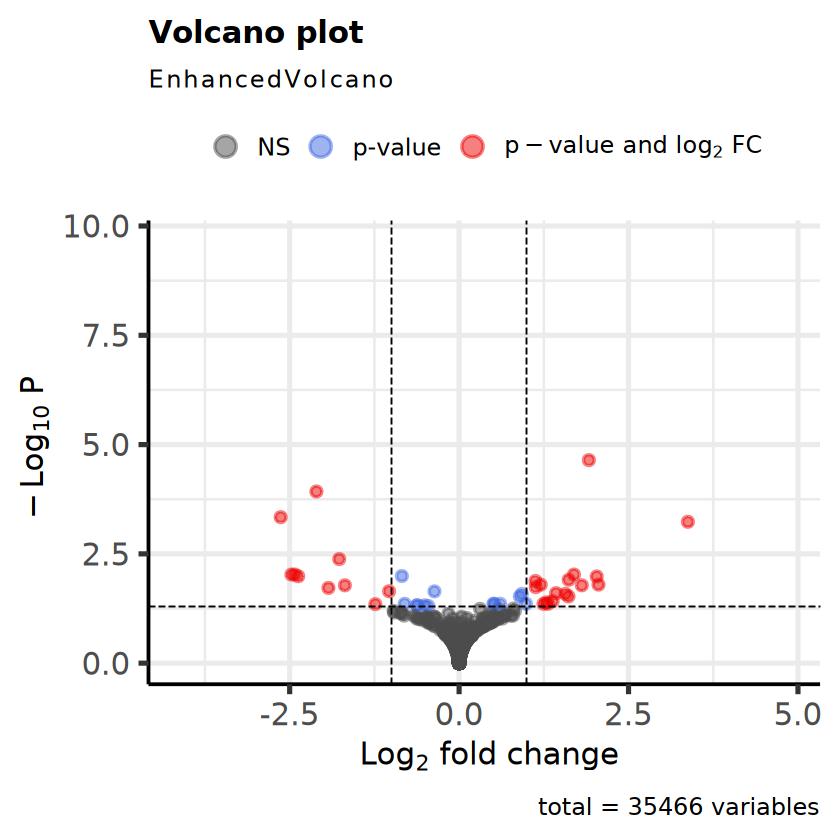

In [42]:
p1_temp.res <- lfcShrink(dds_p1temp, coef = 'Phase1_temp_warm_vs_ambient', 
                     type = 'ashr',
                      lfcThreshold = 1)

summary(p1_temp.res)

EnhancedVolcano(p1_temp.res,
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

p1_temp.res <- merge(p1_temp.res, counts(dds_p1temp, normalized=TRUE), by="row.names", sort=FALSE) # add normalized counts to DESeq results
names(p1_temp.res)[1] <- 'Gene'

head(p1_temp.res)

In [58]:
as.data.frame(p1_temp.res) %>%
filter(abs(log2FoldChange) > 1 & padj < 0.05) %>%
dim()

# 27 DEGs

[1]  27 102

In [44]:
write.csv(p1_temp.res, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_res_files/isolated_treatments/p1_temp.csv', row.names = FALSE)

#### phase 1 DO
normoxic vs. hypoxic

In [25]:
# creating DESeq2 object
dds_p1DO <- DESeqDataSetFromMatrix(countData = counts_noOutliers,
                              colData = meta_noOutliers,
                              design = ~ Phase1_DO)
dds_p1DO

# running DESeq
dds_p1DO <- DESeq(dds_p1DO)

# list coefficients
resultsNames(dds_p1DO)

class: DESeqDataSet 
dim: 35466 94 
metadata(1): version
assays(1): counts
rownames(35466): LOC111116054 LOC111126949 ... ND1 ND4L
rowData names(0):
colnames(94): B1_B1_O01 B1_W5_O50 ... W6_W3_G36 W6_W4_G48
colData names(9): Phase1_treatment Phase1_temp ... Phase2_TankRep
  complete_trtmt

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 3391 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing



[1] "Intercept"                     "Phase1_DO_hypoxic_vs_normoxic"

using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041

computing FSOS 'false sign or small' s-values (T=1)




out of 35382 with nonzero total read count
s-value < 0.005
LFC > 1.00 (up)    : 5, 0.014%
LFC < -1.00 (down) : 6, 0.017%



Gene         baseMean    log2FoldChange lfcSE       stat       pvalue    
1 LOC111116054   9.0629842 -1.546376e-04  0.009916473 -0.5777018 0.56346547
2 LOC111126949 539.2853993  3.824813e-05  0.003655645  0.4164813 0.67705786
3 LOC111110729 114.0070007 -1.336036e-03  0.017994438 -2.4588041 0.01394007
4 LOC111112434   6.9517032  1.587600e-03  0.035210740  1.4876657 0.13683908
5 LOC111120752 429.0263780  3.071058e-05  0.003051076  0.3726865 0.70938178
6 LOC111128944   0.1088474 -6.605360e-04  0.094135098 -0.2201169 0.82578009
  padj      svalue    B1_B1_O01  B1_W5_O50  ⋯ W4_W5_G56  W5_B2_G21  W5_C4_G45
1 0.9998475 0.9940061   1.875059   5.965799 ⋯   4.336105   2.452846  11.19491
2 0.9998475 0.9960052 829.713451 474.281013 ⋯ 230.897604 544.531781 506.25864
3 0.6637687 0.9962444  60.001877  92.469883 ⋯ 128.999131  62.138762  87.07151
4 0.9998475 0.9877834  10.312823   1.988600 ⋯   6.504158   0.000000  13.68267
5 0.9998475 0.9962445 337.510556 334.084739 ⋯ 421.686235 286.165350 446.55246
6 0.9998475 0.9681763   0.000000   0.000000 ⋯   0.000000   0.000000   0.00000
  W5_H4_G46  W5_W2_G22  W6_B3_G35  W6_B4_G48  W6_H6_G71 W6_W3_G36  W6_W4_G48
1   2.006592   7.359253   5.277065   2.300668  21.05700   1.075999   0.0000 
2 742.439160 650.373981 428.497663 480.839693 469.90350 302.355713 636.4963 
3 149.491128 111.308701 121.372491 144.942108 119.69240 136.651870 226.3334 
4   6.019777   3.679626   0.000000   2.300668  17.73221   8.607992   0.0000 
5 346.137176 402.919100 293.404804 330.145914 461.03739 358.307660 456.9172 
6   0.000000   0.000000   0.000000   0.000000   0.00000   0.000000   0.0000

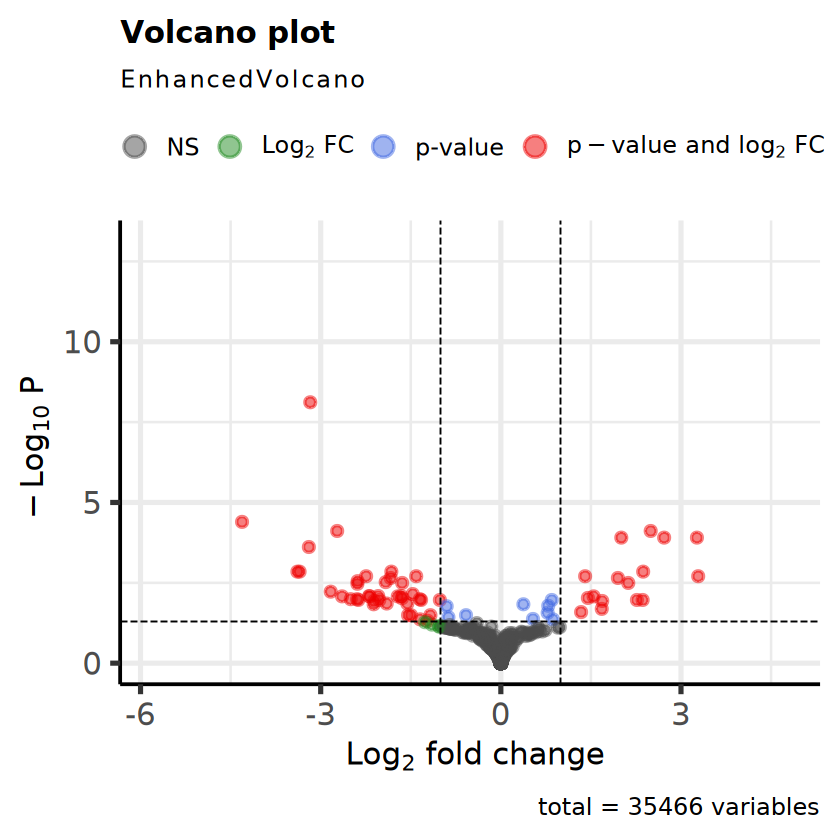

In [45]:
p1_DO.res <- lfcShrink(dds_p1DO, coef = 'Phase1_DO_hypoxic_vs_normoxic', 
                     type = 'ashr',
                      lfcThreshold = 1)

summary(p1_DO.res)

EnhancedVolcano(p1_DO.res,
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

p1_DO.res <- merge(p1_DO.res, counts(dds_p1DO, normalized=TRUE), by="row.names", sort=FALSE) # add normalized counts to DESeq results
names(p1_DO.res)[1] <- 'Gene'

head(p1_DO.res)

a couple more DEGs, but still not a ton - to be expected, since we think GE is more short term

In [57]:
as.data.frame(p1_DO.res) %>%
filter(abs(log2FoldChange) > 1 & padj < 0.05) %>%
dim()

# 55 DEGs!

[1]  55 102

In [47]:
write.csv(p1_DO.res, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_res_files/isolated_treatments/p1_DO.csv', row.names = FALSE)

#### phase 2 temp
ambient vs. warm

regardless of phase 1 treatments or phase 2 DO

In [27]:
# creating DESeq2 object
dds_p2temp <- DESeqDataSetFromMatrix(countData = counts_noOutliers,
                              colData = meta_noOutliers,
                              design = ~ Phase2_temp)
dds_p2temp

# running DESeq
dds_p2temp <- DESeq(dds_p2temp)

# list coefficients
resultsNames(dds_p2temp)

class: DESeqDataSet 
dim: 35466 94 
metadata(1): version
assays(1): counts
rownames(35466): LOC111116054 LOC111126949 ... ND1 ND4L
rowData names(0):
colnames(94): B1_B1_O01 B1_W5_O50 ... W6_W3_G36 W6_W4_G48
colData names(9): Phase1_treatment Phase1_temp ... Phase2_TankRep
  complete_trtmt

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 3309 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing



[1] "Intercept"                   "Phase2_temp_warm_vs_ambient"

using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041

computing FSOS 'false sign or small' s-values (T=1)




out of 35380 with nonzero total read count
s-value < 0.005
LFC > 1.00 (up)    : 28, 0.079%
LFC < -1.00 (down) : 3, 0.0085%



Gene         baseMean    log2FoldChange lfcSE      stat       pvalue      
1 LOC111116054   9.0629842 -0.023427821   0.11750113 -0.4851342 0.6275811358
2 LOC111126949 539.2853993  0.239985196   0.11121343  3.3699953 0.0007516946
3 LOC111110729 114.0070007  0.149647021   0.08018601  2.4507010 0.0142578324
4 LOC111112434   6.9517032 -0.056660873   0.14097869 -1.2844967 0.1989682180
5 LOC111120752 429.0263780 -0.113369245   0.08483857 -1.8534890 0.0638122952
6 LOC111128944   0.1088474  0.003114854   0.21049335  0.2061345 0.8366858689
  padj       svalue    B1_B1_O01  B1_W5_O50  ⋯ W4_W5_G56  W5_B2_G21  W5_C4_G45
1 0.85635954 0.9819074   1.875059   5.965799 ⋯   4.336105   2.452846  11.19491
2 0.02184176 0.9841316 829.713451 474.281013 ⋯ 230.897604 544.531781 506.25864
3 0.13255163 0.9883678  60.001877  92.469883 ⋯ 128.999131  62.138762  87.07151
4 0.51885041 0.9702647  10.312823   1.988600 ⋯   6.504158   0.000000  13.68267
5 0.29857698 0.9883682 337.510556 334.084739 ⋯ 421.686235 286.165350 446.55246
6         NA 0.9393992   0.000000   0.000000 ⋯   0.000000   0.000000   0.00000
  W5_H4_G46  W5_W2_G22  W6_B3_G35  W6_B4_G48  W6_H6_G71 W6_W3_G36  W6_W4_G48
1   2.006592   7.359253   5.277065   2.300668  21.05700   1.075999   0.0000 
2 742.439160 650.373981 428.497663 480.839693 469.90350 302.355713 636.4963 
3 149.491128 111.308701 121.372491 144.942108 119.69240 136.651870 226.3334 
4   6.019777   3.679626   0.000000   2.300668  17.73221   8.607992   0.0000 
5 346.137176 402.919100 293.404804 330.145914 461.03739 358.307660 456.9172 
6   0.000000   0.000000   0.000000   0.000000   0.00000   0.000000   0.0000

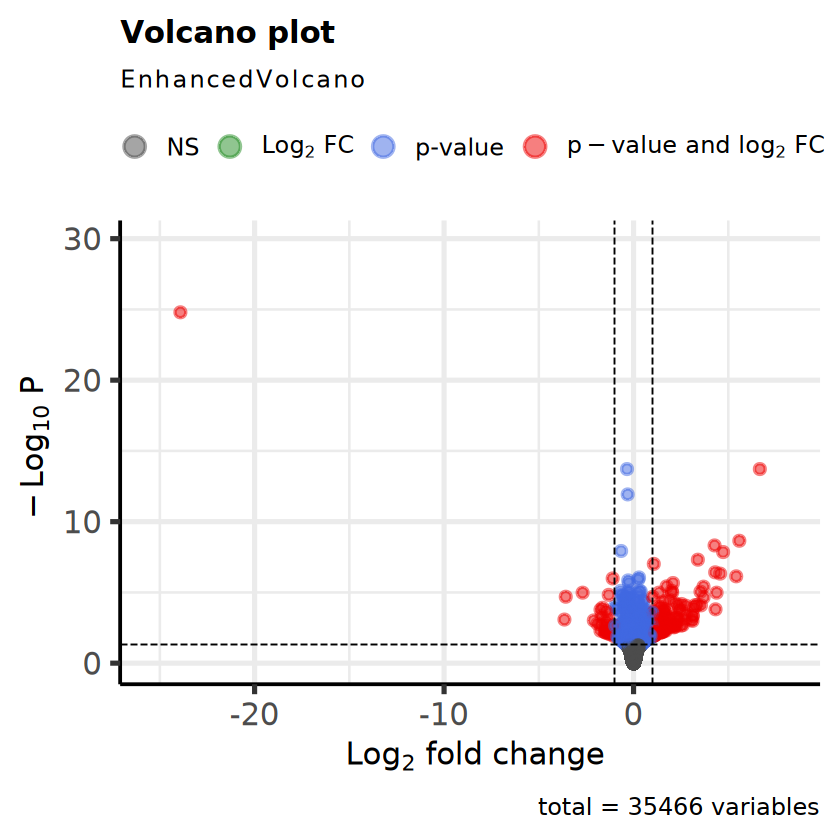

In [48]:
p2_temp.res <- lfcShrink(dds_p2temp, coef = 'Phase2_temp_warm_vs_ambient', 
                     type = 'ashr',
                      lfcThreshold = 1)

summary(p2_temp.res)

EnhancedVolcano(p2_temp.res,
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

p2_temp.res <- merge(p2_temp.res, counts(dds_p2temp, normalized=TRUE), by="row.names", sort=FALSE) # add normalized counts to DESeq results
names(p2_temp.res)[1] <- 'Gene'

head(p2_temp.res)

In [56]:
as.data.frame(p2_temp.res) %>%
filter(abs(log2FoldChange) > 1 & padj < 0.05) %>%
dim()

# 167 DEGs!

[1] 167 102

In [51]:
write.csv(p2_temp.res, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_res_files/isolated_treatments/p2_temp.csv', row.names = FALSE)

#### phase 2 DO
normoxic vs. hypoxic

regardless of phase 1 treatments or phase 2 temperatures

In [29]:
# creating DESeq2 object
dds_p2DO <- DESeqDataSetFromMatrix(countData = counts_noOutliers,
                              colData = meta_noOutliers,
                              design = ~ Phase2_DO)
dds_p2DO

# running DESeq
dds_p2DO <- DESeq(dds_p2DO)

# list coefficients
resultsNames(dds_p2DO)

class: DESeqDataSet 
dim: 35466 94 
metadata(1): version
assays(1): counts
rownames(35466): LOC111116054 LOC111126949 ... ND1 ND4L
rowData names(0):
colnames(94): B1_B1_O01 B1_W5_O50 ... W6_W3_G36 W6_W4_G48
colData names(9): Phase1_treatment Phase1_temp ... Phase2_TankRep
  complete_trtmt

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 3070 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing



[1] "Intercept"                     "Phase2_DO_hypoxic_vs_normoxic"

using 'ashr' for LFC shrinkage. If used in published research, please cite:
    Stephens, M. (2016) False discovery rates: a new deal. Biostatistics, 18:2.
    https://doi.org/10.1093/biostatistics/kxw041

computing FSOS 'false sign or small' s-values (T=1)




out of 35382 with nonzero total read count
s-value < 0.005
LFC > 1.00 (up)    : 15, 0.042%
LFC < -1.00 (down) : 3, 0.0085%



Gene         baseMean    log2FoldChange lfcSE      stat        pvalue    
1 LOC111116054   9.0629842  0.0265048475  0.09692275  0.85275192 0.39379689
2 LOC111126949 539.2853993  0.0296414541  0.07465282  0.73696529 0.46114346
3 LOC111110729 114.0070007 -0.0811046534  0.07264062 -1.80202503 0.07154147
4 LOC111112434   6.9517032  0.0322580839  0.11088581  1.17087861 0.24164757
5 LOC111120752 429.0263780 -0.0197890537  0.06622966 -0.49180059 0.62286032
6 LOC111128944   0.1088474 -0.0005860086  0.14872067 -0.07729585 0.93838819
  padj      svalue    B1_B1_O01  B1_W5_O50  ⋯ W4_W5_G56  W5_B2_G21  W5_C4_G45
1 0.7986296 0.9923465   1.875059   5.965799 ⋯   4.336105   2.452846  11.19491
2 0.8373190 0.9951012 829.713451 474.281013 ⋯ 230.897604 544.531781 506.25864
3 0.4282964 0.9954673  60.001877  92.469883 ⋯ 128.999131  62.138762  87.07151
4 0.6801943 0.9885682  10.312823   1.988600 ⋯   6.504158   0.000000  13.68267
5 0.9083442 0.9954674 337.510556 334.084739 ⋯ 421.686235 286.165350 446.55246
6        NA 0.9738525   0.000000   0.000000 ⋯   0.000000   0.000000   0.00000
  W5_H4_G46  W5_W2_G22  W6_B3_G35  W6_B4_G48  W6_H6_G71 W6_W3_G36  W6_W4_G48
1   2.006592   7.359253   5.277065   2.300668  21.05700   1.075999   0.0000 
2 742.439160 650.373981 428.497663 480.839693 469.90350 302.355713 636.4963 
3 149.491128 111.308701 121.372491 144.942108 119.69240 136.651870 226.3334 
4   6.019777   3.679626   0.000000   2.300668  17.73221   8.607992   0.0000 
5 346.137176 402.919100 293.404804 330.145914 461.03739 358.307660 456.9172 
6   0.000000   0.000000   0.000000   0.000000   0.00000   0.000000   0.0000

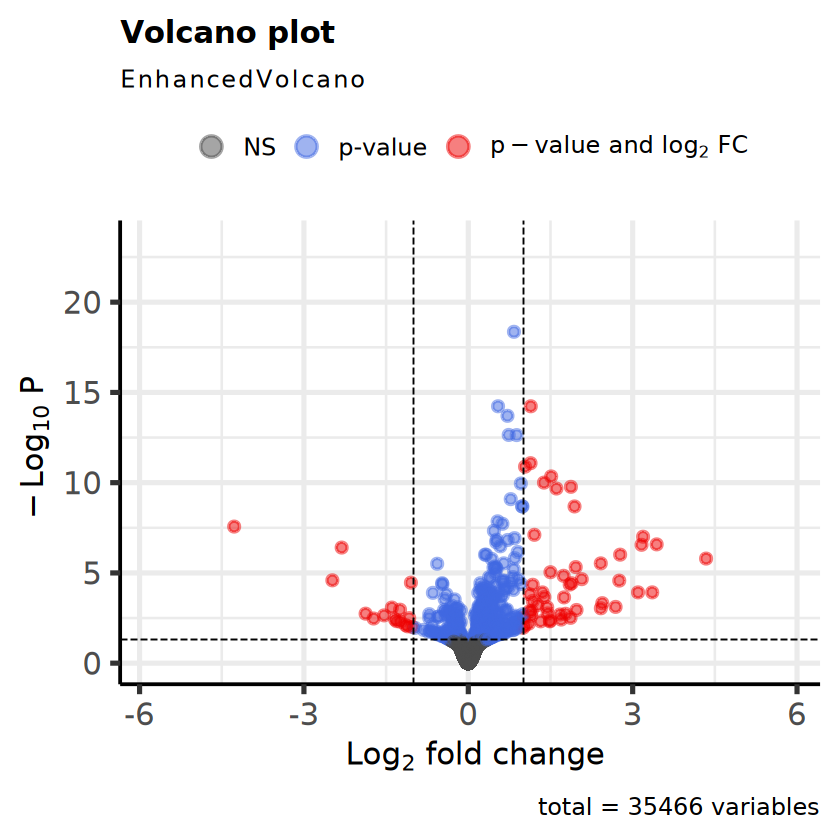

In [52]:
p2_DO.res <- lfcShrink(dds_p2DO, coef = 'Phase2_DO_hypoxic_vs_normoxic', 
                     type = 'ashr',
                      lfcThreshold = 1)

summary(p2_DO.res)

EnhancedVolcano(p2_DO.res,
                lab=NA,
                x = 'log2FoldChange',
                y='padj',
                pCutoff=0.05)

p2_DO.res <- merge(p2_DO.res, counts(dds_p2DO, normalized=TRUE), by="row.names", sort=FALSE) # add normalized counts to DESeq results
names(p2_DO.res)[1] <- 'Gene'

head(p2_DO.res)

In [55]:
as.data.frame(p2_DO.res) %>%
filter(abs(log2FoldChange) > 1 & padj < 0.05) %>%
dim()

# 67 DEGs!

[1]  67 102

In [54]:
write.csv(p2_DO.res, '/project/pi_sarah_gignouxwolfsohn_uml_edu/julia/CE_2024/CE24_RNA-seq/analysis/diff_expression/phase2_v_phase2/deseq_res_files/isolated_treatments/p2_DO.csv', row.names = FALSE)